# Understanding Cosmic Muons Through Simulation

## 0.0 Imports

In [2]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import random
from scipy.optimize import curve_fit

## 1.0 Testing

### 1.1 Generating decay times
Decay times are given by an exponential distribution. The decay time of the negative muon $\mu^-$ is less than the antimuon $\mu^+$, as $\mu^-$ may undergo muon capture with positive nuclei present in air. 

We need to be able to produce muons and antimuons at different rates, and have them each have their own distinct lifetime.


Inverse cummulative (quantile) of the exponential distribution is given by $F(X) = -\frac{\ln(1-x)}{\lambda}$

In [3]:
# Implementing the inverse transform method from scratch

# Initialise with a seed to help with debugging
random.seed(111)

def sample_exp(Lambda):
    '''
    Samples a single number from the exponential distribution given the rate parameter
    lambda using the inverse transform method.
    '''
    x = random.uniform(0.0, 1.0)
    return (-1/Lambda)*np.log(1 - x)

In [4]:
# Testing sampling
N_samples = 40000

samples = np.empty(N_samples, dtype = float)
for i in range(N_samples):
    samples[i] = sample_exp(1)

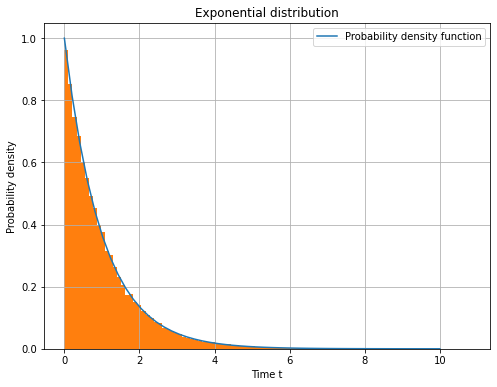

In [5]:
# Plotting
time = np.linspace(0, 10)

plt.figure(figsize = (8,6))
plt.plot(time, np.exp(-time), label = 'Probability density function')
plt.hist(samples, bins = 100, density = True)

plt.xlabel('Time t')
plt.ylabel('Probability density')
plt.title('Exponential distribution')
plt.grid()
plt.legend()

### 1.2 Generating incident angles
Cosmic muons may enter the detector with any zenith angle $\phi$ between 0 and $\frac{\pi}{2}$ - i.e. any angle from above the horizon. The zenith angular distribution is well approximated by a squared cosine distribution:

$P(\phi) = \frac{4}{\pi}\cos^2(\phi)$

Cummulative distribution of the $\cos^2(\phi)$ probability distribution is given by:

$F(\phi) = \frac{1}{\pi}(\sin(2\phi) + 2\phi)$


This does not have an easily calculable inverse function, so the inverse transform method is not be the most effective method to generate random numbers with this distribution. Instead, the acceptance-rejection (von Neumann) method will be used.

In [6]:
# Defining our distributions
def cos2_prob(phi):
    return (4/np.pi)*(np.cos(phi))**2

def cos2_cumm(phi):
    return (1/np.pi)*(np.sin(2*phi) + 2*phi)

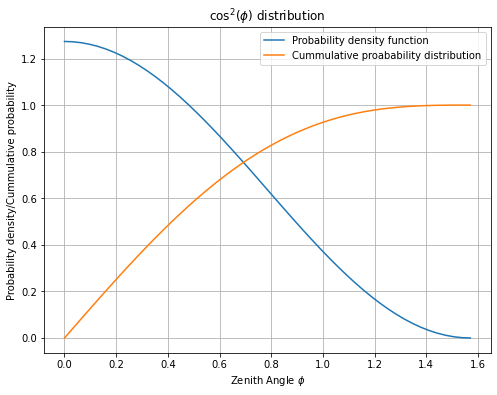

In [7]:
# Plotting
zenith = np.linspace(0, np.pi/2)

plt.figure(figsize = (8,6))
plt.plot(zenith, cos2_prob(zenith), label = 'Probability density function')
plt.plot(zenith, cos2_cumm(zenith), label = 'Cummulative proabability distribution')


plt.xlabel('Zenith Angle $\phi$')
plt.ylabel('Probability density/Cummulative probability')
plt.title('$\cos^2(\phi)$ distribution')
plt.grid()
plt.legend()

In [8]:
# Sampling
def vN_sample(pdf, domain = [0, np.pi/2], range = [0, cos2_prob(0)]):
    '''
    Produces a single sample point via the von Neuman rejection method. Always
    results in a single point being produced, which may require multiple loops
    if points are rejected. 

    pdf - the probability density function to be sampled. should take a single argument
          (i.e., in the form p.d. = f(x))

    domain - the domain of the pdf to be sampled, in the form [xmin, xmax]
    
    range - range of the pdf to be sampled in the form [ymin, ymax]
    '''
    while True:
        x = random.uniform(domain[0], domain[1])
        y = random.uniform(range[0], range[1])

        if y < pdf(x):
            return float(x)

In [9]:
# Testing sampling
N_samples = 40000

samples = np.empty(N_samples, dtype = float)
for i in range(N_samples):
    samples[i] = vN_sample(cos2_prob)

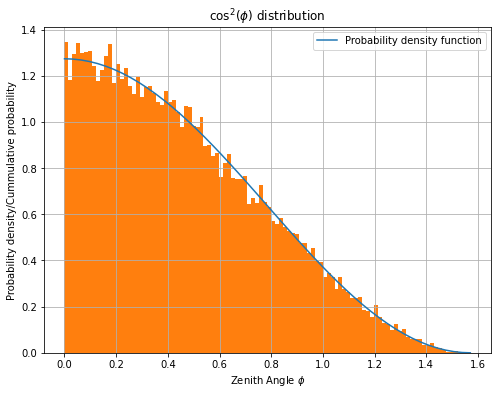

In [10]:
# Plotting
zenith = np.linspace(0, np.pi/2)

plt.figure(figsize = (8,6))
plt.plot(zenith, cos2_prob(zenith), label = 'Probability density function')
plt.hist(samples, bins = 100, density = True)

plt.xlabel('Zenith Angle $\phi$')
plt.ylabel('Probability density/Cummulative probability')
plt.title('$\cos^2(\phi)$ distribution')
plt.grid()
plt.legend()

## 1.3 Creating events

Using both of these distributions, we can produce events which contain a decay time and angle of detection.

In [ ]:
def gen_events(prob_muon = 0.5, nevents):
    '''
    Randomly generates decay times of muons and antimuons and associated detection
    angles. Muons are generated with probability prob_muon, and have an exponential
    distribution with parameter neg_lifeftime. Antimuons are generated with probability
    1-prob_muon, and have an exponential distribution with parameter pos_lifetime.

    prob_muon - the probability of generating a mu-. float between 0 and 1 inclusive.

    nevents - the number of events to be generated. integer greater than 0.

    Returns a 2d numpy array of shape [nevents, 2].
    '''

    # Empty array to hold data
    events = np.empty([nevents,2], dtype = float)

    for i in range(len(x)):
        if prob_muon < random.uniform(0.0, 1.0):
            events[i] = sample_exp(1.043E-6) # negative muon lifetime = 1.04E-6
        else:
            events[i] = sample_exp(2.1969811E-6) # positive muon lifetime = 2.1969811E-6
    
    return events



## 2.0 Example from pre-reading 

### 2.1 Functions for example

In [ ]:
# we will use this curve to fit to the pseudo data!
def f(x, a, b, c):
    """ Fit function y=f(x,p) with parameters p=(a,b,c). """
    return a * np. exp (- b*x) + c


def f2(x, a, b, c,a2, b2):
    """ Fit function y=f(x,p) with parameters p=(a,b,c, a2,b2). """
    return a * np. exp (- b*x) + a2 * np. exp (- b2*x) + c


def gendata(nevents, lambd_p, lambd_m, probmuon_m):
    '''
    Generates nevents of lifetimes for mu+/mu- decays. Lifetimes are exponentially distributed with
    parameters lambd_p (mu+) and lambd_m (mu-). The probability of a given muon being a mu- is given
    by probmuon_m.
    
    returns a 1d array of length nevents containing the lifetime data of each event.
    '''
    
    random.seed(123456789) # intialisation, seed, gives reproducibility of randomness
    
    x = np.empty([nevents], dtype=float) # empty array to store output in

    for index, elem in enumerate(x):

        lambd = lambd_p
        if (probmuon_m < random.uniform(0.0,1.0)): # generate muons with probability probmuon_m. 
            lambd = lambd_m # set decay constant to lambda minus
            
        lifetime = random.expovariate(lambd) # liftime generated with exponential distribution
        x[index] = lifetime # save the lifetime to be output
        print(index, lifetime) # print the current event no. and lifetime
    return x

### 2.2 Constants

In [ ]:
# muon life time in seconds
muonlifetime = 2.1969811E-6 # mu+ don't undergo muon capture in matter, so decay with the free muon lifetime
#muonminuslifetime = 2.043E-6

muonminuslifetime = 1.043E-6 # mu- can undergo muon capture and hence 'decay' faster -- slower lifetime

rhoNpoNm = 1.
probmuonminus = 1./(rhoNpoNm +1.) # probability of a simulated mu being mu-

# decay constant
#lambd = 0.5
lambd_plus = 1.0/muonlifetime
lambd_minus = 1.0/muonminuslifetime

### 2.3 Parameters

In [ ]:
# number of events
nevents = 100000
#nevents = 50000

#longest measured time
endtime = 0.00001

#number of bins
nbins =100
binsize = endtime/nbins 

### 2.4 Generating the data

0 8.148953048630298e-07
1 1.9328007501602696e-06
2 5.278896267789026e-07
3 1.21852907309607e-06
4 9.498897809423653e-07
5 1.7328408215943729e-06
6 2.013938934049034e-06
7 2.07660509556505e-06
8 2.1266653971058927e-06
9 3.932676691656251e-07
10 9.33399437805255e-07
11 9.764468037435835e-08
12 2.4293160849983415e-06
13 3.399512594838994e-08
14 8.516723523738355e-07
15 1.6135210902974504e-06
16 1.114883926619767e-06
17 2.862006448079515e-06
18 6.179600498161155e-07
19 2.6668799526367643e-07
20 2.539176298672359e-06
21 2.70218964509978e-06
22 2.1876916128033738e-07
23 1.4442193950754123e-07
24 2.503820273695712e-06
25 1.8149998955875399e-06
26 1.6123358736174144e-06
27 2.2407067865731455e-06
28 1.738267542214079e-06
29 3.014704058911096e-06
30 5.443641903481539e-06
31 2.8255681148173993e-06
32 1.2998177507490518e-06
33 9.384950908528982e-07
34 1.540802734513039e-06
35 1.2457556780043423e-07
36 2.6195631884250447e-06
37 1.55528276458112e-06
38 1.7289380643690333e-06
39 3.344534829491018e-07

485 3.1741162381081636e-06
486 2.2221078023629405e-07
487 1.375214818981632e-06
488 1.1167760665075617e-06
489 9.099926090826744e-08
490 2.7986493366062548e-08
491 4.711222327244188e-06
492 3.7609157288993857e-06
493 1.273638076210601e-06
494 1.2772837675740707e-05
495 5.30209673776883e-07
496 1.9764392046659376e-07
497 1.6214910444587085e-07
498 1.3867139332054292e-06
499 5.026755209618549e-07
500 1.5165235598476195e-06
501 6.885851123972039e-06
502 1.0896227845060143e-07
503 2.3441370625805607e-06
504 4.495388499290677e-06
505 5.049440651318502e-06
506 4.881500583041973e-07
507 6.511889226197284e-07
508 2.697598301748107e-07
509 7.656115557475124e-08
510 2.0260645006172837e-06
511 2.390436753671301e-06
512 1.278675999339775e-07
513 5.733423261910734e-07
514 3.647057395602408e-07
515 1.8444031034663406e-06
516 7.59294454125566e-09
517 3.068370412727481e-07
518 4.6708783180607525e-07
519 2.8075840994139684e-07
520 2.063380371616631e-06
521 2.9414369644463984e-06
522 2.057346679191439e-

985 2.1283391521574897e-07
986 6.918596441054048e-08
987 5.711415458478707e-07
988 1.5564629732505248e-07
989 6.392340779326829e-07
990 8.826580131692762e-07
991 1.2362960516368662e-06
992 9.333821570810352e-07
993 8.071264537976608e-07
994 5.191621407506228e-07
995 7.192333998229849e-07
996 3.367814515184675e-08
997 4.314398528689486e-06
998 2.50323382517491e-07
999 4.901127254847081e-06
1000 4.83050793328769e-07
1001 1.2245390399761408e-06
1002 5.7469894179223e-06
1003 2.0298642229791996e-06
1004 5.9035778281919e-07
1005 4.883083989960408e-07
1006 2.426872883248766e-06
1007 3.7357798445864657e-06
1008 7.154501009559793e-06
1009 3.782193081063571e-07
1010 1.8571126539092499e-06
1011 2.0368781616037784e-07
1012 1.1137025263402007e-06
1013 2.1397880801579278e-07
1014 1.3290540117110383e-06
1015 7.019113008808577e-06
1016 5.896045471885491e-07
1017 1.5885588241884945e-06
1018 1.472745016742997e-06
1019 7.432223316612258e-06
1020 1.9317219902824287e-07
1021 3.7807574686857753e-07
1022 2.1

1734 9.416133589189085e-07
1735 8.89961413268994e-07
1736 1.9511710581969083e-07
1737 1.6545980377087425e-06
1738 8.63845275529642e-07
1739 1.468947282706965e-06
1740 3.9902462583838705e-07
1741 5.928232965748774e-07
1742 1.8860850109544436e-06
1743 3.013778752831946e-07
1744 3.7308244496444233e-07
1745 8.41031374366317e-06
1746 1.116700879581526e-06
1747 3.006484791603305e-06
1748 2.2754550716956646e-06
1749 9.570537043437273e-07
1750 2.4189025968390843e-06
1751 9.186190241366781e-07
1752 3.7374250892143377e-06
1753 1.5019949224417846e-06
1754 6.335372580675905e-07
1755 2.1531020479316804e-06
1756 1.3944946038556812e-07
1757 3.9352821245216787e-07
1758 3.7426413858891225e-06
1759 6.355013122392571e-06
1760 3.7777407228778567e-07
1761 2.218465193562469e-06
1762 7.066273785054861e-07
1763 3.474724463358684e-06
1764 1.5737886802115883e-06
1765 8.568732656137419e-07
1766 3.1555553593605945e-06
1767 6.070114481086987e-07
1768 1.1453418681085984e-08
1769 1.0796755407472239e-06
1770 3.711984

2271 6.578148395765419e-07
2272 6.943769782026308e-07
2273 7.427654894654391e-07
2274 1.1469605672919166e-06
2275 1.7137530714279896e-06
2276 1.5708082147232224e-06
2277 2.5864586578282347e-06
2278 1.2226540107568699e-06
2279 4.558317695115475e-06
2280 1.1661370113931766e-06
2281 1.9335452932823128e-06
2282 2.1269998280971483e-06
2283 2.3553453203310325e-06
2284 6.480259891137248e-07
2285 3.6841988901551916e-07
2286 1.8463447431861086e-06
2287 6.791662479916546e-06
2288 4.456822720464011e-08
2289 2.442980563292613e-07
2290 2.429810847451686e-07
2291 3.5306230169198585e-06
2292 1.9044459098733159e-06
2293 7.161918169967089e-07
2294 3.7414118723386114e-07
2295 8.378172068514755e-07
2296 3.144957788502716e-08
2297 7.093303480308128e-07
2298 6.54400406160364e-07
2299 2.0672060558117074e-06
2300 2.8211741986038716e-07
2301 6.852303886142342e-06
2302 6.317629199813028e-08
2303 4.873366913152216e-06
2304 3.272621838294609e-06
2305 1.5367119611273113e-07
2306 1.0628998621794786e-06
2307 2.3086

2734 3.3728499426221265e-06
2735 6.056152010448139e-07
2736 1.1859026261145427e-06
2737 4.868529178370783e-08
2738 2.339452005486345e-06
2739 9.339127467017909e-07
2740 9.583354556475706e-08
2741 4.108607518348566e-07
2742 1.9733776362011994e-07
2743 1.7014742972778285e-08
2744 4.728304318669786e-06
2745 7.300416392071449e-07
2746 2.8890506638549856e-06
2747 4.3976618785178194e-06
2748 3.8584246211937723e-07
2749 1.750839844155968e-06
2750 2.9348085806931775e-06
2751 2.407886402680211e-06
2752 1.2994725988034197e-07
2753 4.120257278606246e-06
2754 1.522934306574952e-06
2755 3.199860291888445e-06
2756 3.805603809058232e-08
2757 6.356976076903751e-06
2758 1.0999021719504967e-06
2759 6.440860957476493e-07
2760 3.0300130627840154e-07
2761 1.9189471749145116e-06
2762 1.0664880385304754e-06
2763 3.925141944968493e-07
2764 3.4989713968905305e-06
2765 4.21074661732738e-07
2766 1.5290772650647746e-06
2767 1.3237111002905105e-07
2768 5.300451098647762e-07
2769 1.0848299624351458e-06
2770 1.78749

3483 1.0454978382820253e-07
3484 1.9508043862934953e-07
3485 2.6094829976063826e-06
3486 8.081991061442225e-06
3487 1.0268936445550762e-07
3488 5.075397655373546e-06
3489 1.4028944148363311e-06
3490 2.8079249468929374e-06
3491 4.6623142190298745e-07
3492 3.4922809152700815e-06
3493 2.837846432685316e-07
3494 2.1000298576878325e-07
3495 1.527540960754706e-06
3496 4.602863238029111e-08
3497 1.5182090183728984e-06
3498 4.9002751402449555e-08
3499 1.4472800084872917e-06
3500 4.898951625059668e-07
3501 3.4663237132175907e-07
3502 1.8221564208625366e-06
3503 9.938471897249843e-06
3504 1.425503757146367e-06
3505 1.7825510957684702e-07
3506 3.0523437089325645e-07
3507 3.5640837120720326e-06
3508 1.547144982118101e-06
3509 2.980439178424401e-06
3510 1.4044142340518998e-06
3511 1.5560349421410226e-06
3512 6.804127744294232e-07
3513 1.522036685061409e-07
3514 1.0596374368519388e-06
3515 3.3936468339818964e-07
3516 9.588532910438104e-08
3517 9.188110669365474e-07
3518 1.9785833545175926e-06
3519 3

3983 6.046448917005456e-06
3984 5.617761964897634e-07
3985 1.3735432419612083e-07
3986 6.836456243484947e-06
3987 3.8686458203332853e-07
3988 4.793791832279138e-07
3989 1.933765475076425e-07
3990 1.563572813017889e-06
3991 3.4127992670839005e-06
3992 5.996201848452272e-06
3993 1.9527211261147714e-06
3994 2.132139046182494e-06
3995 4.589783477628037e-06
3996 1.3035841659970348e-06
3997 1.2314833776544892e-07
3998 1.347932937262502e-06
3999 8.820511109453925e-07
4000 3.940426642083086e-07
4001 1.1986145760175005e-06
4002 2.2193057002196805e-06
4003 1.0381974289514273e-05
4004 1.0313404113967806e-08
4005 6.820437116630213e-07
4006 2.782732826536878e-06
4007 9.528272570868045e-07
4008 8.586490309600848e-06
4009 7.249465813681557e-08
4010 6.365082664721793e-07
4011 2.566969821616869e-07
4012 2.999128375216333e-08
4013 2.6504137036931198e-06
4014 4.082665147842193e-06
4015 7.89110151890663e-07
4016 1.0627300339971295e-06
4017 6.544779473690329e-06
4018 1.3248634092835874e-06
4019 2.196804206

4451 9.294528446409051e-07
4452 1.8056828483635537e-06
4453 1.7473323842920067e-06
4454 2.118797256903389e-06
4455 1.1457935633311331e-07
4456 6.326448793810928e-07
4457 7.149351213881357e-08
4458 3.985150677919205e-08
4459 5.438464390870431e-07
4460 8.982261434080577e-08
4461 3.484695898658667e-06
4462 1.0789864190822703e-06
4463 2.6853481131231364e-06
4464 4.191100733453814e-07
4465 3.3772768743142244e-07
4466 2.805931885289667e-06
4467 6.741426196788576e-07
4468 4.015958396083507e-06
4469 3.936632749958356e-06
4470 1.5283788931853118e-06
4471 8.357238654716256e-07
4472 1.718483067391936e-06
4473 3.6929911378350457e-06
4474 3.106694559922971e-07
4475 1.067616596253291e-06
4476 5.574521711420638e-07
4477 3.695711882819385e-07
4478 1.992708782217373e-06
4479 5.640961310723673e-07
4480 2.7106475045962518e-06
4481 1.0602885041149742e-06
4482 3.8279722894973305e-06
4483 6.945130292165733e-07
4484 1.0639273514325681e-08
4485 7.707816758593416e-07
4486 4.979895805968188e-06
4487 7.594969529

5232 2.458233498126306e-06
5233 9.747573516008129e-06
5234 2.7705121745425416e-07
5235 1.268464137850526e-06
5236 2.3515897539357788e-06
5237 2.5111867876542006e-06
5238 8.08783732812318e-06
5239 1.2277549284891028e-06
5240 6.132090452350663e-07
5241 1.1139130824786398e-07
5242 7.220268208382173e-07
5243 1.0143796187423619e-06
5244 4.809075017383777e-06
5245 8.217454640297253e-07
5246 9.401368051244288e-07
5247 4.2145977809120625e-06
5248 5.548018128199868e-07
5249 5.653174065374965e-09
5250 2.6865471666120125e-06
5251 3.887102302791786e-07
5252 1.5440654591020657e-06
5253 9.800804127468965e-07
5254 9.17174632746025e-07
5255 2.190654450265365e-08
5256 6.220236309072771e-07
5257 3.9871937079710274e-07
5258 3.37443776145204e-06
5259 5.719565646050711e-06
5260 1.3416868035239e-06
5261 1.1300247164439658e-06
5262 1.1243082291399388e-06
5263 2.8746048561270636e-06
5264 5.1927453002436247e-08
5265 3.4951189190784983e-06
5266 1.4922569249933184e-07
5267 1.9200933150170399e-07
5268 3.444919135

5891 7.7858057574328e-07
5892 2.371952957247718e-06
5893 1.2301711736797845e-08
5894 3.836968087616373e-06
5895 1.3459068415292402e-06
5896 2.4453700528461077e-06
5897 1.0659657693845857e-07
5898 5.6277185492576576e-08
5899 1.1053800015339952e-06
5900 6.56129279629551e-07
5901 1.288293936983173e-06
5902 4.980369148545015e-07
5903 2.279675874227545e-07
5904 4.958960576014916e-06
5905 1.1187758421062698e-06
5906 3.1898710141344415e-08
5907 9.548873849042999e-08
5908 2.599031663528432e-06
5909 2.13715471405235e-06
5910 2.814658394676438e-06
5911 3.5701558964178087e-07
5912 2.3770451064972916e-06
5913 5.865871095627552e-07
5914 1.1874092310740974e-06
5915 1.5450424544775022e-06
5916 4.792917131230201e-08
5917 6.431057017228149e-07
5918 9.828824308864572e-08
5919 3.712618603959028e-06
5920 5.302919523639025e-07
5921 1.7813557743009242e-06
5922 1.0940075369080138e-07
5923 2.2572815581527084e-06
5924 5.462250674497204e-07
5925 7.88519560545694e-07
5926 2.7384839971963875e-06
5927 5.1274678342

6231 4.828987709695637e-08
6232 1.0548914374001422e-06
6233 4.986298064353218e-06
6234 1.1797339279214211e-06
6235 6.263654285134782e-06
6236 2.3461250531998485e-06
6237 4.228025124376781e-06
6238 2.8039273931808535e-06
6239 4.47504541903312e-06
6240 3.8823241470753943e-07
6241 4.129336871098973e-07
6242 2.5805310662914487e-06
6243 1.1085779332013817e-07
6244 1.1177263771819136e-06
6245 2.0439197373912525e-06
6246 1.373338977591772e-06
6247 8.048018670595347e-07
6248 3.3266235000625828e-06
6249 7.129291124199611e-07
6250 2.8344468948871344e-06
6251 1.1294754553319706e-06
6252 3.4140906360674434e-07
6253 1.3935071531789966e-06
6254 4.5041481860728215e-07
6255 1.7450515568013338e-07
6256 1.8901923912497135e-06
6257 1.2469289732185053e-06
6258 4.501861313640408e-06
6259 1.3969650595289495e-06
6260 8.228948210456867e-07
6261 8.409963036959017e-07
6262 3.6227449439865333e-07
6263 3.7695174629849635e-07
6264 2.1553675878985364e-06
6265 3.7190180851873655e-06
6266 9.805532202549507e-07
6267 2

6557 1.4684841729994345e-06
6558 8.98238163406266e-07
6559 4.563396996466165e-07
6560 7.09968636149918e-08
6561 2.045935175961298e-07
6562 9.874850201572264e-07
6563 8.437084718168789e-07
6564 5.732441036536498e-07
6565 3.9685547509153596e-07
6566 2.8073364137739514e-06
6567 1.4807153542034925e-06
6568 1.107383791237582e-06
6569 5.357810834383312e-06
6570 3.840385218782843e-07
6571 3.7490687712503035e-06
6572 7.592127436137623e-07
6573 4.174255085886634e-06
6574 7.924240768729832e-07
6575 2.879468627149832e-06
6576 3.4437602071100636e-06
6577 5.093472888782518e-07
6578 1.4509608344127144e-06
6579 7.028287426876619e-08
6580 1.2255820047674264e-06
6581 2.007192199807458e-06
6582 1.0293819968580772e-06
6583 1.0017882694231664e-06
6584 2.4266770805612435e-06
6585 1.444007710412785e-05
6586 2.1973984051712467e-06
6587 3.6904029077835185e-06
6588 3.110714436486502e-06
6589 1.5642120354691838e-06
6590 1.297186450175719e-06
6591 3.538874076749076e-07
6592 3.2583499761336807e-06
6593 1.16099421

6981 3.4066302678093047e-06
6982 1.3856816837599803e-06
6983 3.2804231905142164e-06
6984 8.137858938402026e-06
6985 9.772635947063137e-07
6986 8.841189153759651e-07
6987 1.300747768407917e-06
6988 3.409774036728984e-06
6989 7.414271496400613e-06
6990 5.526026761425645e-07
6991 9.443056579022412e-07
6992 1.3294571424982393e-06
6993 1.3562632628218245e-07
6994 7.96718512892691e-07
6995 2.0417837369675636e-06
6996 3.507845437919982e-08
6997 5.965936890556495e-07
6998 1.618031453769102e-06
6999 3.600023524601942e-06
7000 4.682198222286391e-06
7001 3.055959106431693e-07
7002 1.6018636789625238e-06
7003 4.621732968896275e-07
7004 2.86447379442162e-06
7005 1.7425105636083502e-06
7006 1.5702633876155705e-06
7007 4.021366767775038e-07
7008 2.453518732617251e-06
7009 9.593449520073146e-08
7010 2.3059340190236533e-07
7011 2.962702040995773e-06
7012 1.1100710649429269e-06
7013 4.18131676873118e-06
7014 9.049158180500799e-07
7015 3.31172712351778e-06
7016 1.7593411940753764e-06
7017 1.8522092523607

7566 1.3464384530037252e-06
7567 3.974009148880687e-07
7568 9.051124958578733e-07
7569 2.62907050586304e-06
7570 2.0622447835080867e-07
7571 3.3049973151015797e-07
7572 4.540227598707174e-06
7573 2.4120061594324886e-06
7574 5.808622655016536e-07
7575 8.014491935628505e-06
7576 2.381760633871271e-06
7577 1.5952409054818627e-06
7578 1.2545071056648307e-06
7579 3.169433145775488e-08
7580 1.271825379675737e-06
7581 2.3126101478747914e-09
7582 7.769366407130119e-06
7583 1.9208594155424945e-06
7584 8.029120172142449e-06
7585 3.1034519296632187e-07
7586 4.711296412318961e-07
7587 2.9140616325236065e-07
7588 2.155353671182343e-07
7589 3.0805098707499757e-06
7590 2.9229062377302513e-06
7591 7.420458902090901e-06
7592 5.500919532212492e-07
7593 3.367091626767777e-07
7594 6.825180953165643e-07
7595 5.0438880078644806e-08
7596 9.788659046542665e-07
7597 3.740113671384841e-07
7598 1.060690993856982e-06
7599 2.984758182564602e-07
7600 4.1480466355982404e-07
7601 1.2540523151247626e-06
7602 1.9483808

7980 1.5713072551101849e-06
7981 2.9163170548813854e-06
7982 2.3568586648990554e-06
7983 6.397239651877657e-07
7984 4.671199506298525e-08
7985 1.245960080246296e-06
7986 8.231539326744758e-07
7987 1.372428596640802e-06
7988 1.2891913337236538e-06
7989 3.970407799433992e-06
7990 3.0944250974442226e-07
7991 5.682550014427555e-07
7992 3.2070583569225894e-06
7993 2.3921520394299427e-07
7994 1.0768109817112084e-06
7995 5.778287484962948e-07
7996 9.581702460833799e-07
7997 1.640136954621529e-08
7998 1.108317644584688e-07
7999 1.043553869235767e-06
8000 1.6281466297335439e-06
8001 1.739102310179787e-06
8002 1.147607683574239e-06
8003 9.5396545530161e-07
8004 4.292894940994435e-06
8005 9.995273787334195e-07
8006 3.449128577337264e-06
8007 1.0114294762726452e-06
8008 8.37332049607282e-06
8009 3.9473469271420067e-07
8010 9.423917382081986e-07
8011 6.53315046202288e-07
8012 2.807207805744613e-06
8013 3.93853201607092e-06
8014 1.2921798441121766e-06
8015 3.0504432708393598e-06
8016 3.6960670750249

8408 6.431460671894645e-07
8409 2.6017262554192183e-06
8410 8.315985834236343e-07
8411 2.0251145252718312e-07
8412 2.5402020101561833e-06
8413 1.3770261978648682e-06
8414 3.150038180370265e-07
8415 1.8471579437831392e-06
8416 1.1736954007497744e-06
8417 1.744499121755858e-07
8418 1.3084232686914467e-06
8419 6.457945308815375e-08
8420 9.678480892027068e-07
8421 2.6504655887409416e-06
8422 2.471399499790246e-07
8423 4.2161180429867944e-07
8424 4.840972576163994e-07
8425 3.228034007064025e-07
8426 7.092942318953654e-07
8427 3.7127280397313463e-06
8428 1.4811965980420396e-07
8429 1.2999113496423367e-06
8430 1.2318977872527275e-06
8431 8.666709657723548e-07
8432 2.7176534960516774e-07
8433 5.662342364182753e-07
8434 1.544641778712277e-07
8435 1.4660087579455216e-06
8436 1.2200706656525023e-06
8437 1.6643867492326258e-07
8438 8.11235121325668e-08
8439 1.7117269005822818e-07
8440 5.109195771875055e-06
8441 9.69812973029879e-06
8442 2.7199660461590847e-06
8443 3.6099651580337796e-07
8444 2.641

8759 6.141954663231591e-07
8760 9.91207368710166e-08
8761 1.0114512498134158e-07
8762 4.2351912318989427e-07
8763 8.326322297082635e-07
8764 6.603728769791517e-07
8765 6.946843719228827e-06
8766 2.963175676439637e-09
8767 3.6509828388489333e-06
8768 1.8247402291601968e-06
8769 4.113768340505544e-07
8770 2.7291247895416876e-07
8771 3.4456835742645994e-06
8772 1.1953209413067266e-06
8773 1.9377514125710614e-06
8774 7.983000792990468e-07
8775 4.818209867282609e-07
8776 1.8988124558656745e-07
8777 2.1478386495943452e-07
8778 9.568729573139946e-07
8779 8.424820135625032e-07
8780 3.228975824522974e-07
8781 2.560777534492744e-06
8782 3.2095876553452846e-07
8783 9.674183897418689e-07
8784 3.0564860462926896e-06
8785 2.080468708804226e-06
8786 2.0757185157652377e-06
8787 4.8913376188866105e-06
8788 6.867906656571613e-08
8789 2.1063603722140318e-06
8790 7.693647110840449e-07
8791 3.163709973032237e-07
8792 6.53832522847607e-07
8793 5.29725057821779e-06
8794 1.1187156017692517e-06
8795 3.19029511

9076 2.248882622133728e-06
9077 1.9658681841487016e-06
9078 2.056455055140743e-06
9079 2.2225852461360248e-06
9080 3.201236067093664e-06
9081 1.1805685043914822e-06
9082 6.493314734190773e-06
9083 1.9168454385227742e-06
9084 5.3128371121725916e-06
9085 5.018292613401834e-06
9086 7.504283224958971e-07
9087 3.535814279741917e-07
9088 3.154777235532354e-10
9089 1.0114959555015918e-06
9090 3.6849538641063444e-06
9091 3.4107943048011906e-07
9092 3.9527434428177986e-07
9093 1.1794461355851054e-06
9094 2.709342441513336e-06
9095 2.9992305407310786e-06
9096 2.6536006176593778e-06
9097 5.706844018975744e-07
9098 1.5925901037154962e-07
9099 7.316432180449183e-08
9100 1.030217985123567e-06
9101 6.840768948377337e-07
9102 2.1734112962903804e-07
9103 1.1838930871332434e-06
9104 3.680496168996316e-06
9105 6.838385547286619e-08
9106 5.687831430020728e-07
9107 9.232780594243789e-08
9108 2.939611649327531e-07
9109 3.64833702115891e-07
9110 1.5899333294408236e-06
9111 2.1800801454414795e-06
9112 1.64637

9479 4.698400388439324e-06
9480 4.6044557469454373e-07
9481 1.3555613503894062e-06
9482 1.2302459773466464e-06
9483 8.884270880245569e-07
9484 3.480687653368876e-06
9485 3.0596944561971295e-07
9486 3.178771491427131e-07
9487 1.0120123731827644e-06
9488 1.2783539407494432e-06
9489 2.861516075862146e-07
9490 2.6537471103307893e-06
9491 2.077679336677249e-06
9492 1.6600902953015525e-06
9493 4.247817666615953e-06
9494 1.7187614810496369e-06
9495 1.2603882238476354e-06
9496 5.681170867185809e-07
9497 2.177804750115953e-06
9498 5.812597862925337e-06
9499 1.6763674374901252e-07
9500 1.6342414438906946e-06
9501 4.701211517178708e-07
9502 2.439433194063028e-06
9503 2.1789566412200298e-07
9504 1.0962343270221284e-06
9505 3.830115534587722e-07
9506 6.097681426267539e-08
9507 1.5827815680131267e-07
9508 4.89423262629888e-07
9509 9.916064884621505e-07
9510 6.016129578353679e-07
9511 8.803849305695327e-07
9512 1.2874897034294948e-06
9513 3.0838226752286254e-06
9514 1.6549237112388099e-06
9515 1.0572

9841 1.752916906755026e-06
9842 2.1033748421556009e-07
9843 2.062475748863724e-06
9844 5.022756642325866e-07
9845 4.85807551062711e-07
9846 1.537649383672132e-06
9847 4.4981781521735305e-07
9848 2.002561830962909e-07
9849 1.0547150801962725e-06
9850 4.791390596020663e-07
9851 1.4355971435292761e-06
9852 1.5180452215537903e-06
9853 3.6235776040021498e-06
9854 1.2891820206933027e-06
9855 7.908203768363876e-07
9856 1.9226695633566747e-08
9857 2.3933948043349975e-07
9858 1.1529661118056918e-06
9859 6.674173330395745e-06
9860 6.657361282104432e-06
9861 6.658691675293409e-06
9862 6.606595564568625e-07
9863 1.0739688927623502e-06
9864 5.614494973317349e-07
9865 9.43413288941524e-07
9866 4.3543685993993417e-07
9867 5.868470079773099e-07
9868 3.244955460328519e-07
9869 7.211888619613844e-07
9870 1.5191451807634536e-06
9871 3.603689966487579e-07
9872 9.331394252388819e-07
9873 7.455627544926143e-06
9874 8.774381754193605e-07
9875 5.169336399033887e-08
9876 1.6261113681990528e-07
9877 2.832599777

10317 1.882068221699335e-07
10318 1.214239325856763e-06
10319 4.948787166111385e-07
10320 2.4232764419265463e-07
10321 4.646533594967714e-07
10322 1.4577221836231392e-06
10323 4.328790309715696e-07
10324 2.666365246511474e-07
10325 1.1804123996563518e-06
10326 1.058529879404248e-06
10327 6.886914207465468e-08
10328 7.667796398087326e-07
10329 1.8318375667546825e-07
10330 1.917021730424858e-06
10331 2.0086854688948274e-07
10332 6.779540741880031e-08
10333 5.302552760745153e-07
10334 1.066633860978908e-06
10335 2.800326078003415e-06
10336 1.1696785847311186e-06
10337 8.154678344033969e-07
10338 3.7087395403019967e-07
10339 1.465430072256805e-06
10340 2.738284632774552e-06
10341 1.2192545031713412e-06
10342 7.438461311158794e-06
10343 1.2471970086616712e-08
10344 6.208352351002305e-07
10345 8.387658045592353e-07
10346 1.7214869244172544e-07
10347 7.407253261257778e-07
10348 1.2423911531332698e-06
10349 7.942672658912867e-07
10350 2.7111988943444057e-06
10351 1.8667288561944704e-06
10352 1

10750 9.906372283441453e-07
10751 7.867999652876657e-07
10752 1.0788325384121525e-06
10753 1.839014873117642e-06
10754 5.953850147985168e-06
10755 6.265524320518125e-08
10756 4.3914779466776695e-07
10757 6.615734347217481e-06
10758 3.8661530669407526e-08
10759 2.2810243084601104e-07
10760 1.3789581246564544e-07
10761 3.1754754986790318e-06
10762 1.8844078737503801e-06
10763 1.9274772002498566e-07
10764 2.278630995489552e-07
10765 1.687245977363381e-06
10766 3.71548479040164e-08
10767 6.54608232006211e-07
10768 3.979876758090755e-07
10769 7.084520535476707e-08
10770 2.977136923697868e-06
10771 3.6895309449198377e-07
10772 4.885216527184625e-07
10773 1.0505214429819748e-06
10774 3.794617798401408e-07
10775 1.1541221927230074e-07
10776 2.732243289730246e-07
10777 2.7744470000616037e-06
10778 2.6489494669301517e-06
10779 1.2530818099822983e-06
10780 9.366418419434828e-07
10781 2.13238152781144e-06
10782 6.827084990584197e-07
10783 2.483997286631516e-08
10784 1.217036675484556e-06
10785 3.0

11228 3.5303877728110288e-06
11229 4.645978066341192e-07
11230 7.171323728629611e-07
11231 2.485841778012068e-06
11232 1.4084480760387334e-06
11233 1.5375796354504698e-07
11234 3.902140087477272e-06
11235 6.461625351981011e-07
11236 5.663110389781032e-08
11237 5.232799793489075e-07
11238 3.5281448497033686e-07
11239 4.2302921761153375e-06
11240 3.063073004814541e-06
11241 1.6108360095362366e-06
11242 5.138674997083214e-07
11243 8.363314248718964e-07
11244 7.47901863195026e-07
11245 1.514735921794868e-06
11246 4.836284300872631e-06
11247 1.4597639318786621e-06
11248 1.354449774566633e-07
11249 2.484429072407977e-06
11250 3.3323514021547023e-06
11251 2.5021664881895556e-08
11252 1.9248555487676305e-06
11253 2.0779071646955167e-07
11254 2.4539935958219966e-06
11255 3.8592804796887755e-07
11256 1.1851296981787892e-06
11257 4.770871721103631e-07
11258 3.3511984256408955e-06
11259 5.480748360575716e-07
11260 1.0523216645175501e-06
11261 2.3512231160458753e-06
11262 7.237163992918469e-07
1126

11516 1.9245795135780317e-06
11517 1.2292408372357255e-06
11518 2.630949095987451e-07
11519 8.634507738249565e-07
11520 7.143004069375744e-07
11521 2.475278657622429e-06
11522 1.549501186081826e-06
11523 6.476759483732754e-08
11524 6.599797262209625e-07
11525 3.0651972611038637e-07
11526 3.142636822377211e-06
11527 7.416079158834629e-07
11528 1.6656405530929714e-06
11529 3.223235458934818e-07
11530 3.1624848409880095e-08
11531 1.2237176302418726e-06
11532 4.694691796981677e-07
11533 1.426644172667526e-06
11534 1.1162426929969329e-06
11535 3.4978115239604184e-08
11536 7.916948532246127e-08
11537 1.765936566578637e-06
11538 1.008161399393724e-06
11539 3.129272986407255e-07
11540 1.1232776094785235e-06
11541 8.516999566098999e-07
11542 1.83416168247277e-06
11543 9.252612027266323e-07
11544 1.0288443399878198e-06
11545 4.47633869410181e-06
11546 7.055837630196677e-08
11547 2.3042686137929356e-06
11548 3.6204015896745155e-06
11549 2.1448098060637418e-06
11550 3.751910683519983e-06
11551 1.4

11977 4.5428084495489794e-07
11978 3.163582635337425e-07
11979 1.1460351718636855e-06
11980 2.0715471854669652e-07
11981 1.7105016053899051e-06
11982 1.1296826436278997e-07
11983 2.0252077919859486e-06
11984 2.309492519569301e-07
11985 1.3507747548388622e-06
11986 2.7056213895978027e-07
11987 4.857095615977776e-07
11988 5.031043611167897e-07
11989 1.911630262461884e-06
11990 1.8105032005165074e-06
11991 6.639230816270645e-07
11992 1.4819939338186672e-06
11993 2.4104805463502655e-06
11994 2.209297051141253e-06
11995 5.908372317012444e-07
11996 2.4433808904424734e-07
11997 5.158010129414502e-07
11998 2.763421014562101e-06
11999 4.607907717476841e-06
12000 9.78464237979663e-07
12001 2.332191577661127e-06
12002 4.5079410176754636e-06
12003 3.267936972459508e-07
12004 1.3336573609009654e-06
12005 3.24180452708254e-07
12006 1.0064122904715082e-06
12007 4.156508517162542e-06
12008 6.36504069259749e-07
12009 6.7247974947641285e-09
12010 2.6216910756234088e-06
12011 1.3213724217446571e-06
12012

12477 5.890880831985141e-07
12478 5.04051367417889e-07
12479 2.4995588163882946e-06
12480 2.1614789287150226e-06
12481 3.542057563508174e-06
12482 1.1251469092596366e-06
12483 5.320719824467047e-07
12484 2.0798642780759952e-07
12485 4.803552712737167e-07
12486 1.4682572788188513e-06
12487 7.125969508669533e-07
12488 3.3362128348628256e-06
12489 1.49256148333992e-06
12490 1.072453526303447e-06
12491 9.254729221840525e-06
12492 1.0649270276915433e-07
12493 2.8903592680714494e-07
12494 6.892873589379714e-06
12495 3.565794123445828e-06
12496 5.059250388609071e-07
12497 3.21533362230471e-06
12498 4.1081318833400413e-07
12499 6.168515803229228e-07
12500 1.1615526678460845e-07
12501 4.4886939731397257e-07
12502 1.9041849060662764e-07
12503 4.66013469579698e-06
12504 1.2634785723883405e-06
12505 4.7295764015217353e-07
12506 2.1705119294191934e-07
12507 2.3791666155877748e-07
12508 9.211008485101077e-07
12509 2.081225670239265e-06
12510 5.173816566595583e-07
12511 1.9022508619415408e-06
12512 4

13226 2.063975134405589e-06
13227 7.930468477375955e-07
13228 7.2026988766951e-07
13229 1.2243898393086056e-06
13230 1.1283897433482485e-06
13231 2.535746640607023e-06
13232 1.6212541231547493e-06
13233 6.530240478697092e-07
13234 1.4455056177277384e-07
13235 5.1140569503851275e-08
13236 9.363272408156761e-07
13237 3.5415999379429253e-06
13238 8.070595106124702e-06
13239 4.6294817593085077e-07
13240 1.74464842094382e-06
13241 6.367238196065051e-07
13242 2.0081424599691406e-06
13243 5.767941626392483e-08
13244 8.692289487919094e-06
13245 2.2960989460485393e-06
13246 6.229033197711859e-07
13247 1.9147539712212153e-07
13248 2.3990413904074324e-06
13249 1.7942742199033724e-07
13250 2.3449793609913257e-07
13251 7.1499083821418815e-06
13252 5.17431167197269e-07
13253 1.6070965082466258e-06
13254 1.2734330685204332e-06
13255 1.4740522145944565e-06
13256 3.8973421967647957e-07
13257 7.264019327093967e-09
13258 5.422783944890865e-07
13259 2.020043373149843e-06
13260 1.7444266911524845e-06
13261

13726 1.2968104985881481e-05
13727 2.39440590760286e-06
13728 2.18410267056407e-06
13729 1.0294285497145074e-06
13730 9.968903497792385e-06
13731 4.842739996486339e-06
13732 4.512230796021444e-07
13733 3.3917143849278007e-07
13734 1.7750101436459865e-06
13735 7.338328486229466e-07
13736 4.966276822700741e-06
13737 3.736012536212798e-06
13738 3.384345415875238e-06
13739 8.320137436191428e-07
13740 1.2119112294375456e-06
13741 7.789735097252401e-07
13742 5.343292302601405e-06
13743 9.265294136921473e-07
13744 6.610308570889194e-06
13745 3.771201865778475e-06
13746 1.8674691707408238e-06
13747 2.8342391763737043e-07
13748 1.250722585032272e-06
13749 6.470913770841866e-07
13750 3.117063457935068e-06
13751 1.4599964522323465e-06
13752 2.4247997313143416e-06
13753 1.6660783173837532e-07
13754 1.063326902960245e-06
13755 2.4074991862678577e-06
13756 2.047971642403599e-06
13757 7.830736255039416e-07
13758 4.2121075338749934e-07
13759 2.2722143621549514e-06
13760 1.7935803464160439e-06
13761 3.

14036 6.986523154818445e-07
14037 1.7647770478412231e-07
14038 2.0720327581482963e-06
14039 4.181604442768692e-07
14040 4.5785480863462366e-08
14041 1.4576473287375444e-06
14042 2.4755673412859674e-07
14043 3.276275402478033e-07
14044 2.893365532219607e-07
14045 9.365802279670203e-07
14046 6.837179311370005e-07
14047 3.164406861729599e-07
14048 6.071931756803198e-07
14049 2.0149430270015813e-06
14050 1.8612917309220556e-06
14051 1.218577030003659e-07
14052 2.684669617287755e-08
14053 1.1942948235345258e-06
14054 1.2065349319264986e-06
14055 3.199065938045458e-07
14056 7.247501234834385e-07
14057 4.431405384692215e-08
14058 3.66032463835016e-07
14059 1.156765814286117e-06
14060 1.463920811678305e-06
14061 1.6816868760945892e-06
14062 6.880834146314296e-07
14063 1.4184728825242746e-06
14064 8.018146132189538e-07
14065 3.866249023063555e-07
14066 2.115645681375002e-06
14067 3.2231340101827893e-06
14068 1.4089043589463161e-06
14069 1.898333920270609e-06
14070 7.808374516390642e-07
14071 1.

14475 7.67886121556599e-07
14476 2.3217120903809537e-07
14477 1.822454018034983e-06
14478 1.1999978877489838e-06
14479 5.496879136664172e-07
14480 4.409388106123532e-07
14481 8.913119534571394e-07
14482 4.065515278797958e-07
14483 5.154651394527107e-07
14484 9.112850381644514e-07
14485 3.3740786444476555e-07
14486 1.8389016004594736e-06
14487 3.186850233928066e-06
14488 1.8685092487487008e-06
14489 8.764802125217405e-07
14490 1.5265051052909572e-06
14491 2.4177002564497307e-06
14492 1.721074265065956e-07
14493 1.3425031747144821e-05
14494 1.8460841298905814e-06
14495 1.214442136975819e-06
14496 3.8900050369316393e-07
14497 9.618805406297897e-07
14498 3.3020785930910767e-06
14499 5.08401963786208e-07
14500 1.6004232981215177e-06
14501 2.517929236399619e-07
14502 7.812933978859187e-07
14503 3.2288869244797532e-06
14504 3.3627358834392648e-06
14505 4.0570752924976453e-07
14506 6.311865629400213e-06
14507 1.7969801135352385e-06
14508 3.107147079003519e-06
14509 1.7416683947210862e-06
14510

14974 2.262579228898659e-07
14975 1.2609585483142622e-06
14976 4.101627765767782e-06
14977 1.4318038131020594e-06
14978 9.701116563118959e-08
14979 4.434550532663552e-06
14980 2.2273520949902087e-06
14981 2.7996277819953663e-06
14982 5.667460453185845e-07
14983 2.634137398633061e-06
14984 1.706796079602051e-06
14985 9.002755945537166e-07
14986 1.916512577961191e-06
14987 6.662675176213241e-07
14988 8.632961250869158e-07
14989 3.053813520538503e-07
14990 2.1629709772681515e-07
14991 1.5001996731043226e-07
14992 1.764971503497809e-06
14993 1.5055659700608488e-06
14994 1.6262106964244178e-06
14995 1.953345968069666e-06
14996 2.7143927312595953e-07
14997 9.76223135273667e-07
14998 5.5570651749269715e-06
14999 4.822885555874836e-07
15000 1.112799719011132e-06
15001 3.826248784323201e-06
15002 8.788950685418423e-08
15003 1.2066482190471373e-05
15004 3.1220960795472633e-06
15005 4.288755786301744e-06
15006 3.287713082165158e-07
15007 4.079516731156749e-06
15008 5.323543361956951e-08
15009 5.0

15683 6.201201269577486e-07
15684 1.9511812739988655e-06
15685 1.3772736987496e-06
15686 1.098365990556163e-06
15687 5.173866004913906e-07
15688 2.3353061123287933e-06
15689 2.7880636304604357e-06
15690 3.3292591614878254e-06
15691 2.461757790648037e-06
15692 1.3367338332562726e-06
15693 1.521227786595844e-06
15694 9.444460432883933e-08
15695 3.1332599000291726e-07
15696 5.039247935492073e-07
15697 7.207731133333249e-07
15698 7.379441130975151e-06
15699 3.5926068156410074e-06
15700 2.3529139771351125e-06
15701 9.712801618095283e-07
15702 2.887640976620518e-07
15703 1.7161637192953714e-06
15704 1.6282689569102033e-07
15705 2.2083341633873546e-06
15706 4.035779719321512e-06
15707 1.5852790288246067e-07
15708 1.880961917903391e-06
15709 3.8503007014317895e-07
15710 4.471690473664683e-07
15711 1.2399135484694674e-06
15712 7.549030777378644e-07
15713 9.263009946982628e-09
15714 1.161507364875939e-06
15715 3.8090497515584064e-07
15716 1.8534700497297583e-07
15717 2.8056711195762425e-07
15718

16058 6.617310522363221e-06
16059 3.668099997777838e-06
16060 1.353114700735186e-06
16061 2.1506812696281763e-06
16062 1.5838278618207537e-06
16063 5.159111643419827e-06
16064 3.1986368365214827e-07
16065 1.5376788258426803e-07
16066 2.148431239096013e-06
16067 3.1967271858478606e-06
16068 6.376636586621229e-07
16069 3.1169166988753857e-07
16070 2.5193244382033074e-07
16071 9.493018986157819e-07
16072 2.8665990722694537e-06
16073 2.0064897807821913e-06
16074 1.707272598924177e-07
16075 1.2163168049724788e-08
16076 2.7999243258895008e-06
16077 2.8778473052222917e-07
16078 1.2163529440779155e-06
16079 2.5357659111013776e-06
16080 4.523457983871872e-07
16081 5.785372232817532e-06
16082 2.4062100657533243e-06
16083 1.0853262873554394e-07
16084 3.728076182819182e-06
16085 1.4120934519373454e-06
16086 4.813398918420339e-06
16087 2.6209917499896707e-07
16088 1.2024175926937434e-07
16089 3.4491513136296282e-06
16090 1.7141373969946587e-06
16091 1.6134378933811822e-08
16092 1.0841840841514608e-

16473 9.382873789787458e-06
16474 1.0148219424699245e-06
16475 5.116190196119292e-07
16476 7.814718451134456e-06
16477 2.937981599540224e-06
16478 1.4770726187345474e-06
16479 5.263474717333541e-06
16480 1.1068960206820977e-06
16481 3.925298701327136e-06
16482 5.10822977736674e-06
16483 4.703804384998928e-06
16484 3.4905994848308634e-06
16485 4.3381889290730195e-06
16486 1.2969736706302965e-06
16487 2.710120461583777e-06
16488 8.8289699733539e-08
16489 4.43242195924609e-07
16490 4.7424104259701795e-07
16491 7.020965290278534e-07
16492 3.7595276061016606e-06
16493 2.5278263546502395e-06
16494 4.443675806463914e-08
16495 4.248198805041799e-06
16496 2.147400807419177e-06
16497 5.5015443560859545e-06
16498 4.92354048397289e-06
16499 2.81128217959016e-07
16500 1.0809804693509356e-06
16501 4.167771401835178e-07
16502 1.5641136830482931e-06
16503 1.817258688743578e-06
16504 5.312102500439231e-07
16505 1.3497692134569963e-06
16506 1.9461429932480425e-06
16507 2.231120687878963e-07
16508 3.5640

16970 1.7313020535838998e-06
16971 1.4554526939305924e-06
16972 5.18439340556516e-06
16973 1.3113674960190973e-06
16974 5.648303711337131e-07
16975 5.7956954096782507e-08
16976 1.0957244306017435e-06
16977 4.913726332944797e-06
16978 4.900135136157481e-07
16979 5.771974393165011e-08
16980 2.944530108762451e-06
16981 4.2021076405961534e-07
16982 2.3505945017460788e-07
16983 3.392776447056771e-07
16984 7.531718076241333e-07
16985 5.204461459871426e-07
16986 1.102527518818749e-06
16987 5.747354757667917e-07
16988 6.847118918068737e-07
16989 2.555804816081317e-07
16990 4.7395671170875045e-07
16991 1.4301844520335222e-06
16992 8.029492623834585e-07
16993 3.418932969346187e-06
16994 4.5829681974584334e-06
16995 2.1016542675261434e-06
16996 8.603329087015525e-07
16997 5.277800870158199e-06
16998 5.212570820976101e-07
16999 5.650291045714071e-07
17000 3.6556398793392377e-06
17001 2.3170718759445306e-06
17002 2.505777783889054e-06
17003 3.212967675188048e-06
17004 7.742527577880525e-08
17005 5.

17368 1.286298482649528e-06
17369 1.1535304670774956e-06
17370 8.765253689060346e-07
17371 3.0805787231423424e-06
17372 7.388193100273892e-07
17373 4.3707104577105315e-06
17374 2.3348426294994297e-06
17375 2.3149550323221e-07
17376 2.0852305286259063e-06
17377 4.6000062105015e-06
17378 2.5430417224731164e-07
17379 1.1465730628222459e-06
17380 1.78400420794111e-07
17381 1.0998404304858468e-06
17382 4.326917306058072e-07
17383 1.1087514300470659e-06
17384 2.1613324444138983e-06
17385 3.3100019377782067e-07
17386 3.7717977957330755e-08
17387 3.8128573041284726e-07
17388 6.717602319576827e-06
17389 9.70328391866441e-07
17390 3.286545221566946e-06
17391 5.392646905989195e-06
17392 4.2127527055166194e-07
17393 3.9762772814495835e-06
17394 2.7125121396622074e-06
17395 5.631999698429391e-07
17396 3.2503315401804265e-07
17397 1.4025342558783117e-06
17398 4.2515095665399454e-06
17399 1.1963382218307466e-06
17400 6.478691675787429e-07
17401 4.288381239592194e-06
17402 1.2425712460530565e-06
17403

17723 2.225230643956435e-06
17724 9.599661141617892e-07
17725 2.2275187643460483e-06
17726 1.226445470973886e-07
17727 5.281285929473068e-07
17728 5.114654332535823e-06
17729 5.645741427366564e-07
17730 2.2991553636367205e-06
17731 1.3324342054354328e-06
17732 5.051667065355547e-06
17733 1.3286791907043414e-07
17734 1.8749594377926362e-07
17735 3.08175832045847e-06
17736 5.100345898285966e-06
17737 6.851102560530801e-07
17738 3.206799484714609e-07
17739 1.5551096043179263e-05
17740 3.287326838863174e-06
17741 1.7884241292877464e-07
17742 6.413096923342223e-07
17743 1.99304896359449e-06
17744 2.6057103794465028e-06
17745 1.5186016429409816e-06
17746 3.6244920394608433e-06
17747 7.518988200419825e-06
17748 2.848703976000582e-07
17749 9.50417203418474e-07
17750 1.6548649006739184e-06
17751 3.467485422005561e-07
17752 1.3255545365561787e-06
17753 7.005829698227671e-06
17754 2.914213602212439e-06
17755 1.7264044239481695e-06
17756 1.5345609124854487e-06
17757 1.6764453541335463e-06
17758 8.

18318 2.521110509724388e-06
18319 2.1824159358271954e-06
18320 1.2239494782598413e-06
18321 4.330008133317985e-07
18322 2.2340994627593187e-06
18323 3.9101388856726133e-07
18324 1.3523381844488072e-06
18325 5.497353949359071e-06
18326 6.116399284214008e-06
18327 1.6851599585623234e-07
18328 3.073579366162802e-06
18329 6.873707668014192e-06
18330 3.706352182982483e-07
18331 8.989011102295074e-07
18332 1.133430462435765e-06
18333 2.1093485573635177e-07
18334 1.1899204036788986e-06
18335 6.3500116970073384e-06
18336 3.0661571153528203e-07
18337 2.294920408650199e-06
18338 3.6765331035290016e-07
18339 7.516160951670893e-07
18340 1.5433714020326505e-06
18341 3.6249059123690975e-07
18342 2.120322737929373e-06
18343 8.721955916442233e-08
18344 1.9916639694432155e-06
18345 1.9627017869534616e-06
18346 8.98963912600983e-06
18347 6.149153962056311e-07
18348 6.155309183484471e-07
18349 6.204736587233531e-06
18350 2.2807119674491463e-06
18351 4.425867754762333e-07
18352 2.1706374646368542e-07
1835

18722 4.16723811193051e-07
18723 1.054633383225261e-06
18724 1.3451878762036382e-07
18725 1.973442358927442e-07
18726 3.8964213707465453e-07
18727 1.6045524608740967e-06
18728 2.460718579412931e-06
18729 2.0955699842024136e-07
18730 9.11492939210325e-08
18731 1.828516722707862e-06
18732 8.218506274847869e-07
18733 5.868941202604766e-07
18734 2.0771262488260595e-06
18735 3.7140496479887157e-07
18736 5.717434898631783e-07
18737 4.7326059424886985e-07
18738 1.493661894409573e-07
18739 5.769145678924401e-07
18740 1.433562482807678e-06
18741 1.142603457934429e-06
18742 1.112749993374642e-05
18743 3.220753015146667e-07
18744 1.2928484391801095e-06
18745 1.2090922462845248e-07
18746 1.1221784501273808e-06
18747 1.8777915866201916e-06
18748 1.7514615084132255e-06
18749 5.642830033792557e-07
18750 1.9018895116646413e-06
18751 2.2900622998444953e-06
18752 4.198140435803996e-06
18753 1.7594213548092699e-06
18754 1.734285594646017e-06
18755 8.452381904895725e-07
18756 1.70886692108296e-06
18757 2.

19217 1.0029178629339805e-07
19218 3.4613771780951845e-06
19219 1.128920397753914e-06
19220 1.9629063759680822e-07
19221 6.52324781859638e-08
19222 9.757479943785668e-07
19223 2.8350438848710094e-06
19224 1.5948069778054098e-08
19225 1.1163351347100548e-06
19226 7.15431564142086e-08
19227 1.0067615483846712e-06
19228 7.422306885009087e-07
19229 1.9790340018904017e-07
19230 1.3160831744009593e-06
19231 6.690898398662544e-08
19232 1.915381702508438e-06
19233 1.2651629375983404e-06
19234 2.492828731891807e-06
19235 1.8360461710858334e-09
19236 1.5323015431045392e-06
19237 2.7238830156207465e-07
19238 5.788522157366722e-07
19239 2.1810904192078062e-06
19240 3.495873199752882e-08
19241 1.1273449302991175e-06
19242 2.5221291500791864e-07
19243 5.968808851491759e-08
19244 2.319283766435763e-06
19245 1.093646226909916e-06
19246 7.537834611202448e-07
19247 2.448806167724655e-06
19248 8.129823078402468e-06
19249 9.608030619534287e-07
19250 1.0961278512634074e-06
19251 7.79457000385553e-06
19252 

19760 1.2338986299366234e-06
19761 1.8848121448569712e-07
19762 2.4260351158151986e-06
19763 4.7638160767421545e-06
19764 3.8258182318100875e-06
19765 2.2350499593570564e-06
19766 1.7173317484700732e-06
19767 1.3999322170379249e-06
19768 6.054698189145558e-06
19769 1.4531974736748952e-07
19770 7.064465699066472e-07
19771 5.207838302093447e-07
19772 2.1491833084678334e-07
19773 3.197843565710037e-06
19774 1.1788201419682389e-06
19775 2.612916875987625e-06
19776 5.040674538219994e-06
19777 7.7769402140027e-06
19778 2.973595743430125e-06
19779 1.0383273026025245e-07
19780 1.0808173282452928e-07
19781 4.662976084750065e-07
19782 6.909559884603149e-07
19783 2.050039328758311e-06
19784 5.74713981902408e-07
19785 1.0101055111111679e-07
19786 9.22260116599866e-07
19787 7.025686478774024e-07
19788 1.5290050659338595e-06
19789 2.155207447482922e-07
19790 2.4385144510864143e-06
19791 1.2803367395990137e-06
19792 9.69155173956919e-07
19793 1.4205820726108062e-06
19794 5.582463392432627e-07
19795 4

20214 1.0462307545102806e-06
20215 1.0369462776577294e-06
20216 6.091729033078393e-07
20217 3.0334035904314974e-06
20218 4.0188953133463e-06
20219 3.670941800099389e-07
20220 8.562253112312999e-07
20221 1.7638451617295596e-06
20222 5.368387070852017e-07
20223 1.1856753338147516e-06
20224 4.8950924674021795e-06
20225 3.2453535736120138e-09
20226 7.930436410068035e-07
20227 5.081453205196151e-07
20228 3.0790596846599113e-06
20229 4.661768831459884e-07
20230 4.848154472406139e-07
20231 2.5607300503854604e-06
20232 5.686740830620031e-07
20233 4.860596260419802e-07
20234 1.8183312216282576e-06
20235 1.395428866075984e-06
20236 7.429578373221057e-06
20237 3.563101716670901e-06
20238 3.769383803343595e-07
20239 1.4379524857349918e-06
20240 1.9652445445494144e-06
20241 3.956063900964036e-06
20242 1.6817659389955128e-06
20243 1.7770046409558945e-06
20244 4.864684608068498e-07
20245 1.434174181897274e-06
20246 1.0228641919633814e-06
20247 6.824454017823178e-07
20248 2.1543992356789434e-06
20249 

20544 6.747316105623281e-07
20545 1.7473587385978132e-06
20546 1.914609039256085e-06
20547 6.888162840522986e-06
20548 5.509236641776e-07
20549 7.131700100498152e-07
20550 9.160605398866322e-07
20551 2.047364354169837e-07
20552 1.6497604296502348e-06
20553 1.4709939407317958e-06
20554 2.6013450210660696e-06
20555 7.586126792700319e-06
20556 5.512934988819807e-06
20557 1.9208095305609454e-06
20558 9.48310872122162e-07
20559 9.770498660406175e-07
20560 1.301393677988362e-06
20561 3.2432903782807245e-06
20562 6.253714555953846e-06
20563 3.4567397041659332e-06
20564 1.0730653798429342e-07
20565 1.82476949935542e-06
20566 3.0578040810911624e-06
20567 1.224638056875239e-06
20568 2.4196662280527746e-06
20569 1.9626632863390824e-06
20570 1.4202358832786739e-06
20571 1.009813531723084e-06
20572 1.9639927241743572e-07
20573 2.168371010805306e-06
20574 2.733385534883563e-06
20575 2.9269107789221802e-06
20576 4.031096956884105e-07
20577 3.8045206608220224e-07
20578 1.948016753265073e-06
20579 5.48

21017 1.80637097328751e-07
21018 1.416613206612565e-06
21019 1.4453468483806452e-07
21020 4.78894549245823e-06
21021 1.0832266355762562e-06
21022 6.910540427372755e-07
21023 1.183207267842833e-06
21024 2.1444812416656288e-07
21025 4.6896517288675654e-06
21026 3.699623579505154e-07
21027 8.270557817398482e-07
21028 3.229124636300253e-06
21029 2.867814634626397e-07
21030 2.2088037421954932e-06
21031 5.809267773929748e-08
21032 4.0602287968167363e-07
21033 2.7820121283639922e-06
21034 1.3318659394326464e-07
21035 1.5679309100127239e-06
21036 9.510870251060622e-07
21037 2.1035703407987652e-06
21038 6.764452669920503e-06
21039 2.6704890365313575e-06
21040 6.747597109716419e-07
21041 3.268309691496624e-06
21042 1.7656150790885228e-06
21043 1.3236286873399233e-06
21044 2.3799850894258404e-06
21045 4.863242359296505e-07
21046 5.9452457920768025e-06
21047 6.690668188391602e-07
21048 3.6335430407500408e-06
21049 9.097370643536367e-07
21050 4.505056142798741e-07
21051 1.2942195825196e-06
21052 3.

21470 2.669112708978135e-06
21471 1.8664512074666044e-06
21472 2.990342468175959e-06
21473 1.5718969021831994e-06
21474 6.283223630780683e-07
21475 1.3294209159487897e-08
21476 1.5038229034089527e-06
21477 9.947985289022188e-07
21478 1.8851622336839954e-08
21479 3.141742772708755e-06
21480 2.503102419090532e-07
21481 1.053223559270082e-06
21482 2.1461183962889893e-06
21483 6.311998515114047e-06
21484 1.075792040902162e-06
21485 4.3818219139638366e-06
21486 5.194235522529916e-06
21487 6.826470444642056e-07
21488 2.5477668245110094e-07
21489 4.903735064383826e-08
21490 3.887895320135913e-06
21491 1.2771094131595145e-06
21492 7.095210211353219e-08
21493 6.111381463768564e-06
21494 3.905878360273634e-08
21495 1.7705231478774224e-06
21496 1.0047067964118983e-07
21497 1.3411958924362582e-07
21498 2.8391018640997643e-07
21499 6.627443310698334e-07
21500 5.031660714173121e-07
21501 3.0497500149357933e-06
21502 2.5855589771423905e-06
21503 4.7919320867966425e-06
21504 4.280066403492327e-06
2150

21945 9.149059097804256e-07
21946 9.123199329006618e-07
21947 2.0646377316060727e-06
21948 2.087882315524136e-07
21949 1.0396380721813238e-07
21950 3.3809317047230726e-07
21951 1.8080138426073484e-06
21952 8.235451352410452e-07
21953 1.5416129301465717e-06
21954 1.6225619958432446e-07
21955 2.0248475405525771e-07
21956 2.5344763827284344e-07
21957 5.019919438527961e-07
21958 1.8667013018987518e-07
21959 2.1568599741225427e-06
21960 2.872430759717411e-06
21961 1.3729292837885786e-06
21962 7.40810748363827e-08
21963 7.387969171490114e-07
21964 1.7978284241972153e-07
21965 8.120524826772078e-07
21966 1.9789641013295536e-06
21967 6.171476209694073e-07
21968 1.729746796598452e-07
21969 3.500403631694255e-06
21970 1.614661699201117e-06
21971 2.2741581292976155e-08
21972 1.4999266971492869e-07
21973 3.0570061238522947e-06
21974 4.800870318667404e-06
21975 3.452029095273409e-07
21976 1.6347375669795014e-06
21977 4.3715239966024825e-06
21978 2.9258107808766246e-06
21979 4.534357116058047e-07
21

22423 7.47742243722473e-07
22424 1.8316771135108702e-06
22425 8.813949750005754e-07
22426 1.1323943940521217e-06
22427 1.2864487466844353e-06
22428 1.3489960776513287e-05
22429 3.797119556199675e-07
22430 6.280999345241164e-07
22431 3.0274091806257107e-06
22432 7.336922870053747e-08
22433 1.581864547959604e-06
22434 1.1651529653285554e-06
22435 4.842331066701568e-07
22436 6.977916593250453e-07
22437 1.366916133619613e-06
22438 4.421290013619204e-06
22439 5.82781723591897e-06
22440 1.4923505214722362e-08
22441 6.719579482187384e-07
22442 3.8462961051702196e-07
22443 1.4889445223127743e-06
22444 6.108936465157971e-06
22445 1.5128861042864564e-07
22446 2.099303185887133e-06
22447 8.729348403350925e-08
22448 8.282274362806459e-07
22449 9.239684703249122e-09
22450 1.4748617893784954e-06
22451 8.772194103568549e-07
22452 3.418227445315e-07
22453 6.467557353166752e-07
22454 4.528225264151999e-07
22455 6.978319171206875e-07
22456 6.725184982031673e-07
22457 3.8886262485508457e-07
22458 2.20138

22824 1.3763427193159036e-06
22825 2.4805026917114894e-06
22826 4.160842276014793e-07
22827 1.6036923395302327e-06
22828 9.101783270829066e-07
22829 2.1654820763798838e-08
22830 1.2486046321527966e-06
22831 1.514490618345491e-07
22832 2.51815760843641e-07
22833 1.9720370076056523e-06
22834 2.8951923418051636e-06
22835 3.1945050858168586e-07
22836 1.547465851752045e-06
22837 1.236250937595763e-06
22838 3.0365789165557324e-06
22839 6.994791711912669e-07
22840 7.342793992455396e-07
22841 1.7690432478125672e-06
22842 1.184464050296111e-06
22843 2.3942971573665906e-06
22844 9.858607486313014e-07
22845 1.2501496629020472e-06
22846 4.331281733176613e-07
22847 2.8235571897901606e-07
22848 2.7547078474346455e-06
22849 4.640998769007416e-07
22850 7.990278874242476e-07
22851 6.072844208601317e-06
22852 8.767724065755467e-06
22853 7.491418056488772e-07
22854 3.071381776423641e-06
22855 4.151628200030709e-07
22856 9.346767081462874e-09
22857 2.4581465926901164e-07
22858 7.82596013171267e-07
22859 1

23219 3.313871561085686e-07
23220 9.260377145168484e-07
23221 1.9103563571752785e-07
23222 4.642148520932331e-06
23223 1.2565697226382633e-06
23224 3.3386943215927303e-06
23225 1.2170470091519494e-06
23226 6.380860534479146e-07
23227 2.117524538116332e-06
23228 4.3315317010006736e-07
23229 3.5042609152359167e-06
23230 5.2447049554751264e-06
23231 6.424958172642173e-07
23232 8.007920161460786e-08
23233 7.063331982105132e-08
23234 3.313586737810567e-07
23235 1.2126292585699823e-06
23236 1.7354209606196863e-06
23237 5.087354266201298e-07
23238 6.725762360102421e-07
23239 6.941231548715976e-06
23240 1.504296666649699e-07
23241 9.297401997412709e-08
23242 1.2900460152224096e-06
23243 1.889793492794147e-07
23244 5.213263180700433e-07
23245 5.756284781194456e-07
23246 1.4328598191705576e-06
23247 1.143714821156951e-07
23248 1.6583197534609353e-06
23249 2.0810997012142275e-07
23250 9.79421818098136e-07
23251 1.9159412879801574e-07
23252 1.3318407779177545e-07
23253 1.8004251351375526e-06
23254

23696 5.659532079195446e-07
23697 4.443435211667003e-06
23698 5.136078020295501e-07
23699 1.354263065764487e-07
23700 5.436470682044901e-07
23701 1.3975078089130457e-07
23702 5.823973162715832e-06
23703 1.674368160968467e-07
23704 9.082696838978926e-07
23705 1.2620531713681875e-06
23706 3.583480206986515e-07
23707 3.100565341894414e-06
23708 2.736886814484502e-06
23709 5.927610685369001e-06
23710 3.617670063664688e-06
23711 1.8019287178280708e-06
23712 1.4492548173403812e-07
23713 6.609239902462511e-07
23714 2.2095008552443262e-06
23715 2.3853856327689162e-06
23716 6.773754586264395e-07
23717 3.3936248351612555e-07
23718 9.728246731576064e-07
23719 1.6012465083034254e-06
23720 4.70250885336563e-07
23721 8.980454172731008e-07
23722 4.904950842504882e-06
23723 1.536444438641862e-06
23724 1.8932664990788979e-07
23725 1.226779519197105e-06
23726 1.919382161291819e-06
23727 1.1040105650802545e-06
23728 1.5981936448524218e-06
23729 4.142151824899708e-07
23730 8.199785296532524e-07
23731 4.81

24218 1.6019913718774474e-06
24219 1.3631644133002284e-06
24220 3.928557371829897e-07
24221 1.8509360880801816e-06
24222 9.729054320482262e-08
24223 1.6546868233320426e-06
24224 1.4685880948826947e-07
24225 5.035385551444814e-07
24226 2.3216667978544597e-07
24227 1.8017581142360166e-06
24228 1.289784042562753e-06
24229 1.5845503290352807e-07
24230 3.491737211676916e-06
24231 1.4762721761624711e-06
24232 3.031031416954653e-07
24233 1.8681510636926392e-07
24234 3.0461712327978406e-07
24235 2.765709356943104e-07
24236 1.527404003710995e-08
24237 2.2802071367599853e-06
24238 3.281502048662464e-08
24239 5.673579294868588e-07
24240 3.501031844620138e-07
24241 6.942676065275034e-07
24242 2.072203004339979e-06
24243 3.0853976743216425e-06
24244 3.3644265944334146e-07
24245 3.5885391551654415e-06
24246 5.6790153032818e-08
24247 1.4633612797891156e-07
24248 4.678971841073198e-07
24249 2.466620960391558e-06
24250 2.9294838574024115e-07
24251 6.404881779194339e-07
24252 9.441018725889612e-07
24253

24573 4.167235228222389e-06
24574 6.39194926370593e-07
24575 6.372188459086871e-07
24576 8.294331870930416e-07
24577 6.884850713341263e-07
24578 2.5475177107540646e-06
24579 1.2263114024819123e-06
24580 3.6737611485613584e-07
24581 1.996839136916184e-06
24582 1.2933857595013428e-06
24583 1.3512484392421813e-06
24584 1.2223805783143013e-06
24585 6.244395581013834e-07
24586 2.320935611022335e-07
24587 2.774811153604311e-07
24588 1.1302265799171094e-06
24589 3.6231608337614877e-06
24590 2.5955878412207457e-06
24591 5.081345236507396e-06
24592 8.327029837310602e-07
24593 1.012299833201371e-06
24594 5.396462857285865e-07
24595 9.376770594302033e-07
24596 4.74429159047849e-06
24597 3.564873131861592e-06
24598 5.835884691783537e-07
24599 6.248724113600528e-07
24600 1.682766591737317e-06
24601 7.788711242683309e-06
24602 4.745721665433296e-08
24603 3.217836285167256e-06
24604 1.5248645610468313e-06
24605 2.8472926232650327e-06
24606 1.5729839542344499e-06
24607 1.5540735621995856e-06
24608 1.7

25084 8.760638070667779e-08
25085 4.994343308987614e-07
25086 5.096761798758051e-06
25087 2.139635862821565e-09
25088 1.8068315265149196e-06
25089 1.4935571538175245e-06
25090 1.4790617165356757e-06
25091 1.3234135235976687e-06
25092 5.286711807731196e-07
25093 1.9834231354149527e-06
25094 3.586426725543843e-06
25095 2.461429520247217e-06
25096 3.346827906606443e-07
25097 8.734949483497754e-08
25098 2.0609855634496577e-06
25099 1.2846948890416087e-06
25100 2.6154442706590753e-06
25101 1.8883439297294035e-07
25102 9.849460882524947e-08
25103 4.418128992256373e-08
25104 1.3705090703545787e-06
25105 2.9280225965802387e-06
25106 2.6556277625276864e-06
25107 1.684306855669138e-07
25108 1.4744279142930095e-06
25109 2.558208505357126e-06
25110 2.999395874121454e-07
25111 6.864994378739766e-07
25112 5.400544126430012e-07
25113 9.912281382420623e-07
25114 1.4078668792363397e-06
25115 3.969694999629673e-06
25116 2.5936606337597035e-06
25117 1.4476917785042185e-06
25118 3.90883775216394e-06
25119

25484 3.667744814108904e-06
25485 3.896872569483935e-06
25486 8.134526316551512e-07
25487 1.2386598957598989e-06
25488 6.356515525935917e-07
25489 3.635865302939383e-06
25490 5.769416484070144e-07
25491 3.1927877980582388e-06
25492 3.787976180440927e-07
25493 8.372725317164995e-08
25494 3.3490021605044922e-06
25495 1.5577858483423445e-06
25496 1.044034937276811e-06
25497 1.3282309241730363e-06
25498 5.41601101905009e-07
25499 1.0988472757409436e-06
25500 6.986449283647681e-07
25501 3.0772170288848075e-06
25502 2.6298870459617978e-06
25503 1.7657321548624164e-06
25504 3.65020006228204e-06
25505 1.9237216848608987e-06
25506 4.244825765179464e-07
25507 1.6083594177173888e-06
25508 2.5490837861753635e-06
25509 5.86660454750285e-07
25510 4.1358756970900264e-07
25511 2.8353460934798903e-06
25512 9.130454082502009e-07
25513 8.696632702009306e-06
25514 4.154007372606604e-06
25515 3.436947715794985e-07
25516 6.473167596062769e-07
25517 2.7476280251902826e-06
25518 5.570252861762257e-08
25519 1.

25967 1.0830501188027898e-06
25968 1.3327267115272776e-06
25969 3.833240770424122e-06
25970 1.8428223425255525e-06
25971 1.021575384748768e-06
25972 2.2351014734492037e-06
25973 1.0838488574345344e-05
25974 2.053180821290852e-07
25975 1.0983295679022836e-06
25976 1.6889468414227813e-06
25977 2.023920905881836e-06
25978 6.28216381056481e-08
25979 2.6493873648120334e-07
25980 7.094469624905797e-07
25981 8.031166190549364e-07
25982 1.593154062847382e-06
25983 4.8553830669687625e-08
25984 2.1041723980831885e-06
25985 9.425193150741504e-07
25986 1.4983440683437394e-06
25987 9.334906239169743e-07
25988 9.882824875462728e-07
25989 7.579035869164008e-08
25990 1.5690936609444348e-07
25991 2.2560304514866654e-06
25992 2.259417206456348e-06
25993 1.7173927510868507e-06
25994 2.8276711063465238e-06
25995 1.673559455356098e-06
25996 1.434940490641724e-06
25997 3.6131165988854802e-06
25998 1.9922612418809806e-06
25999 1.3936116206615078e-06
26000 4.433257752201458e-06
26001 2.16394766700511e-06
2600

26321 5.123449615134552e-06
26322 1.1301278384842968e-06
26323 6.680848920993241e-07
26324 4.070575609695022e-06
26325 3.624106680924482e-07
26326 1.0786856306173656e-06
26327 2.2482872574119307e-06
26328 4.0155689101278675e-06
26329 1.7273155892845777e-07
26330 7.853601341738336e-06
26331 5.813286949270002e-07
26332 3.4628995213455058e-06
26333 1.805848411415774e-07
26334 3.240889957035891e-07
26335 3.377022096447927e-08
26336 9.277143926999692e-07
26337 8.260245471211703e-07
26338 1.7511160725308594e-06
26339 1.4084504507016135e-06
26340 1.7073808616290193e-07
26341 4.212759426038406e-07
26342 1.3526247803075088e-06
26343 1.4765659023088406e-07
26344 1.4992160905171957e-06
26345 1.5140338660749038e-06
26346 1.9976104515890344e-06
26347 2.043345912693966e-07
26348 6.454641737771069e-07
26349 1.3482739076206335e-07
26350 1.1798071620012344e-06
26351 8.614621861054456e-07
26352 2.514035750430102e-06
26353 3.878402397709222e-07
26354 5.811149347563427e-07
26355 2.84885580652711e-06
26356

26717 5.707719577253651e-07
26718 3.70124044085156e-07
26719 3.481509654402475e-07
26720 2.379259882346452e-07
26721 1.6841535708924602e-06
26722 1.700379664401965e-06
26723 4.900437500255178e-07
26724 3.1633420923591408e-06
26725 1.4566426687072938e-06
26726 8.56184841840185e-07
26727 2.2271836159483138e-07
26728 8.013423291598756e-07
26729 1.162433549767352e-06
26730 7.208635221560951e-07
26731 1.552405300934773e-06
26732 5.151452021048865e-06
26733 1.1456894747029377e-05
26734 5.759857366195306e-09
26735 9.378852200214379e-07
26736 8.012942316731786e-06
26737 1.5807936221672233e-06
26738 1.6272199302012941e-06
26739 6.310045677223217e-07
26740 9.679829785011468e-07
26741 1.9437254420632237e-06
26742 1.4499311223855502e-06
26743 1.2988260278587699e-06
26744 2.6959998165657145e-06
26745 7.473148822538747e-07
26746 5.057961200604009e-07
26747 6.370076702888316e-06
26748 2.3851182868100797e-06
26749 8.178677567757293e-07
26750 1.2254806884977682e-06
26751 7.202279321072557e-07
26752 1.9

27073 4.5627323734804026e-07
27074 9.790524542490124e-07
27075 1.5520203839467142e-07
27076 2.014885867831469e-06
27077 2.607406811889899e-06
27078 5.981699829104844e-07
27079 1.0157206505051463e-06
27080 2.0953799407549515e-06
27081 1.103743499798426e-06
27082 4.828953051423209e-07
27083 3.1340849458526802e-06
27084 2.481670519045076e-06
27085 1.65404900673855e-06
27086 2.023377513890041e-06
27087 1.7417518487192568e-06
27088 1.2230922896941186e-06
27089 8.873666510913246e-08
27090 1.3022041724152474e-06
27091 1.3911604215382414e-06
27092 4.6744796514979765e-06
27093 8.755669741308659e-07
27094 3.4756288515792035e-07
27095 5.862563472723028e-06
27096 2.6872574486594933e-07
27097 3.7762805309375517e-07
27098 1.365029926352941e-07
27099 2.673416782975551e-06
27100 2.235267655397297e-06
27101 1.143798167771087e-06
27102 2.4322900129871693e-07
27103 4.181969023521934e-07
27104 3.767787682843557e-07
27105 7.616445135194283e-07
27106 3.0905121148768476e-07
27107 6.506423516980928e-07
27108 

27615 9.5594585552295e-07
27616 1.9202176869187168e-06
27617 4.6253971122049445e-07
27618 1.3194212196597974e-06
27619 8.054392908495243e-09
27620 7.450191824856871e-07
27621 2.0115002000262347e-06
27622 9.458092905035306e-07
27623 9.086282880843036e-07
27624 3.424619111874402e-08
27625 6.257397771158282e-07
27626 1.7050631662162448e-06
27627 4.809756513079034e-07
27628 2.346953745328633e-06
27629 1.2586492620492695e-06
27630 3.022370533280501e-06
27631 1.3401949541001337e-06
27632 6.293732229999835e-07
27633 3.0102247474884235e-07
27634 9.625932172991997e-06
27635 2.028319942765474e-09
27636 5.125482904035206e-07
27637 2.9498206296832586e-06
27638 3.667060074489974e-06
27639 6.334341515566078e-08
27640 7.461036985961731e-07
27641 1.6259314927847327e-06
27642 4.4174154676728005e-06
27643 2.604880312215024e-06
27644 1.9766733272017264e-06
27645 1.415793684615429e-06
27646 3.373351688030642e-06
27647 4.304918109081226e-06
27648 1.4626076871246454e-06
27649 7.406297183704282e-06
27650 1.0

28143 2.116404465328493e-06
28144 2.1522143878491453e-07
28145 7.569754280250927e-07
28146 4.5032678106499036e-07
28147 1.3694618193562731e-06
28148 2.6563352029083944e-07
28149 8.202092436872787e-07
28150 1.227423591534944e-06
28151 1.0272715753850869e-07
28152 1.0563438310578598e-06
28153 2.6884482335716964e-07
28154 3.154582347575133e-06
28155 1.8435403256501427e-07
28156 3.4717664823867465e-06
28157 1.4106850314021428e-06
28158 2.2589208775083848e-07
28159 1.3468119156826926e-07
28160 1.0317475003667163e-06
28161 4.813734882624882e-07
28162 1.3253774884471494e-07
28163 1.0159442988303035e-06
28164 7.954476207648338e-07
28165 4.123865696999424e-06
28166 3.436921101212015e-07
28167 3.8079925351194736e-07
28168 2.206741987040041e-06
28169 2.3498466092219746e-06
28170 1.9761474369766185e-06
28171 1.0222343621779236e-06
28172 1.0298443323995344e-05
28173 7.389804843366256e-07
28174 7.696029826052094e-07
28175 3.730456530562295e-07
28176 1.4082674073618063e-06
28177 6.615846807728531e-07

28521 7.299382275630165e-07
28522 1.2483472930364579e-06
28523 1.9463618363145713e-06
28524 6.883099931905476e-07
28525 3.893563258398704e-06
28526 6.303117548817193e-07
28527 6.958029668158037e-07
28528 4.4510840220505076e-07
28529 7.979942195136247e-07
28530 4.756189796619734e-07
28531 9.71738312838614e-07
28532 1.2384844590476142e-06
28533 2.9332159008999464e-07
28534 2.2914653301428417e-06
28535 5.514616323283771e-07
28536 3.587711447544384e-08
28537 4.410714640811601e-07
28538 4.807266178758692e-06
28539 4.4028879923618933e-07
28540 2.5698062614474287e-06
28541 6.865121340277477e-07
28542 2.994851891958586e-06
28543 2.835703181709055e-06
28544 1.25230302088638e-07
28545 2.3676020513206245e-07
28546 1.2350575528790891e-06
28547 1.3899885364142327e-06
28548 1.6310428535555e-06
28549 2.8820969952124923e-07
28550 8.354008389371449e-07
28551 5.428429621259712e-07
28552 1.101316654799557e-06
28553 6.104463330585622e-07
28554 2.7327114061438885e-07
28555 1.9223953676140127e-06
28556 2.16

28902 3.8992880554913226e-07
28903 1.3782382753462552e-06
28904 4.1597220602336305e-06
28905 8.630828999884471e-07
28906 3.666138469133908e-06
28907 2.1329564895511065e-06
28908 1.166877907378508e-07
28909 5.053504553135212e-07
28910 1.9811589777774982e-06
28911 6.796525911121301e-07
28912 3.4573839425278906e-07
28913 5.911824531030787e-07
28914 3.34563789742007e-07
28915 1.1321174227294527e-06
28916 1.6890248000837263e-06
28917 2.6822501850883914e-06
28918 5.193191542945928e-07
28919 2.688642367645014e-06
28920 7.789443445340668e-07
28921 3.1708192389160622e-06
28922 5.690369727271595e-06
28923 4.366268054764587e-07
28924 1.0983784659839531e-08
28925 2.247066228651843e-07
28926 3.940018867148436e-06
28927 4.863924163940601e-06
28928 1.6261068974269039e-06
28929 1.3896967422411992e-06
28930 6.016718760456514e-06
28931 4.3664370588970897e-07
28932 7.616582095155614e-07
28933 9.579254514352054e-07
28934 2.1073206205923394e-06
28935 2.654494679751637e-06
28936 5.528061944145964e-07
28937 

29304 9.968106255493932e-08
29305 1.234429464827549e-07
29306 2.2011143249428524e-07
29307 1.1011069564767383e-06
29308 1.5238482131885197e-06
29309 7.015981934559278e-07
29310 4.446045282399305e-06
29311 1.2889023822580882e-06
29312 5.642548611017495e-06
29313 1.7933939155055128e-06
29314 2.2954872801804565e-06
29315 3.924043599517848e-06
29316 1.3991452717814818e-08
29317 6.2950475152325634e-06
29318 7.493559365137011e-07
29319 6.309777117540741e-07
29320 4.684267708353191e-07
29321 1.5370518030427367e-06
29322 5.23334545930714e-07
29323 5.833391161903814e-06
29324 2.2737270657757303e-07
29325 5.691072866129511e-07
29326 1.139210388187862e-06
29327 1.4664792847234037e-06
29328 1.4443060632687171e-06
29329 5.379954076664958e-07
29330 1.971621942004348e-06
29331 5.864782665267799e-06
29332 5.287805635386758e-07
29333 2.2787142648194594e-06
29334 6.227223001865928e-07
29335 3.2256771620882733e-07
29336 3.72056507154065e-08
29337 4.185601068255544e-06
29338 1.7012105657339115e-06
29339 5

29772 6.32258549425929e-07
29773 2.7976171349900013e-06
29774 8.656707750636024e-07
29775 1.6488081283767751e-06
29776 2.7133361390639817e-06
29777 4.08219731857109e-07
29778 2.5052971087108483e-07
29779 3.340301760649647e-06
29780 1.6528386726039982e-06
29781 1.0550400855798488e-06
29782 7.988845163847614e-07
29783 3.10653987863747e-06
29784 1.5481541406702279e-06
29785 3.8606250448064703e-07
29786 7.167068235078123e-08
29787 3.6209501236264636e-06
29788 2.559455225404199e-07
29789 1.9040207057777371e-06
29790 9.731729936144896e-07
29791 2.1499132272317425e-06
29792 1.7449234147138326e-06
29793 2.3829329722678184e-07
29794 3.050602269040914e-07
29795 5.471286708142648e-07
29796 1.9646256079691506e-06
29797 4.857130912537348e-09
29798 9.013193974765888e-07
29799 5.322354928480279e-06
29800 2.1639354619288194e-06
29801 3.3864866302553577e-06
29802 2.3120901408509674e-08
29803 1.2928695444240902e-07
29804 4.262323469719121e-08
29805 3.8743896408864595e-07
29806 5.370215338035179e-07
2980

30215 1.156085980736911e-06
30216 5.628791628213751e-07
30217 2.772489007797295e-06
30218 1.0002401247997162e-06
30219 2.9048739531555e-06
30220 2.6629464417065824e-07
30221 9.484465987062597e-07
30222 4.777460352278195e-07
30223 6.82928633647139e-07
30224 1.291601840285385e-06
30225 4.0347309426002953e-07
30226 1.4238680858100875e-06
30227 1.1563971634648682e-06
30228 1.0525696205919805e-06
30229 1.0594451729411719e-07
30230 7.479766871816849e-07
30231 7.949605048740501e-07
30232 5.329049071453424e-06
30233 7.913994838196669e-07
30234 1.452397429542105e-07
30235 1.772575850802242e-06
30236 1.3722334632927332e-06
30237 2.7212759673834013e-06
30238 6.192033986760838e-07
30239 5.204417879276768e-07
30240 9.330918892015705e-08
30241 1.2565691243665183e-07
30242 1.2502799586105852e-06
30243 5.228434295307972e-07
30244 2.8181290854562603e-07
30245 7.466725850403265e-07
30246 3.1159735691219093e-06
30247 1.803494422768882e-06
30248 1.1157443374516108e-06
30249 6.23429183298263e-07
30250 4.12

30714 1.3560074514403766e-07
30715 8.071935760808548e-07
30716 8.510808860971259e-06
30717 1.1732760577030682e-06
30718 2.739113630504252e-06
30719 5.8070537959667e-07
30720 2.275883869326296e-06
30721 1.2463296414363351e-06
30722 4.165527750982716e-06
30723 3.0246501654235702e-06
30724 9.759596786470986e-07
30725 1.9075597718799404e-08
30726 7.192853375360473e-07
30727 1.8035306362107282e-06
30728 3.1908008264377147e-06
30729 1.519158856320077e-06
30730 6.001082105852594e-07
30731 2.425236500936855e-07
30732 5.1859939581310854e-06
30733 2.448732070846799e-07
30734 6.661630833631923e-07
30735 5.305681522882515e-07
30736 2.4541966893409857e-06
30737 2.3429573916495904e-08
30738 1.3110990927916382e-06
30739 1.2309888190587031e-06
30740 1.9465838918242456e-08
30741 2.0392344832821523e-06
30742 2.3416724864253947e-06
30743 9.54638006057225e-07
30744 2.4964872286055498e-06
30745 1.1167310034336308e-06
30746 4.220464967884698e-06
30747 1.3934828188447376e-07
30748 1.675201927105356e-07
30749

31214 1.9074223663901783e-06
31215 2.432685115808967e-06
31216 3.380637752846641e-07
31217 1.079276209907482e-06
31218 2.1660795699756479e-07
31219 2.047414577951858e-06
31220 1.1357312532328579e-07
31221 3.203675955179871e-06
31222 1.1170818245190586e-06
31223 1.1055770482562784e-07
31224 3.14562664228495e-06
31225 2.2505987542074943e-06
31226 1.051614657433482e-06
31227 1.6431847997662016e-08
31228 3.3329462087995883e-06
31229 1.088557205972104e-06
31230 9.432650126610238e-07
31231 1.2418741580199673e-07
31232 7.761506520236814e-06
31233 1.725162931821164e-06
31234 1.9908835286236355e-06
31235 3.4244552611429124e-07
31236 1.671228099765066e-06
31237 4.685985603806723e-07
31238 7.649203206807074e-07
31239 2.4055281420775776e-07
31240 8.963131243011313e-07
31241 9.282649456158901e-07
31242 7.812775363862144e-07
31243 4.6495351264770696e-07
31244 7.408882340885673e-07
31245 3.527085671271077e-07
31246 7.132378953378154e-06
31247 1.8355967551695299e-06
31248 7.566239068212061e-07
31249 1

31714 1.4280661676807798e-06
31715 5.225791802867897e-07
31716 3.008770272506245e-06
31717 3.0224889160437733e-06
31718 9.711662958949769e-07
31719 6.678475379648064e-07
31720 6.536196040010687e-06
31721 2.6676435151879397e-06
31722 7.589551132848371e-07
31723 1.050541588747826e-06
31724 4.81406973250744e-07
31725 2.1287165679574274e-07
31726 2.562957317078597e-06
31727 2.199485936646831e-06
31728 1.3427795230589393e-06
31729 1.5515181949530018e-07
31730 3.2908135468919267e-06
31731 7.749972963660864e-07
31732 2.523114977875833e-07
31733 2.019954806898328e-06
31734 2.7547024543650723e-06
31735 2.5105953294002036e-06
31736 6.510382204975731e-06
31737 1.4263420566151532e-07
31738 2.193216898704717e-06
31739 3.450166387553979e-07
31740 2.174512776005091e-06
31741 5.771943631016373e-07
31742 3.847098201073597e-06
31743 8.395742304139637e-07
31744 2.505958777160033e-06
31745 8.845505374525731e-07
31746 9.141624665995977e-07
31747 2.5091822280872735e-07
31748 2.9033122489474597e-07
31749 2.1

32214 1.9497467074385084e-06
32215 2.16852223368774e-06
32216 3.2868821776549094e-07
32217 8.933974405593531e-07
32218 4.888983787866213e-07
32219 8.755392776076581e-07
32220 9.127606368907543e-07
32221 9.579721428626318e-07
32222 9.583947197068064e-07
32223 1.6432713450258353e-06
32224 5.384828065645529e-07
32225 5.633691938199342e-07
32226 3.754995731683002e-06
32227 1.1536824349861952e-08
32228 5.133988292055623e-07
32229 1.0978887554063184e-06
32230 2.4319573584333423e-06
32231 2.99998651007195e-07
32232 3.5227942300469166e-07
32233 5.513441022194214e-06
32234 1.2021567432174581e-06
32235 7.411950340042703e-07
32236 1.61820985174524e-06
32237 8.153118738561112e-07
32238 2.420773118060508e-06
32239 2.6147391578859844e-06
32240 2.066337094019759e-07
32241 1.6037355990618394e-06
32242 2.8958863426093452e-06
32243 3.3491915027421476e-07
32244 3.48299372167376e-07
32245 1.5899788060918739e-07
32246 5.622853984168399e-07
32247 3.096715787998641e-07
32248 2.6406469457878335e-06
32249 8.13

32713 7.398947698493179e-07
32714 9.328793139600686e-07
32715 9.632991296860138e-07
32716 1.0373365200533139e-06
32717 6.736401491485766e-07
32718 3.154993923691236e-07
32719 7.005516654574497e-07
32720 5.070839271152553e-06
32721 2.925098582458814e-06
32722 5.778743061886613e-07
32723 8.789221609882463e-06
32724 1.738519840716584e-06
32725 2.3706260485974177e-06
32726 5.551084045731218e-07
32727 4.4597638897921683e-07
32728 8.184213211900809e-06
32729 8.402794953574529e-07
32730 7.511429084539919e-07
32731 1.2823202079224362e-06
32732 1.2296052632052352e-06
32733 8.724725854986134e-07
32734 1.2792246572127054e-06
32735 8.406489318395825e-07
32736 2.054755172067396e-06
32737 3.123641263790674e-07
32738 1.0615529190209299e-06
32739 2.3363583418894374e-07
32740 2.103946584736275e-06
32741 1.0921231865328112e-06
32742 7.79274580431292e-07
32743 4.1072840184178684e-07
32744 7.912484970669151e-07
32745 8.130611756634901e-07
32746 3.0428432095807193e-06
32747 5.344314103049686e-07
32748 4.67

33213 2.6947963355072698e-06
33214 1.5430106564340593e-06
33215 1.6687240963283045e-07
33216 3.878177958397797e-06
33217 2.0125959055416694e-06
33218 6.258018966321807e-08
33219 5.9869251808800965e-06
33220 1.0245935701140603e-06
33221 1.4077383279486889e-07
33222 3.041600732931253e-07
33223 8.258678789170808e-07
33224 3.9309373427070445e-07
33225 3.6013735640736905e-07
33226 2.4692300198590974e-07
33227 2.5517222413681927e-07
33228 2.238013041074622e-06
33229 3.7157057626803858e-06
33230 8.104821359718726e-07
33231 4.639046490741301e-07
33232 2.1194089643240167e-06
33233 1.1606804855389093e-06
33234 6.590607922713021e-06
33235 4.118541950894705e-07
33236 1.0270981330594166e-06
33237 1.2152518844814057e-06
33238 4.4408792686966063e-07
33239 3.98409409320295e-06
33240 3.3790432074481396e-06
33241 3.1652891689187285e-06
33242 5.717243115297916e-07
33243 3.340133107687459e-06
33244 2.994667537412575e-06
33245 1.631625400137987e-06
33246 8.787806922814352e-07
33247 4.6271711064419356e-06
3

33652 2.6605970288170537e-06
33653 2.111794056147877e-07
33654 1.9491532002675806e-06
33655 3.1310331215669984e-07
33656 1.2150869671174992e-06
33657 1.1406264224631908e-07
33658 5.306737966912713e-06
33659 6.294762983323411e-07
33660 4.342077746699131e-06
33661 1.2894071243313825e-06
33662 3.3743387180449483e-06
33663 7.930758852173271e-08
33664 3.857299644067616e-07
33665 9.388404197756722e-08
33666 5.390199734334355e-07
33667 5.311858536068631e-07
33668 4.686882382320396e-08
33669 2.8709489260079796e-06
33670 1.6449838521206304e-06
33671 3.195681057860651e-06
33672 1.3622247704261426e-06
33673 3.807286351199165e-06
33674 1.4666475732406276e-06
33675 5.46527428049972e-07
33676 2.2703414827472597e-06
33677 4.247854977610933e-07
33678 1.7370437629421367e-06
33679 6.97223405304247e-07
33680 3.5788176372835395e-06
33681 3.874978776357085e-06
33682 1.3291597964079908e-06
33683 5.776317216796516e-07
33684 2.4043178856384485e-06
33685 1.0831128598113381e-06
33686 6.2960235062781214e-06
3368

34212 1.617441301983351e-07
34213 1.494210537536409e-06
34214 2.5700212489109123e-06
34215 5.840899687970453e-06
34216 1.8209897091670323e-07
34217 1.297559927627703e-06
34218 2.7696691705450104e-08
34219 4.543016771297163e-06
34220 2.87074501207243e-07
34221 8.060539340611597e-07
34222 7.0444228816763915e-06
34223 1.5728057737306676e-06
34224 1.3864585264710262e-06
34225 9.225653601913213e-08
34226 1.251180144842135e-07
34227 2.283620000161612e-06
34228 5.9350506665947e-07
34229 1.1279041359208412e-06
34230 1.7867198248152104e-06
34231 1.429785224797127e-07
34232 1.1644956901739802e-06
34233 2.739516507099309e-06
34234 8.260185045251191e-07
34235 1.3649744483869246e-07
34236 2.3583185316208365e-06
34237 6.801796990297402e-07
34238 2.6285650045584126e-06
34239 3.5751191799262594e-07
34240 2.1119513650837763e-07
34241 1.1121898135829216e-06
34242 5.802400880352813e-07
34243 7.044378162702409e-06
34244 2.5551517167681457e-06
34245 3.7732720543003295e-06
34246 3.063003360696316e-06
34247 

34692 8.925567148147093e-08
34693 1.8133179639421462e-06
34694 5.057452715177402e-06
34695 3.122628937152059e-06
34696 2.368296547552668e-06
34697 4.263963003574489e-07
34698 2.457040065615362e-08
34699 9.036181780074361e-07
34700 1.6858469833503814e-06
34701 2.1325642070072476e-06
34702 5.844754509493595e-06
34703 2.9348331230743655e-06
34704 3.584045117424356e-07
34705 6.445919746597294e-08
34706 1.4642619723474078e-06
34707 7.475618081755579e-08
34708 1.1416934358947531e-06
34709 6.139617788476653e-07
34710 1.178363389657241e-06
34711 8.665941703067923e-07
34712 2.5154094278100423e-06
34713 4.0320191236706703e-07
34714 3.704958798477316e-08
34715 6.976106348599864e-08
34716 9.620383847279407e-07
34717 2.956843140613349e-06
34718 1.2367176618826007e-06
34719 3.733159448422733e-06
34720 2.879642410433059e-06
34721 8.309541678363773e-07
34722 9.528631931288772e-07
34723 1.3503997631897788e-07
34724 1.0838044953682601e-07
34725 1.671067572857333e-06
34726 8.416564154540036e-07
34727 8.8

35062 4.563226244331156e-06
35063 2.270424517919955e-07
35064 9.203300906876346e-07
35065 4.2456321135596076e-07
35066 2.2109404734382934e-06
35067 1.5519078236680403e-06
35068 7.877613483345801e-07
35069 7.830444661308577e-08
35070 3.5846546984336236e-07
35071 3.3545356945873647e-06
35072 1.2150919847367443e-06
35073 7.16040418953706e-08
35074 3.092691591787137e-06
35075 3.393477167466315e-08
35076 1.271137898361669e-06
35077 6.0646896096294594e-06
35078 1.358767131942378e-06
35079 2.988879933862379e-07
35080 4.470817318960113e-06
35081 4.0135860611969e-06
35082 4.25136520335681e-07
35083 1.4069616109950476e-06
35084 6.822031224566019e-07
35085 3.767884016158195e-06
35086 7.858469688551868e-07
35087 1.4731861721473604e-06
35088 7.736163935984292e-07
35089 3.797711483188865e-07
35090 1.0977400947460635e-06
35091 1.1707383682267346e-07
35092 3.730678945135521e-06
35093 1.4590889454658954e-06
35094 1.950156776331204e-06
35095 6.747349290683368e-07
35096 6.12684440624712e-07
35097 1.31495

35462 4.034617562153723e-06
35463 4.77730625514763e-07
35464 4.3249354868879373e-07
35465 1.6150300077870543e-07
35466 1.3888169502898568e-06
35467 5.005951451939749e-06
35468 2.778934373764856e-08
35469 6.443119642799752e-07
35470 2.7963132527712523e-06
35471 1.9303568299393919e-07
35472 1.7784506581470875e-07
35473 1.1340675678824638e-06
35474 1.987180305720984e-07
35475 1.4327735688175563e-06
35476 1.6340004176396425e-06
35477 3.558358755816388e-06
35478 1.9011084448829082e-07
35479 1.3863956001049058e-06
35480 7.208411843884971e-07
35481 7.784784893805566e-07
35482 3.822913375199508e-07
35483 1.0053985277659922e-06
35484 9.901745035187408e-07
35485 8.131234687941543e-06
35486 9.316160002182626e-07
35487 4.354323498842757e-06
35488 2.9318404390732564e-06
35489 3.7168018893793434e-06
35490 2.742945779777332e-06
35491 2.3823650564219123e-06
35492 1.6532288300952074e-06
35493 5.953989591299084e-07
35494 3.1847590987421774e-07
35495 2.0364287754570653e-07
35496 4.0681690159214567e-07
35

35961 5.906549129004538e-07
35962 5.975601000625873e-07
35963 2.126356937672529e-06
35964 1.2534687087464615e-06
35965 6.314206858793694e-07
35966 2.1670500619119376e-07
35967 3.16661345824891e-06
35968 2.899017702088166e-06
35969 1.4810070324544611e-06
35970 4.987734455625673e-07
35971 7.142699220016086e-07
35972 6.273008695898188e-08
35973 1.2525366386030914e-07
35974 1.0131936888345213e-06
35975 6.137866556108009e-06
35976 1.1616078817806987e-07
35977 2.516256161836785e-07
35978 1.949774095276091e-07
35979 7.063360723794238e-08
35980 7.238909229054583e-07
35981 1.6857988614734933e-06
35982 5.788329740803898e-07
35983 1.091396758533027e-07
35984 1.917747388012633e-06
35985 1.5649241067890424e-06
35986 1.3708597277155184e-06
35987 1.4013127651087443e-06
35988 8.296938366518478e-07
35989 1.9613035636668513e-06
35990 7.08823931528008e-07
35991 3.439251329598731e-08
35992 1.0327562931284054e-07
35993 1.2071409841016754e-06
35994 3.1563487984636247e-06
35995 3.7707737527688326e-07
35996 2

36557 8.230467659941912e-07
36558 3.1359427543239405e-07
36559 1.448499997739327e-06
36560 1.0253279476716599e-06
36561 8.117172750197326e-07
36562 7.264071009420983e-09
36563 7.55625786855591e-07
36564 2.088535032693954e-06
36565 7.477251660779449e-07
36566 1.799847020001604e-06
36567 2.441854925564367e-06
36568 1.11072740413753e-06
36569 3.443717438752603e-06
36570 5.782789482648258e-07
36571 3.2188093768869313e-06
36572 1.5188294372204394e-06
36573 6.203154055762559e-07
36574 4.796254232604973e-07
36575 1.4342703809063358e-08
36576 1.2507650035697581e-06
36577 1.823945624073496e-06
36578 5.416524352496687e-07
36579 4.957627366416739e-06
36580 2.8905305116636774e-06
36581 5.514828604450069e-07
36582 6.363382731631951e-07
36583 8.188175022493894e-07
36584 1.58114607793739e-06
36585 1.3919612194282577e-06
36586 4.3906807631163377e-08
36587 1.1624991470362478e-06
36588 1.2896530173553359e-06
36589 1.495271316640778e-06
36590 1.2190592123605645e-06
36591 1.0383309138254282e-05
36592 1.24

36977 7.88958886216249e-06
36978 3.4532590638406373e-06
36979 4.857175143618416e-07
36980 2.3293919763745277e-06
36981 9.043879993009954e-07
36982 6.028055363659918e-07
36983 3.553997478758522e-06
36984 6.640458031082311e-07
36985 3.2883227449160427e-06
36986 3.60692787803388e-06
36987 2.086567862842832e-07
36988 1.1212328337584923e-06
36989 1.3571414325990345e-06
36990 2.7459894052166592e-06
36991 5.963190205146562e-07
36992 2.9308862722187846e-07
36993 1.0967903007413984e-06
36994 1.9527836427566947e-07
36995 3.0966335733035045e-06
36996 1.0378447877399576e-06
36997 1.8861468153196246e-06
36998 2.1106911114983952e-07
36999 1.174909874699223e-07
37000 8.668620373852817e-07
37001 3.6451626606148e-07
37002 5.523293304626107e-08
37003 2.1612944208682105e-06
37004 2.9167565365426048e-08
37005 3.322294378688521e-07
37006 7.566139974722363e-07
37007 8.015712762795191e-07
37008 7.797561163709613e-06
37009 8.39650753669212e-06
37010 5.693085114827602e-07
37011 3.6852480711426538e-06
37012 1.4

37571 2.7147986212980034e-06
37572 1.8065728769478186e-07
37573 1.7755138442175e-06
37574 2.304222561440698e-06
37575 1.1169868975777185e-06
37576 5.7595743515939434e-06
37577 1.8911562653943125e-08
37578 2.9502892930838486e-06
37579 1.7686386091862785e-06
37580 1.5909261775806551e-06
37581 3.907922500639168e-06
37582 5.082239266522786e-07
37583 9.952778262793858e-07
37584 4.971124395863034e-07
37585 3.704468421551273e-07
37586 7.151891280204482e-06
37587 3.546537565735646e-07
37588 7.396957373054666e-06
37589 9.801276300728063e-07
37590 1.1817770665950717e-06
37591 2.796729457165049e-07
37592 4.339681246964984e-07
37593 1.2348312963192368e-07
37594 6.296192278369778e-07
37595 3.537232302033735e-06
37596 1.3644353931148862e-06
37597 1.3253097055631634e-06
37598 2.509706655078358e-06
37599 1.1869661090666552e-06
37600 5.081876776776265e-07
37601 1.3157121185972009e-06
37602 6.854211039158585e-06
37603 4.744627078025243e-07
37604 1.7988938064610485e-06
37605 2.9168278571150055e-07
37606 

37962 4.115895572501925e-07
37963 2.7035666890044846e-06
37964 1.3279154612095603e-06
37965 3.6822803068570163e-06
37966 9.992188256235718e-07
37967 7.93869822710181e-06
37968 2.4840300807299668e-06
37969 1.3930183687043538e-07
37970 6.587689813821757e-07
37971 1.0204611420104212e-05
37972 4.802977900692286e-07
37973 7.467155296830499e-07
37974 1.9932646223656927e-06
37975 1.4773576362689693e-06
37976 7.086527852970027e-08
37977 1.4786514888696294e-06
37978 4.268448284211668e-07
37979 1.3864039962983683e-06
37980 2.512202406757545e-06
37981 1.40735267499957e-06
37982 2.2879488933845022e-07
37983 7.453001439342169e-07
37984 1.1728833234959806e-06
37985 2.5966577211782444e-06
37986 6.738480796484306e-07
37987 4.3914538274939715e-06
37988 3.2678623349333615e-07
37989 1.7931930969236551e-06
37990 3.595843203427076e-06
37991 3.2923013579040916e-06
37992 1.8550676386439004e-06
37993 6.259854038381073e-07
37994 8.314594353431067e-06
37995 1.433717685369102e-07
37996 8.764672590710014e-07
3799

38460 3.042807191755063e-06
38461 1.2933065723020067e-07
38462 3.3941493051345955e-07
38463 1.7973730889944475e-06
38464 1.946939872835402e-06
38465 3.922533737995394e-06
38466 6.0000378012244e-07
38467 8.092477660632394e-07
38468 2.482902545169531e-06
38469 6.372495591088013e-07
38470 2.96432315864126e-06
38471 1.1730548007769042e-07
38472 3.002049938863215e-06
38473 1.6880207327285623e-06
38474 1.4582610610372063e-07
38475 2.3109989675870884e-06
38476 1.3321474216403792e-06
38477 2.0103991117855182e-07
38478 7.465084465150685e-07
38479 2.00217754991259e-07
38480 1.116070025523102e-05
38481 5.562357380973622e-06
38482 4.815488755565502e-07
38483 9.960798137940093e-07
38484 7.285720695654712e-07
38485 1.911935282322816e-06
38486 9.49111798051871e-06
38487 2.734422121358971e-06
38488 2.0973336413848132e-07
38489 4.158989210829367e-06
38490 1.8771183837300944e-06
38491 1.1176958592725204e-06
38492 6.066332840532132e-07
38493 3.217446320753837e-06
38494 1.593361517600497e-06
38495 4.47665

38928 4.5308589218434816e-07
38929 5.139790835910872e-07
38930 1.3354544447531602e-06
38931 1.5122352582005985e-06
38932 1.5067651322308636e-06
38933 5.439123411232896e-07
38934 3.295048916203358e-06
38935 3.6058908852259176e-06
38936 1.7924467609131323e-07
38937 7.50497739074585e-08
38938 6.785224292498742e-06
38939 4.869116022015377e-07
38940 2.3140012292333215e-06
38941 1.3923355437945657e-06
38942 1.8174810936152758e-07
38943 1.063796585241429e-07
38944 5.977805475534987e-07
38945 2.3048620722339956e-06
38946 4.603786892894706e-06
38947 7.976503433972957e-07
38948 3.0351820288370475e-06
38949 7.44558014781069e-07
38950 4.584610076144579e-07
38951 1.1086528306562774e-06
38952 1.8497962672412792e-06
38953 2.4255714750148875e-06
38954 5.449065256634997e-07
38955 1.3502906246949686e-07
38956 7.569416804484034e-07
38957 6.839314505699475e-07
38958 4.882500374980513e-06
38959 2.2454785378775413e-06
38960 5.478916226931257e-06
38961 3.3316412574362093e-06
38962 3.2944907541161643e-06
3896

39641 1.4977412679070018e-06
39642 2.6301206180777573e-06
39643 2.091818593129513e-06
39644 1.3063621241121638e-06
39645 9.462887584383993e-08
39646 5.696745185296885e-06
39647 3.2893157312612355e-06
39648 2.9469095605579415e-06
39649 3.4524385782502184e-07
39650 3.2161809281975375e-06
39651 8.007955445152366e-07
39652 4.25603230704621e-06
39653 5.63859565410184e-07
39654 8.454919632042904e-07
39655 1.4538088036456077e-07
39656 3.2551974150737984e-06
39657 1.8565092948833848e-06
39658 4.524492204442684e-07
39659 2.7139506040594043e-06
39660 3.1612211529479023e-06
39661 2.8052933218729e-07
39662 4.921026065825296e-07
39663 6.129157553921845e-07
39664 7.767122046162238e-07
39665 4.309156839422743e-06
39666 7.0445754086898414e-06
39667 3.270794932770817e-06
39668 1.100376522032517e-06
39669 8.551897476937986e-07
39670 1.345376918325835e-06
39671 1.2185348915136091e-06
39672 2.181521452653728e-06
39673 7.373288331861182e-10
39674 1.7633588203606616e-06
39675 5.704866757586782e-06
39676 6.6

40024 2.226916738011506e-06
40025 2.2425315923477115e-07
40026 1.5562793617077365e-06
40027 3.7783847900114534e-07
40028 2.4716903376346097e-07
40029 9.937080224855388e-07
40030 8.395813906215634e-07
40031 3.3014891861341773e-07
40032 4.0621599306360864e-07
40033 8.100804312424266e-08
40034 1.845129609948074e-07
40035 1.3157807097694176e-06
40036 4.867607218816542e-06
40037 4.1888415296315807e-07
40038 3.4564949893719574e-06
40039 4.300293427775252e-06
40040 5.987745243065975e-06
40041 2.464850580832378e-07
40042 2.6942854647974693e-07
40043 5.12379784992382e-07
40044 2.5676205094066253e-06
40045 2.385905440201764e-06
40046 1.8237340730166089e-06
40047 1.0261284055916818e-06
40048 5.575556344339995e-06
40049 2.1353872905226888e-07
40050 2.912541997953465e-07
40051 1.2526037321796733e-06
40052 3.4572069210219108e-06
40053 5.488081017689143e-06
40054 1.3195621314703078e-06
40055 1.1705542987760868e-06
40056 2.8737508070465165e-09
40057 3.4443815952674615e-07
40058 2.842549949352384e-07
4

40459 3.8031263005971e-07
40460 4.852207077856998e-06
40461 7.933655370316039e-07
40462 8.961235157539789e-07
40463 6.461143103558479e-07
40464 6.939845630243811e-08
40465 7.682751611743382e-07
40466 3.1363634292260904e-06
40467 2.748317370562356e-06
40468 4.875260101545375e-07
40469 1.2336483198878864e-06
40470 5.002361542187102e-06
40471 1.3298776427716408e-06
40472 2.2505019543911158e-07
40473 1.5840994797778821e-06
40474 2.1050559202787913e-06
40475 8.038058188021209e-07
40476 3.351857990345938e-06
40477 6.639795797621709e-07
40478 8.834179514734334e-07
40479 1.0473803297224613e-06
40480 3.1899840769637795e-07
40481 1.8653544920952034e-06
40482 8.30569305072744e-07
40483 2.2436396983677065e-06
40484 2.3455185454973427e-06
40485 4.186209400935878e-08
40486 8.896897390166223e-07
40487 4.1530462603741755e-06
40488 2.260112538587276e-06
40489 1.6785027061073e-06
40490 2.9048914128063446e-06
40491 8.477704967857819e-07
40492 7.640452513888255e-06
40493 2.821414177007785e-07
40494 1.6710

40839 5.404415606775504e-06
40840 1.1064107785920894e-06
40841 1.07541186213238e-08
40842 8.581027136664435e-06
40843 1.1591606294863298e-06
40844 1.2340915869242467e-06
40845 1.094743650532341e-06
40846 4.61447300824036e-07
40847 1.8707278022435372e-06
40848 4.600963729595017e-07
40849 5.121306098530436e-07
40850 7.197293540370542e-07
40851 3.984425359671949e-08
40852 2.8500576687144433e-06
40853 1.2441761238078947e-06
40854 4.7557019948626615e-07
40855 8.757289208489533e-09
40856 3.5606651112312957e-06
40857 8.089689837079969e-07
40858 1.147246591473306e-07
40859 2.2618257177937816e-07
40860 2.1894703199203674e-07
40861 5.3522581826400136e-08
40862 3.865950924608967e-07
40863 2.164852584133282e-06
40864 1.1317738297626545e-05
40865 2.215223271361273e-06
40866 6.389861914911096e-07
40867 4.171275875066602e-06
40868 2.382561373773256e-06
40869 2.8628855919590434e-07
40870 2.4553708526147163e-06
40871 8.349440237814516e-06
40872 2.068254208491911e-06
40873 6.08319323290387e-09
40874 4.1

41380 4.5439317525790947e-07
41381 5.261804531567262e-07
41382 7.183918925684639e-08
41383 7.367667863961246e-07
41384 4.7271290164392684e-08
41385 1.0993981527182465e-06
41386 6.387399643480708e-07
41387 3.441669928903058e-07
41388 1.7946763272617198e-06
41389 8.50689589475458e-07
41390 2.663491320964947e-06
41391 9.75775478358982e-07
41392 1.1195257644281416e-06
41393 2.4884693939640554e-06
41394 1.483406017110519e-06
41395 1.0626282485387072e-06
41396 1.8235486319762924e-06
41397 1.1914763939165284e-06
41398 2.3324199297652905e-06
41399 5.600815252656516e-06
41400 7.92798410501019e-06
41401 1.1359646415222428e-06
41402 1.368932201033209e-06
41403 5.57929116166658e-07
41404 3.2098878478532337e-06
41405 9.297686568773541e-07
41406 5.166080603638874e-06
41407 9.391417461311471e-07
41408 2.9847139502461735e-07
41409 7.145162377397576e-07
41410 3.998896714383114e-07
41411 8.509189210285756e-07
41412 1.572617690241898e-07
41413 1.7744650799124563e-07
41414 6.023491123191054e-07
41415 4.90

41708 3.100194325157192e-06
41709 2.04839938217017e-06
41710 5.374614319515273e-08
41711 7.38708254133683e-07
41712 1.1848166613772425e-06
41713 1.0617573795774591e-07
41714 9.826984926245402e-07
41715 2.85954778055787e-06
41716 3.3315168960341624e-07
41717 1.1214254458437505e-07
41718 4.5392339961917693e-07
41719 1.6224829611715527e-07
41720 2.448297500807465e-06
41721 1.7568762934909686e-06
41722 8.124839067649309e-07
41723 7.235471201636658e-08
41724 1.2509642925126026e-06
41725 2.2919920859845853e-07
41726 1.1345495247565387e-08
41727 1.3322725263387368e-07
41728 1.0355980034136457e-06
41729 1.2638206884813813e-06
41730 8.322428618668843e-07
41731 1.8601352508081727e-06
41732 1.495782674719946e-06
41733 7.21031873298948e-06
41734 1.1290326039386795e-06
41735 5.171426668148706e-07
41736 2.1340779538175494e-06
41737 2.0231698923711893e-06
41738 2.5975888081813286e-06
41739 7.255659764438042e-08
41740 7.324229030258407e-07
41741 3.827788244892398e-06
41742 7.665702223970742e-07
41743 

42208 3.0956754106028247e-06
42209 1.6766972278969693e-07
42210 1.7185197996390248e-06
42211 2.182764344928076e-07
42212 9.729951991330273e-07
42213 7.440331476262001e-06
42214 1.8316203942995022e-06
42215 8.531137766305876e-07
42216 1.502700996497191e-06
42217 1.883009134266322e-06
42218 2.738880591729274e-07
42219 2.1571050335749977e-06
42220 6.897965602076036e-07
42221 1.5110598633688058e-06
42222 5.958526678430047e-07
42223 3.1919018629746165e-06
42224 6.841905801906406e-07
42225 2.508320944281605e-07
42226 7.455080747483415e-07
42227 5.793314034161472e-06
42228 9.223645894371572e-07
42229 2.275871616655049e-07
42230 2.23662259928165e-06
42231 7.545788977939518e-07
42232 6.950353636135161e-07
42233 9.496038995709589e-07
42234 3.724386387581848e-07
42235 4.212471124428355e-07
42236 9.159854128510835e-07
42237 2.850647181874416e-07
42238 1.3436569955316113e-07
42239 7.525589860804594e-07
42240 1.672974580285826e-06
42241 1.8418899286659278e-08
42242 5.488663222875291e-07
42243 8.2965

42661 2.000417379224017e-06
42662 6.449540514514087e-09
42663 4.29831149375232e-06
42664 1.5288216577803543e-06
42665 5.964832568071388e-07
42666 5.127963056529677e-07
42667 3.63308173878357e-07
42668 1.1448789371016162e-07
42669 1.1787735751171271e-07
42670 2.1749759687510683e-06
42671 7.807655857166602e-07
42672 1.2773732453047759e-06
42673 2.99591615760128e-07
42674 4.988934152462338e-07
42675 4.105357090022598e-07
42676 5.23887541815843e-07
42677 5.417524179674628e-07
42678 2.956292500748799e-08
42679 1.3607699074210032e-08
42680 5.398091020358867e-06
42681 3.8734190940158104e-07
42682 4.9263694425407076e-08
42683 6.657425259667676e-06
42684 1.2771053957217305e-06
42685 3.2657090520160027e-06
42686 2.0668538053063846e-06
42687 1.5274916317718802e-06
42688 8.145919078700687e-07
42689 2.0612961884078267e-06
42690 4.775743034673443e-06
42691 1.0164661635609756e-06
42692 4.3462281788116316e-06
42693 9.86169443839874e-07
42694 1.0049088517812828e-06
42695 7.190862051920669e-07
42696 2.2

42957 3.8591727567121153e-07
42958 1.3661384576512917e-06
42959 1.86544803952524e-07
42960 6.800634988525861e-07
42961 3.4465711039377896e-06
42962 3.435736230243338e-07
42963 1.1185627689387702e-07
42964 1.7261874832933528e-07
42965 1.538616941917844e-06
42966 2.4155787796467006e-08
42967 8.684160948137166e-06
42968 3.104000578372469e-07
42969 4.0199223650965827e-07
42970 5.880648264286035e-07
42971 4.829803592840352e-06
42972 7.296304879835541e-07
42973 2.7985972639081575e-06
42974 1.662203115768797e-06
42975 6.552874283343244e-07
42976 1.2641122032472347e-06
42977 6.326285824698776e-06
42978 2.1047694554158284e-06
42979 6.033696019917046e-06
42980 5.271660515876636e-07
42981 1.0493247056400657e-06
42982 4.428006962547281e-07
42983 1.2773875446144546e-07
42984 3.1787968216021257e-07
42985 3.1985997152965044e-06
42986 1.2500504419095918e-07
42987 1.576997987645287e-06
42988 5.209167415804386e-07
42989 1.0260078983847522e-07
42990 9.559892989878636e-07
42991 4.1884026735649174e-07
4299

43532 6.482132931525389e-07
43533 7.92528951215969e-07
43534 8.595498331282609e-07
43535 1.944198300736104e-07
43536 2.505442833003914e-06
43537 1.6271520425713004e-06
43538 5.694284212896805e-06
43539 3.029779938141286e-07
43540 5.256138610098497e-06
43541 2.894951042658347e-07
43542 1.9705107249176077e-06
43543 4.902284012112352e-07
43544 4.214064467726718e-06
43545 1.2247298207350394e-06
43546 7.480929621683174e-06
43547 7.850499848419299e-07
43548 1.170097518191862e-06
43549 1.021186337230222e-07
43550 3.724173200141132e-06
43551 2.8745031047970233e-06
43552 1.4259824243862644e-06
43553 2.0859885085453675e-07
43554 7.436966423266801e-06
43555 1.1984835141345103e-06
43556 5.698195025665909e-07
43557 7.926153223651257e-06
43558 3.2787304670631824e-06
43559 1.2704938614927945e-06
43560 4.075147930377357e-07
43561 2.210289262056433e-06
43562 6.508040705496435e-07
43563 5.800029381051088e-06
43564 3.0664029731056755e-06
43565 1.6343022674269826e-06
43566 1.3450557939887603e-06
43567 1.0

44046 9.386613532321752e-07
44047 1.595226407645039e-07
44048 8.107023777791615e-07
44049 1.3707976727578758e-06
44050 5.152746502513803e-07
44051 6.409047369056845e-07
44052 9.180064564931533e-08
44053 4.5086877556038865e-06
44054 9.236610652202548e-07
44055 4.059485936440127e-07
44056 8.246634828504726e-08
44057 7.894271830288692e-07
44058 6.651237834152713e-06
44059 2.2024292036478557e-06
44060 1.409452888465179e-07
44061 1.9972009900672795e-06
44062 2.467956720156918e-07
44063 1.3665860110209452e-06
44064 1.5340578563339778e-06
44065 6.783280145679781e-07
44066 5.602304098501721e-06
44067 3.3014062581689346e-07
44068 2.5681270686078863e-06
44069 4.957187239504674e-06
44070 1.1001934439398232e-06
44071 3.1799327261081756e-06
44072 8.579895106338217e-07
44073 2.3574725319727362e-07
44074 2.469419370616704e-07
44075 6.11078949512975e-06
44076 1.3994086216329135e-06
44077 7.76696595488815e-07
44078 6.675395102493238e-06
44079 1.0456362936727172e-06
44080 1.2402687400259413e-06
44081 1.

44706 1.6713120900874208e-06
44707 3.909331290486138e-07
44708 1.7120692657752442e-06
44709 1.744436039524214e-07
44710 2.9722219571979305e-06
44711 5.338024421601584e-07
44712 3.6406300951982272e-06
44713 2.2280049275790617e-06
44714 1.7916928342998804e-06
44715 9.65664344077642e-07
44716 5.445943666498811e-07
44717 7.561879905357637e-07
44718 1.375974932539739e-06
44719 1.5567176741421501e-06
44720 1.0460574349098008e-06
44721 2.126369235916525e-06
44722 1.5120180577231333e-07
44723 1.3260886877915106e-06
44724 5.268394641582577e-07
44725 3.370326573152177e-08
44726 4.231434264799934e-08
44727 6.64369100795248e-06
44728 9.800369240325441e-07
44729 2.7135942427182672e-06
44730 2.8092302999894976e-06
44731 6.096296409483259e-07
44732 2.0201243227413824e-07
44733 6.518480647113481e-08
44734 1.3870284955220448e-06
44735 9.031925610882171e-06
44736 4.041964401565598e-07
44737 9.103813158522764e-07
44738 3.6784444052411903e-06
44739 3.972725119747214e-07
44740 1.2526919795156302e-06
44741 

45206 2.0282734366571776e-07
45207 2.5762136748039345e-07
45208 1.9312300159339326e-06
45209 6.280739200737956e-07
45210 2.3772231960682537e-07
45211 1.8611546694293746e-06
45212 3.6773204133568156e-07
45213 3.7207143850829865e-08
45214 2.4651586062249784e-06
45215 3.4116263074663676e-07
45216 1.96847780001809e-06
45217 3.6116242637133247e-07
45218 1.4674189911152326e-06
45219 1.9755313752658476e-07
45220 1.4447665214904546e-06
45221 1.0697892408376851e-06
45222 8.389565012542779e-07
45223 7.344661335552683e-07
45224 6.571167031639447e-07
45225 2.9568269016636354e-06
45226 7.81035103789124e-07
45227 8.708336208829049e-07
45228 7.89827980971652e-07
45229 1.5610992027883796e-06
45230 6.685560375633291e-08
45231 4.574575248042612e-06
45232 1.9968071999218507e-08
45233 3.6706185609630037e-06
45234 8.585015771697597e-06
45235 7.146673245431495e-07
45236 1.3110818918538152e-06
45237 1.2765896850147317e-06
45238 6.482493327236903e-07
45239 3.265279799863325e-07
45240 2.5505157392271967e-06
45

45705 6.77245312300227e-07
45706 1.0672658246030473e-06
45707 1.2658730272725313e-06
45708 7.376893185085393e-07
45709 1.0052805388432154e-06
45710 7.132883129814045e-06
45711 6.069987083023559e-06
45712 7.150672965277333e-08
45713 3.5603311871860965e-07
45714 9.397809611928027e-07
45715 6.79928806634668e-07
45716 7.074748905273608e-08
45717 2.9007394506487732e-06
45718 1.3478953538072654e-06
45719 7.635957553451117e-08
45720 1.613293819066716e-06
45721 1.8077980199121868e-07
45722 1.7551246504904155e-06
45723 1.9010523262294379e-06
45724 1.419531012626772e-06
45725 1.9301785094986248e-07
45726 2.301709029793919e-06
45727 7.142158179969091e-07
45728 9.808809268103613e-07
45729 4.3113999744283285e-06
45730 1.5231335336994648e-06
45731 2.1204670822236574e-06
45732 3.351322786382758e-06
45733 1.0625153117922072e-06
45734 4.060059953699898e-06
45735 1.0872653796902478e-06
45736 5.777943145286501e-07
45737 1.8330921099989506e-06
45738 2.683863790151245e-06
45739 2.716092630363831e-07
45740 

46250 1.1947894815556226e-07
46251 1.3766606041650868e-06
46252 1.6331006262042443e-07
46253 2.149812669648536e-06
46254 5.967401479770139e-06
46255 2.2527363848544286e-07
46256 4.736146089592193e-07
46257 7.888979013493648e-06
46258 2.459622267701623e-06
46259 2.4101829773288993e-06
46260 8.980160032287258e-07
46261 2.7048173928039075e-07
46262 2.590132501279101e-07
46263 4.759824186861431e-07
46264 5.716333105078811e-07
46265 2.537158139218877e-06
46266 7.181812540073565e-08
46267 2.8529884111411903e-07
46268 2.0790669373197115e-07
46269 2.7630933702044234e-07
46270 3.4771256921094083e-07
46271 4.982695083180818e-07
46272 3.648618657040221e-07
46273 1.329712137865515e-07
46274 1.1620770515818587e-07
46275 1.7913365762035467e-06
46276 9.55318632086047e-06
46277 3.9629075474214697e-07
46278 2.3372738499283637e-06
46279 2.2072567902334683e-06
46280 2.4120819696161037e-06
46281 5.83578162806739e-07
46282 2.3125334844218108e-06
46283 5.75475154697597e-07
46284 1.89365669578317e-06
46285 5

46632 3.328456499290824e-06
46633 3.640382542622555e-07
46634 2.035913314607422e-06
46635 1.762340047607614e-07
46636 2.0344710153758448e-06
46637 9.000996630757492e-07
46638 2.134617200399492e-06
46639 1.7893780704142703e-07
46640 1.151595862725593e-06
46641 8.098661107766691e-07
46642 1.4724721453935414e-06
46643 3.820505741458775e-06
46644 7.681383976231798e-07
46645 4.760624054131558e-07
46646 4.785209039261421e-08
46647 4.40182381684077e-06
46648 4.585761502520829e-06
46649 5.973093989684998e-07
46650 1.902809534786304e-06
46651 4.1071222597530674e-07
46652 2.4979848408851926e-07
46653 3.281181587729311e-07
46654 7.304527095144925e-07
46655 2.369283750078425e-07
46656 3.1043928056171117e-07
46657 4.109563642446635e-08
46658 4.986257975718606e-07
46659 1.6637454409256951e-06
46660 2.837245725132914e-06
46661 9.555359674746994e-07
46662 1.5052212994858895e-06
46663 4.920178570864057e-07
46664 2.9184203912217416e-06
46665 8.934151972533758e-07
46666 3.165222823148162e-06
46667 8.3423

46962 1.641898820244179e-06
46963 6.089726479998052e-07
46964 1.173037576842111e-06
46965 6.758875727022013e-07
46966 1.5807320787506006e-06
46967 7.342562464036609e-07
46968 8.211571026513734e-07
46969 8.622646087924903e-07
46970 6.985659999016802e-07
46971 1.5706467383911562e-06
46972 6.77589577403612e-06
46973 7.668031121970916e-07
46974 8.679585773423125e-07
46975 3.1283021202683195e-06
46976 1.5360108136725826e-06
46977 1.7802397810275124e-07
46978 2.2817924977188524e-06
46979 1.1250211317881838e-07
46980 5.673433264525091e-07
46981 8.46573034459778e-07
46982 2.3998141138376666e-06
46983 1.778158087966969e-06
46984 1.380636333705624e-06
46985 3.392767444566582e-06
46986 4.264229103170019e-06
46987 2.4374618048967156e-07
46988 4.7011124883815535e-07
46989 1.0754607275376164e-07
46990 7.230760497233965e-07
46991 4.0247765331291234e-07
46992 4.616081241004582e-06
46993 3.267345404264355e-06
46994 9.501338415780901e-07
46995 6.410346060236178e-06
46996 1.044484649786695e-06
46997 1.31

47454 4.16636997600383e-06
47455 1.000741206555688e-05
47456 2.3253188357405052e-06
47457 1.2789259153001093e-07
47458 9.511814182513161e-07
47459 4.074850915038169e-07
47460 1.0874585194794371e-06
47461 2.6000479181111414e-06
47462 1.7077592347090318e-07
47463 6.079983411176172e-07
47464 4.0275694967764604e-07
47465 3.912415590452436e-06
47466 1.206953403540478e-06
47467 1.3652378436448439e-06
47468 1.1898748803139395e-07
47469 8.905324501467029e-07
47470 9.497804289293313e-08
47471 1.2118196347166395e-06
47472 1.8617013649917076e-06
47473 1.4441866236307487e-06
47474 1.781142868344295e-06
47475 4.92872543807975e-06
47476 4.7091932013769924e-07
47477 1.1952542449020414e-06
47478 1.064795955989465e-06
47479 1.2496734361208554e-06
47480 1.4688706904348974e-06
47481 5.815562807846653e-06
47482 2.4113840533967053e-06
47483 3.0672623960706267e-06
47484 4.707246541983091e-07
47485 8.359671775976937e-07
47486 8.21545062851731e-06
47487 1.2152749771514107e-06
47488 6.276142216173149e-06
47489

47828 2.987864051438655e-07
47829 1.4190642614770057e-06
47830 1.1700226602928617e-06
47831 1.3799213203543757e-06
47832 6.75491524393887e-07
47833 4.035634882670533e-06
47834 1.1129949757461928e-05
47835 2.0454107387884163e-06
47836 3.6954587509683767e-07
47837 1.6104039902485342e-06
47838 1.2966514819172243e-06
47839 7.897518381149762e-07
47840 1.8330311866364325e-06
47841 5.634229625446869e-07
47842 6.557948814057828e-07
47843 5.779800300412254e-06
47844 3.1976182167574703e-06
47845 2.651640874764794e-06
47846 4.721914830376153e-07
47847 1.1857944803899837e-06
47848 2.1178016020901785e-06
47849 1.4882910706162936e-06
47850 1.6709503062821061e-06
47851 7.729889515216786e-06
47852 1.808185890614568e-06
47853 3.738962322111037e-07
47854 5.085095059809478e-07
47855 1.1461503882323665e-06
47856 1.5809504089560032e-06
47857 5.112577683037248e-07
47858 1.9004793299197475e-06
47859 1.784409557981547e-07
47860 2.6188238786072914e-07
47861 4.5318170348028946e-07
47862 4.832733110653505e-07
47

48204 1.0838407561617375e-06
48205 1.1529132383647882e-06
48206 1.175791844649054e-06
48207 3.208297109630883e-06
48208 6.233662569546728e-07
48209 2.8615930358889476e-06
48210 2.583968111523333e-06
48211 6.448001693424439e-07
48212 8.723290867595855e-07
48213 1.4720229762885195e-06
48214 1.8925296760701053e-06
48215 9.002736687607663e-08
48216 3.7926800122190774e-07
48217 2.2922471753695888e-07
48218 1.3968123198392862e-06
48219 1.7633730396538538e-07
48220 5.424107646423795e-07
48221 9.267123216424859e-07
48222 4.2158920002627695e-06
48223 1.6630714600389813e-07
48224 1.0178593553197753e-06
48225 7.686816755335334e-07
48226 1.96631963585776e-06
48227 6.386362712799928e-07
48228 3.629977085886838e-07
48229 1.1116315161885064e-06
48230 9.324529050870833e-07
48231 2.682584462490411e-06
48232 5.470753785985132e-06
48233 5.70255019411963e-07
48234 5.5150360152788944e-08
48235 3.16655666349776e-07
48236 9.480356357501889e-07
48237 9.801478158491985e-07
48238 1.5639853034939419e-06
48239 5.

48634 3.977036111273254e-06
48635 6.584420035594094e-07
48636 1.976156531464781e-07
48637 7.759039014793548e-07
48638 1.0853983203103692e-06
48639 9.168361537826972e-08
48640 1.867204978783693e-06
48641 6.141979665028133e-07
48642 9.932950172654717e-07
48643 3.4712243795792507e-07
48644 1.6776737334514897e-06
48645 2.1995608847891387e-07
48646 3.085609909820857e-06
48647 2.210415632672135e-06
48648 5.223680071667145e-06
48649 1.5948345085423929e-06
48650 3.0081085720180513e-06
48651 4.0991177340790753e-07
48652 5.966584760774744e-07
48653 3.981643473716463e-07
48654 1.1813245457060739e-07
48655 5.833029082684379e-07
48656 1.1182156795309657e-07
48657 1.7702802542968657e-06
48658 3.910662480407043e-07
48659 5.642022209580696e-07
48660 1.2599224097291985e-06
48661 1.902454808274014e-06
48662 5.47686783974436e-07
48663 1.4187946732592128e-07
48664 3.0403864041971256e-07
48665 3.1163078646446997e-07
48666 3.7679498495766286e-07
48667 1.8230778603189033e-07
48668 3.593898578813337e-07
48669

49065 4.216620012397953e-07
49066 2.317111206349322e-06
49067 2.274137298863739e-06
49068 9.809724936617926e-07
49069 2.831603677280061e-07
49070 1.3332545955814173e-06
49071 4.004068583688276e-06
49072 1.94774162189455e-06
49073 3.7610213317595846e-08
49074 1.0768748388225065e-06
49075 2.1452692089290996e-06
49076 1.0894622753602244e-06
49077 1.5598994225303577e-06
49078 9.270108760849734e-07
49079 6.43522126924869e-07
49080 2.4263816668564494e-06
49081 1.7593034291403086e-06
49082 9.076159547931869e-08
49083 3.052796336589352e-06
49084 2.769373394157073e-07
49085 2.986831276514546e-07
49086 2.3690743851368056e-06
49087 1.7700823637675547e-06
49088 7.480606456519703e-07
49089 4.592339877084863e-07
49090 1.9179169858732276e-07
49091 2.4224535980651993e-07
49092 3.2628932037252293e-07
49093 4.219629173809666e-06
49094 1.3186376714941759e-06
49095 5.547913223345733e-06
49096 3.240942032293716e-06
49097 9.594860029915356e-08
49098 1.1138741865771977e-07
49099 1.6152400128964094e-06
49100 

49430 1.4801997567968994e-06
49431 6.609838681618046e-07
49432 5.474949601424656e-06
49433 2.4919313278292473e-07
49434 3.869523426605756e-07
49435 1.148637235489919e-06
49436 1.2672937949918446e-07
49437 1.3991758421599424e-06
49438 2.972222829903696e-06
49439 4.632812529927922e-06
49440 5.8945333200838146e-06
49441 2.099992059203946e-06
49442 1.3203610719435975e-06
49443 5.348431097508152e-07
49444 3.1057716326162423e-07
49445 6.595439494279566e-07
49446 2.294105362066226e-07
49447 2.0592671253168073e-06
49448 2.314842495658013e-06
49449 6.447885963625817e-06
49450 2.4102472169405276e-06
49451 4.535574576526999e-06
49452 1.3286924363285488e-06
49453 2.574665222207516e-07
49454 5.089507095517351e-07
49455 2.2175846396689373e-07
49456 1.0635494790404248e-07
49457 1.0829506894951566e-06
49458 1.8056945223354638e-06
49459 2.5751261139449282e-06
49460 4.628392697370298e-06
49461 4.1861607969110436e-06
49462 2.1883142760074166e-06
49463 1.912651663177034e-06
49464 8.002385416084634e-07
494

49952 1.1653769988737281e-06
49953 5.531264618281121e-07
49954 2.103138774635763e-06
49955 5.238891790228754e-07
49956 6.975164233208837e-07
49957 3.1873635851625546e-06
49958 2.0465253918200815e-05
49959 8.10941867040717e-06
49960 1.186187739803691e-06
49961 4.058584280832631e-06
49962 3.865191712559396e-07
49963 5.975346648924325e-08
49964 1.3307185957401916e-06
49965 1.956618463780067e-06
49966 1.3040995308981585e-06
49967 1.4875221905072825e-06
49968 1.7855821505055164e-06
49969 3.75670888286317e-06
49970 8.352850440285385e-07
49971 8.356417316208473e-07
49972 7.745366521540953e-07
49973 3.7928786801352503e-06
49974 1.9196557961333994e-06
49975 1.3991983363795075e-07
49976 2.6531486348540816e-06
49977 5.161027300191342e-07
49978 1.9251789058622307e-06
49979 2.2485610115293504e-06
49980 2.841133655831612e-06
49981 1.5664458217386841e-06
49982 6.6734176068995e-08
49983 8.31385299908283e-07
49984 8.988797397953868e-07
49985 1.8853318842856858e-06
49986 1.6846056522739096e-06
49987 2.1

50425 1.1164457118172974e-06
50426 3.535966232166283e-06
50427 1.0716574446177496e-06
50428 1.2800642228538797e-08
50429 2.8213991497874556e-06
50430 1.1617199567356878e-07
50431 5.47349643489562e-07
50432 2.460521029362664e-07
50433 1.5595015848441823e-06
50434 2.03425319611555e-06
50435 4.812807569805041e-07
50436 3.08352804546344e-07
50437 5.691262088990043e-06
50438 1.1347926213302705e-05
50439 2.826535076398544e-06
50440 3.363921927648466e-06
50441 3.314224322299232e-06
50442 1.0523093441014657e-06
50443 5.933819662485027e-07
50444 8.278342347496783e-08
50445 1.5455298094089512e-06
50446 7.06302250643581e-07
50447 3.060945489474712e-07
50448 2.5846361031094273e-06
50449 1.356305433228061e-06
50450 3.7123830283117555e-07
50451 7.595904043976066e-07
50452 2.6629967281763823e-07
50453 2.5407203367116434e-06
50454 2.2242783158098184e-07
50455 6.559779458150196e-07
50456 3.727848917082677e-07
50457 1.0677314187779424e-07
50458 4.66419249876075e-06
50459 4.233195231132711e-06
50460 5.59

50847 1.0591621431708482e-06
50848 1.8057322201736508e-06
50849 4.289158591268291e-06
50850 6.966001345563802e-07
50851 2.667614975341875e-07
50852 5.580133073556383e-06
50853 2.5378092762282747e-07
50854 1.187715904328322e-07
50855 1.3205736192781314e-07
50856 6.16139191041245e-08
50857 9.57622001561754e-07
50858 3.0640416797296718e-06
50859 4.980017965222875e-06
50860 1.645133966110756e-08
50861 2.1523210024977495e-06
50862 2.1038077677848345e-06
50863 4.194401704623672e-07
50864 2.279694052151558e-06
50865 1.1856680737664677e-06
50866 1.1306970403842891e-07
50867 3.9921291128335025e-06
50868 7.018213127761369e-07
50869 1.0902696740639729e-06
50870 2.9476604384691915e-06
50871 1.1885302422800616e-07
50872 7.163692494973395e-07
50873 6.443580957476283e-08
50874 1.732627758541861e-06
50875 4.6235221931257227e-07
50876 1.863294297455525e-07
50877 4.124921656776166e-06
50878 5.71109998043078e-07
50879 1.7379671497741133e-07
50880 9.491587827396712e-07
50881 2.1511679533884285e-06
50882 4

51240 8.34793469616355e-07
51241 9.387597800070632e-06
51242 2.0796870756864745e-06
51243 1.150720705462475e-07
51244 3.44937959243944e-06
51245 7.086586459802105e-07
51246 5.13131467112875e-07
51247 1.6140619175799482e-07
51248 2.141912019974539e-06
51249 7.94513612001733e-07
51250 3.081736169628838e-06
51251 2.9803572733838686e-07
51252 7.721920948331254e-07
51253 9.011085634496986e-07
51254 1.7487602886817957e-06
51255 1.7866924593894529e-06
51256 2.0731581110782034e-07
51257 1.9276022124087614e-08
51258 4.704351217189165e-07
51259 1.412204740802211e-06
51260 1.0013555406365196e-07
51261 6.25774893900487e-07
51262 2.187674782942174e-06
51263 1.7217841265974189e-06
51264 1.0981442806264412e-06
51265 6.06068816708065e-06
51266 4.0812173652644355e-07
51267 1.3993458448868598e-06
51268 2.541521405562649e-07
51269 1.1678441006278064e-06
51270 3.728540789093013e-06
51271 1.0684751955600465e-06
51272 6.9323522630401435e-06
51273 1.8659554309088496e-07
51274 1.1657612732978318e-06
51275 9.3

51589 1.755581563356175e-06
51590 2.6076112099298467e-06
51591 2.1550333058450654e-06
51592 1.1963374905198293e-06
51593 1.1252949009658244e-06
51594 9.105709088333246e-07
51595 3.359452623991063e-06
51596 3.9022419629240884e-06
51597 3.674508332030534e-07
51598 1.4204184078743137e-07
51599 8.956197381273628e-07
51600 1.5337409807825e-06
51601 7.609325464932622e-08
51602 1.063758667143828e-06
51603 5.287172466255227e-06
51604 4.9214397977381675e-06
51605 2.0797586088516677e-06
51606 9.159816291932219e-07
51607 9.471683085949057e-07
51608 6.387410666501264e-08
51609 1.6148530484558502e-06
51610 4.6525290846790955e-07
51611 1.6861723394265215e-06
51612 1.5521508321862594e-07
51613 1.6596258973079295e-06
51614 2.7632263008924756e-07
51615 8.450983487295566e-07
51616 3.3555012182026255e-07
51617 2.8657168831029833e-07
51618 3.4062497993174184e-06
51619 2.8516605686780134e-07
51620 1.8912977502953618e-06
51621 1.646327135528095e-06
51622 6.931062100533926e-07
51623 1.4392396958666604e-06
51

51951 5.595829320216078e-06
51952 9.01187872352649e-06
51953 2.3054825139809634e-07
51954 5.197273610352152e-07
51955 5.211343679679972e-07
51956 4.478451404650288e-08
51957 7.809201504699481e-07
51958 1.801658627066583e-06
51959 2.732881360110272e-06
51960 1.3696523594491342e-06
51961 2.327461551845972e-06
51962 1.239174352208128e-06
51963 1.294338483798604e-06
51964 6.835275188419834e-07
51965 9.687335569610467e-07
51966 6.254748512669396e-07
51967 2.050586492261477e-06
51968 6.685119937789849e-06
51969 1.8767656715195163e-06
51970 1.280765707887897e-06
51971 1.6908119801121815e-06
51972 5.268491605809535e-07
51973 5.320895822741158e-07
51974 1.1225888458319357e-07
51975 3.3482264155926395e-06
51976 4.402012080735059e-06
51977 9.178058443096531e-07
51978 8.667809897463665e-08
51979 2.4245639857750844e-06
51980 2.505224828971929e-06
51981 1.7345369023747756e-06
51982 1.6110966660512007e-06
51983 1.4186967504001487e-06
51984 7.092306116722867e-07
51985 3.2448888208051715e-06
51986 3.15

52389 3.7529520584915157e-06
52390 1.9388146634221056e-07
52391 2.4592796932872672e-06
52392 4.0809733828398965e-07
52393 2.1479837419491964e-06
52394 1.3778919158118978e-06
52395 2.0053660189051204e-06
52396 2.673022242580901e-07
52397 1.6153217934641864e-07
52398 3.876685954178351e-07
52399 1.2740433349463025e-06
52400 1.7850830145322504e-06
52401 8.617032156566619e-08
52402 6.352935217522731e-08
52403 1.4482345190701237e-06
52404 2.3166755985526996e-06
52405 1.54795102362307e-06
52406 2.269781367458332e-06
52407 3.3900820862265106e-06
52408 6.34234292145514e-07
52409 7.836153088911089e-07
52410 2.2726540633893786e-07
52411 2.973673065421931e-06
52412 2.9593265868002238e-08
52413 3.0799969093483117e-06
52414 1.0143687975407452e-06
52415 2.1171640081900777e-06
52416 2.628843240706102e-06
52417 3.2196419002291982e-06
52418 2.2683123682994096e-06
52419 3.5126513643935303e-06
52420 2.46357701975411e-07
52421 1.8849861868278168e-06
52422 1.7405039656634356e-06
52423 1.94569798556865e-07
5

52765 5.769680489041774e-07
52766 1.6844332733652925e-07
52767 5.895709840789541e-07
52768 2.921322829723813e-06
52769 1.3227865444060307e-06
52770 7.788958630780649e-07
52771 1.9606299150057134e-06
52772 1.1720983837113892e-06
52773 2.0559685222917633e-07
52774 3.5040104330914213e-07
52775 7.004157798788619e-07
52776 2.445707079963671e-06
52777 1.8275982097554666e-06
52778 1.1671764128291066e-06
52779 9.80674987096712e-07
52780 3.573380506828621e-06
52781 2.05795991478277e-07
52782 8.591770315306276e-07
52783 5.46129582809534e-07
52784 3.8291129599486735e-08
52785 4.601756770694499e-06
52786 5.814560512077437e-07
52787 2.840698033505873e-06
52788 1.358222103225253e-06
52789 5.4493700360019135e-06
52790 1.5201547562785079e-06
52791 7.821450697014318e-07
52792 5.896493024348123e-08
52793 5.327566965967207e-08
52794 5.167202262167149e-06
52795 3.820551218734019e-07
52796 2.1133320449024631e-07
52797 2.2391484514006317e-06
52798 3.5502978775521303e-07
52799 4.661524908892681e-06
52800 6.2

53200 1.476266122855325e-06
53201 1.4958470004358763e-06
53202 4.3939229974466054e-07
53203 1.9085521366315218e-06
53204 9.339934963341338e-07
53205 3.153662193135472e-07
53206 2.405509466739562e-06
53207 2.872610786349579e-06
53208 4.113842262216397e-07
53209 8.975126734860475e-07
53210 3.445002313588283e-06
53211 1.168366197752518e-06
53212 2.657711290896976e-07
53213 5.88642931299794e-06
53214 1.0146505206072992e-06
53215 1.9389954685613872e-06
53216 3.9203782169500567e-07
53217 9.531373500859235e-07
53218 1.57277962178335e-07
53219 1.4443281379808698e-07
53220 2.350148279476406e-06
53221 8.460914976799412e-07
53222 1.5221970695665935e-07
53223 7.967092654272274e-07
53224 2.0344448804941642e-06
53225 1.203873448882187e-06
53226 7.239214344477271e-07
53227 7.119439020746553e-07
53228 4.4315724400016286e-07
53229 4.4347552792213165e-06
53230 1.4237427606085732e-06
53231 1.0228928172035623e-07
53232 4.298574555460919e-07
53233 1.305002734421273e-06
53234 3.862716517258134e-06
53235 1.0

53700 1.731745392800189e-06
53701 2.962226714848142e-06
53702 1.0280644789061243e-07
53703 2.796406578555609e-07
53704 7.859496794667363e-07
53705 2.2490078451429296e-06
53706 9.283795855542542e-07
53707 2.0336671617754192e-07
53708 2.982816195145275e-07
53709 3.2776753710463087e-06
53710 1.2462007806570133e-06
53711 2.658722673256809e-07
53712 3.446325716659124e-06
53713 5.728881509932146e-07
53714 5.071167648168181e-07
53715 1.0902737153292178e-06
53716 1.1022137247431133e-06
53717 5.382818709649102e-06
53718 7.298568257133173e-07
53719 1.715616643248911e-07
53720 4.320823083051539e-06
53721 4.2268916496235184e-07
53722 7.730555404055998e-09
53723 1.1105519888561173e-06
53724 4.663595159031276e-06
53725 1.6571951101472372e-06
53726 6.283978186579961e-07
53727 5.991028724631203e-07
53728 2.2750943109582106e-06
53729 5.3592695014730215e-08
53730 5.58618988544328e-08
53731 1.5999874949870049e-07
53732 1.7684243557632364e-06
53733 2.3381189427954868e-07
53734 2.0961761434165854e-09
53735

54160 7.481342251392079e-06
54161 3.915715593327207e-06
54162 1.7430578190179918e-07
54163 1.229288280795793e-06
54164 6.937121532858654e-07
54165 6.589351552691638e-07
54166 5.883698672737903e-07
54167 4.710442735788681e-06
54168 8.20836584874588e-07
54169 4.48720536738035e-07
54170 2.06384444329983e-06
54171 2.863398495540002e-06
54172 1.8562379453454663e-07
54173 1.966844862737945e-07
54174 8.938479171580469e-07
54175 5.564810437312799e-07
54176 2.074467139125622e-07
54177 1.34727451091474e-06
54178 1.5622104388326853e-06
54179 2.1514828795167206e-07
54180 2.2169748962742267e-07
54181 1.9664024376044594e-06
54182 2.025014921434516e-06
54183 8.705596828344636e-07
54184 3.7211414903645416e-06
54185 2.0669452528271703e-06
54186 1.371976765140312e-06
54187 4.756418644879957e-06
54188 1.8467072090765521e-06
54189 3.807325820628105e-06
54190 7.116521174056638e-07
54191 5.722271561514096e-07
54192 8.225097836397177e-07
54193 2.822643680374705e-06
54194 7.067438429876963e-07
54195 4.4200765

54832 4.590483231222918e-07
54833 1.9981959551236595e-07
54834 1.9199354725312403e-07
54835 7.957419531054348e-07
54836 8.269435746047792e-07
54837 4.603865854572848e-07
54838 1.5889598437266902e-06
54839 1.5890835011688426e-06
54840 4.5258957371309707e-07
54841 8.997431793125377e-07
54842 8.369238643879342e-06
54843 9.981068715072322e-08
54844 9.371600562109365e-07
54845 1.8772605854282095e-07
54846 7.943080181900207e-07
54847 5.741179263959203e-06
54848 1.7990408122663333e-06
54849 4.716104231074822e-07
54850 3.833610655872692e-06
54851 1.276971002212922e-06
54852 2.179501728069197e-06
54853 4.7377608541732523e-07
54854 4.746741634478713e-07
54855 3.3651114823033273e-06
54856 3.8492244010482233e-07
54857 1.4186659085701833e-06
54858 2.8785766303805104e-08
54859 2.4858086699786818e-06
54860 2.7805276616523494e-06
54861 6.214266830904856e-07
54862 2.911862138590709e-07
54863 4.737799651288147e-07
54864 1.3803294278791987e-06
54865 5.641510853236975e-08
54866 1.4961627388775178e-06
5486

55124 1.1177675730648856e-06
55125 3.074551665865643e-07
55126 4.165695016933526e-06
55127 6.149855773038802e-07
55128 1.0935559969680924e-06
55129 5.923013043629584e-07
55130 1.125936835454356e-05
55131 3.251800603975041e-07
55132 6.957638235729039e-07
55133 2.761262687815954e-06
55134 1.5360988298765392e-06
55135 1.3008908009903528e-06
55136 3.184292688438075e-06
55137 3.5465418745684467e-06
55138 5.911248886388664e-07
55139 2.138384718647411e-07
55140 3.2642023565725266e-07
55141 4.2310124176817525e-06
55142 2.385002654036096e-07
55143 1.6748553677904816e-07
55144 1.4149064370904694e-06
55145 2.497169280832394e-06
55146 2.02445744422937e-06
55147 1.1799461587203753e-06
55148 1.075350430941703e-06
55149 4.7964046772376676e-06
55150 1.1236567012238332e-06
55151 1.888100093958945e-06
55152 2.2850004218025293e-06
55153 4.5307551355548975e-06
55154 1.9883519859028392e-07
55155 3.6733319358433343e-06
55156 2.0826422706465474e-06
55157 1.5507086387768802e-06
55158 1.5123949549698343e-06
55

55776 4.18605983734103e-07
55777 2.7207959276866926e-06
55778 6.047519953430792e-07
55779 3.2950722636046764e-06
55780 2.7154681011434267e-06
55781 1.6593447719178661e-06
55782 4.765954811407386e-07
55783 1.0341744659810937e-06
55784 2.9264551494288897e-06
55785 3.5091002900462116e-07
55786 1.7483703765787172e-07
55787 1.1444224348919641e-07
55788 4.504481178156713e-07
55789 1.696701045978901e-07
55790 1.3483324701598208e-07
55791 7.844616163655965e-07
55792 3.998790724291688e-06
55793 9.79248844015237e-08
55794 8.814565203254679e-07
55795 6.501175838875395e-07
55796 3.284808453271801e-06
55797 2.2549890082395049e-07
55798 3.8091587083736295e-07
55799 2.6241567058256972e-06
55800 2.2362204352706327e-07
55801 2.960529131422625e-06
55802 8.131188985843e-07
55803 2.523842911266499e-07
55804 6.843991549357751e-07
55805 1.332031917514132e-06
55806 5.275526977118362e-07
55807 1.4507325304361976e-06
55808 6.548809272164643e-07
55809 3.019711500429588e-07
55810 4.2221896904855015e-08
55811 2.1

56319 5.490525537490839e-06
56320 2.5519751785282957e-07
56321 3.87666628499396e-07
56322 1.941048159267649e-06
56323 3.908239603149187e-07
56324 2.467589199348264e-07
56325 4.688462354660637e-06
56326 6.848600205881985e-08
56327 3.893224762170111e-07
56328 6.924819137782116e-06
56329 1.4524018063270638e-06
56330 2.476596369742439e-06
56331 1.24850179708266e-06
56332 1.316432517541648e-06
56333 3.072139007822795e-07
56334 3.9241202612915475e-08
56335 1.0830261591709537e-06
56336 2.094700892123234e-07
56337 4.211359598486784e-06
56338 2.3713913790353432e-07
56339 6.407595829168285e-07
56340 1.2027646188831605e-07
56341 8.257653832405604e-07
56342 1.310631383528789e-06
56343 5.127108538902947e-07
56344 2.9591226105314817e-06
56345 1.5897859902569788e-07
56346 3.969027257487489e-07
56347 1.1700080829092318e-06
56348 6.04346966379174e-06
56349 4.9270161754433994e-08
56350 3.1221675486242522e-06
56351 1.277289305470443e-06
56352 7.956431657599803e-08
56353 3.0110140614680413e-07
56354 1.521

56714 6.126937833876299e-07
56715 1.1442958201630421e-08
56716 2.701652223425149e-06
56717 1.8869127895797322e-06
56718 1.3379092504167066e-06
56719 2.8292708398305353e-07
56720 4.2688478938007606e-08
56721 1.990224138248099e-07
56722 1.2013810204996144e-06
56723 1.4149021882141097e-06
56724 9.068614163828773e-07
56725 3.4517741181706953e-07
56726 1.149988544153963e-05
56727 5.939834418579349e-07
56728 5.334024583678116e-07
56729 9.311585552867568e-07
56730 1.0066334471854144e-06
56731 1.2798742770292281e-06
56732 7.22911736367275e-07
56733 1.149981109406289e-06
56734 1.0760333089210154e-06
56735 3.8557196542015234e-07
56736 8.157468352416597e-07
56737 1.1926446746587273e-05
56738 2.705905115992083e-06
56739 9.212198180964258e-07
56740 1.03645918006492e-05
56741 5.92370353498238e-07
56742 4.86445196132865e-07
56743 3.710257579327715e-06
56744 2.3752698807690877e-06
56745 6.587537395142808e-07
56746 7.678329297197193e-07
56747 2.1522832254680185e-06
56748 2.9984180363839085e-06
56749 1.

57185 4.1728685759820376e-07
57186 9.820591040090416e-07
57187 9.634114030936227e-07
57188 9.605784719422154e-07
57189 7.043437383904519e-07
57190 1.0586656151996626e-06
57191 4.154606109878564e-06
57192 2.904632275254578e-06
57193 1.9802355529718724e-06
57194 7.949998422836971e-07
57195 6.789556831274409e-06
57196 2.0634091497992087e-06
57197 2.078786066994755e-06
57198 5.078520157053136e-07
57199 6.988138891764709e-06
57200 8.446866813682798e-07
57201 4.91200790677524e-07
57202 9.28797433988118e-07
57203 9.60706120565136e-06
57204 4.037577273253135e-06
57205 7.892298705878078e-07
57206 6.501629898944253e-08
57207 8.796805950371722e-07
57208 5.020124681747695e-07
57209 5.280968603414989e-06
57210 5.715479984705644e-07
57211 2.1163928536485392e-06
57212 9.407234885883142e-07
57213 1.1720071888782482e-06
57214 1.260453875213211e-08
57215 2.0126676128754243e-06
57216 3.949350874215367e-08
57217 5.364361707940999e-08
57218 5.544040098270833e-07
57219 5.081899659011842e-06
57220 1.47342145

57707 2.633719547454522e-07
57708 3.0900408224824227e-06
57709 1.6495232184261243e-06
57710 7.83405223528257e-07
57711 4.838495631199856e-07
57712 5.335511589024453e-07
57713 5.466774315485932e-07
57714 1.1774686340221335e-06
57715 2.0499152239333557e-06
57716 1.7647585631656785e-06
57717 8.625578651791729e-07
57718 9.73075466070485e-06
57719 1.149674187337349e-06
57720 4.842913807656865e-06
57721 8.929565523455585e-08
57722 2.004743623698294e-06
57723 6.596149476858917e-07
57724 6.593900784456001e-07
57725 8.927012852488231e-07
57726 4.93434335832416e-07
57727 4.239569898427179e-06
57728 1.1264341230725782e-06
57729 1.2334363833964234e-06
57730 5.164562833724972e-06
57731 2.768586066025566e-06
57732 5.671066998598555e-07
57733 1.8760666573782902e-06
57734 4.5537335819359847e-07
57735 2.0397276227404937e-06
57736 7.687887326089977e-07
57737 1.8200326534611191e-06
57738 1.2386673468502168e-06
57739 5.965823775891755e-07
57740 1.189745734716665e-06
57741 1.9580949975546568e-07
57742 5.59

58198 2.102993867463505e-06
58199 7.336597060518715e-07
58200 3.130008061444309e-07
58201 2.9866623082238725e-07
58202 2.535861000513072e-06
58203 5.929245129194346e-07
58204 6.849504206831785e-07
58205 1.1257052432699625e-06
58206 4.89456516902914e-07
58207 3.822126417907868e-06
58208 2.074895685212905e-06
58209 1.0079066125030303e-07
58210 5.169409909868323e-06
58211 3.6720937705777163e-06
58212 3.4182743620717677e-06
58213 1.3157176490891712e-07
58214 2.5582892635530675e-06
58215 1.2432578548149874e-06
58216 1.344610190570828e-06
58217 1.8051335435554487e-06
58218 3.216996790238678e-07
58219 2.2486094781093453e-07
58220 2.5626588267839387e-06
58221 1.3797514245958139e-06
58222 6.574096192963232e-07
58223 9.58263010148077e-07
58224 6.609041650025373e-07
58225 6.598219924450102e-06
58226 7.996671529815342e-07
58227 4.136878414691642e-06
58228 2.284738651073444e-06
58229 2.1396446038208062e-07
58230 6.06745212420383e-06
58231 1.244458272750319e-07
58232 6.984567879653945e-08
58233 1.11

58647 1.3035485869750056e-08
58648 1.3383715915113307e-07
58649 3.858768487616604e-06
58650 2.7171720093524517e-06
58651 2.223360447362929e-07
58652 1.2533430152249717e-06
58653 3.9975243303437974e-07
58654 1.858151696933438e-06
58655 2.2578932513108303e-07
58656 3.489099881906759e-07
58657 3.156702945244897e-06
58658 3.308813591392153e-07
58659 1.0131783832691377e-06
58660 6.657160734613381e-07
58661 3.5625187048245253e-07
58662 3.840604258897045e-06
58663 6.360251330875448e-07
58664 4.995581551206047e-07
58665 2.482245925847744e-06
58666 6.23888427709451e-06
58667 1.9517045540949686e-06
58668 4.028428888124323e-06
58669 9.524254855841148e-07
58670 1.970525247555374e-07
58671 7.093420610850127e-07
58672 1.1583508676913449e-07
58673 5.504636542904899e-07
58674 1.4299256098027157e-06
58675 9.385735878376567e-07
58676 1.6647236123689085e-06
58677 7.669004664791155e-07
58678 3.915740959980353e-06
58679 9.260424998320766e-07
58680 4.57081479884595e-07
58681 2.8508970837506896e-07
58682 2.4

59061 6.485026817157939e-07
59062 2.285305043178871e-07
59063 6.85405406307289e-07
59064 1.0087440500077553e-06
59065 4.378582416627159e-07
59066 1.7604634923009356e-06
59067 4.245599692416479e-07
59068 5.465410695077702e-07
59069 1.2066364987584315e-06
59070 3.969941558568227e-06
59071 1.6775012361689047e-07
59072 1.1080202325757608e-07
59073 1.4691455370502243e-06
59074 3.295265268527339e-08
59075 4.103439149955591e-06
59076 1.0195120621080626e-06
59077 1.8486223439895674e-06
59078 2.303569124017989e-07
59079 1.6913020499168235e-06
59080 9.297893512258575e-07
59081 3.825053788356096e-09
59082 2.8029507278818885e-06
59083 1.7886397803773233e-06
59084 1.080299005231383e-06
59085 9.463591701403862e-08
59086 9.449390979183258e-07
59087 7.59671390275043e-07
59088 2.792070104630712e-07
59089 3.86782343111388e-07
59090 3.6278320523817777e-06
59091 6.876251734467954e-07
59092 7.210850962557778e-06
59093 1.5041015739097655e-06
59094 3.4332272058592054e-07
59095 5.29413165557103e-08
59096 1.94

59447 6.265267806619633e-07
59448 2.672019500373768e-06
59449 6.864583143726716e-07
59450 4.5536752821235536e-07
59451 2.608310194095494e-06
59452 3.1993412531711237e-07
59453 5.247635090707976e-07
59454 6.648814244298476e-07
59455 1.2383080166427639e-06
59456 1.4027606772767154e-06
59457 2.380222931620985e-06
59458 5.9420667523371497e-08
59459 2.549787132068567e-06
59460 5.7524539984376075e-06
59461 1.556979300528873e-06
59462 1.698277720131593e-07
59463 1.8541799262354155e-07
59464 7.649901656311105e-07
59465 1.1428239944457722e-06
59466 6.577580258859617e-06
59467 4.66363331322068e-07
59468 1.7403433803877597e-07
59469 1.066615503518065e-06
59470 1.962625331377201e-06
59471 1.1056061803918344e-05
59472 6.500041230013925e-07
59473 5.073685439763277e-07
59474 4.614332065221084e-07
59475 4.022924132274721e-07
59476 2.7592749034279262e-06
59477 3.526575301816204e-06
59478 8.595935447593112e-07
59479 1.266321490053547e-07
59480 5.201315626722951e-06
59481 9.394275342833828e-07
59482 2.53

60057 6.453631395039203e-06
60058 1.5239547437733885e-06
60059 3.1335139679392887e-07
60060 4.583229016996818e-07
60061 3.0118676740288014e-07
60062 4.0014481602726215e-06
60063 4.632603659880018e-06
60064 1.6350259850083266e-07
60065 9.681404293288651e-09
60066 1.2867770285782722e-06
60067 5.521861166204857e-06
60068 7.16568145977963e-08
60069 6.148845272148885e-07
60070 6.581413472384712e-07
60071 1.2340614433416232e-06
60072 1.2751997256398902e-06
60073 3.7637216899569655e-07
60074 1.2671775255991327e-06
60075 3.730878791884321e-06
60076 1.4473769309250301e-06
60077 3.191273614220207e-06
60078 1.6005609259044129e-06
60079 1.319279527024018e-06
60080 2.0838554859996998e-07
60081 8.910794717443604e-07
60082 6.400781327197568e-07
60083 1.2761986210573592e-07
60084 4.6118359218533135e-07
60085 9.050109900471001e-07
60086 9.233919441604706e-07
60087 8.948403325670652e-07
60088 1.525133561305351e-06
60089 7.455742870588268e-07
60090 1.88575719667927e-06
60091 4.594512223394613e-06
60092 3

60446 1.0542482746392397e-06
60447 1.2507684773276845e-06
60448 5.3807541316782e-07
60449 5.475464160324225e-07
60450 1.4981682806650295e-07
60451 1.1533772813515567e-06
60452 3.7343401671655946e-06
60453 3.6630645744389404e-07
60454 1.3436254513792043e-07
60455 3.82138427534198e-06
60456 8.642443205989006e-07
60457 2.0545819185186337e-06
60458 4.479456838825081e-06
60459 2.8755360330468437e-07
60460 5.6444344207688485e-08
60461 1.203407043016808e-07
60462 2.3267760288835576e-06
60463 1.8252464597514872e-06
60464 5.79978585708694e-07
60465 2.7079708025456035e-06
60466 5.859314409860653e-06
60467 9.282209939615053e-07
60468 1.0642994390116686e-06
60469 4.190707629326482e-07
60470 1.584234790252795e-06
60471 8.104476646381106e-07
60472 2.0640292371583284e-06
60473 4.3648075292478123e-07
60474 7.316357511886403e-07
60475 1.7019954075482649e-06
60476 5.914979910338148e-07
60477 9.047169437428922e-10
60478 1.836421359284723e-06
60479 2.3547720489688436e-06
60480 7.15400468813436e-07
60481 5

60764 6.725982621657506e-07
60765 2.9051292852847112e-06
60766 5.862243474330266e-06
60767 1.7552826133903836e-06
60768 4.601400802013731e-07
60769 4.2668290342038155e-07
60770 1.4321299148745358e-07
60771 4.387741916475244e-06
60772 2.576716695846393e-07
60773 2.205308734040912e-06
60774 1.5669142235144863e-06
60775 2.4848086094995085e-07
60776 1.2679314741998223e-06
60777 2.0525669675467947e-07
60778 3.027821871345296e-06
60779 9.310970772095935e-07
60780 1.066839974640585e-06
60781 1.4320073641572991e-06
60782 4.1237636539744585e-06
60783 9.215870203353405e-07
60784 4.749115170296098e-07
60785 4.458875320474915e-06
60786 2.061891314795487e-06
60787 1.6942941838899642e-07
60788 2.1767523061755733e-07
60789 1.5802434507738563e-06
60790 2.4933606607131155e-06
60791 3.276924743786832e-06
60792 3.6277057185649386e-06
60793 5.8135537207708394e-08
60794 3.3925471653608826e-06
60795 4.781138440864533e-07
60796 1.9357259970957127e-06
60797 3.6901214752810185e-06
60798 4.004718623794738e-07
6

61070 2.9422516349591804e-06
61071 6.055538991584672e-08
61072 1.0318379946430445e-06
61073 1.063409495893351e-06
61074 5.6354090408703535e-06
61075 1.7122565417386876e-06
61076 2.164571016553017e-07
61077 7.692019978056253e-07
61078 2.822752723666302e-06
61079 4.859908529563208e-06
61080 5.3351113848432e-07
61081 1.1920220873532013e-07
61082 3.560250945223916e-07
61083 4.832116240298515e-07
61084 1.3876141127246018e-07
61085 8.545867764670626e-07
61086 7.278644436890586e-07
61087 5.223363514277599e-06
61088 4.719105185781801e-06
61089 7.062685978882008e-07
61090 1.0274540288782463e-06
61091 1.8899614025381973e-07
61092 2.9138303397484206e-07
61093 1.3604382591090714e-07
61094 7.608294614743861e-07
61095 5.577665182612747e-06
61096 8.644923042209877e-07
61097 1.2910745199812455e-07
61098 1.1191379541142383e-06
61099 1.1618868234928078e-06
61100 1.1199902052779825e-06
61101 9.245333460097157e-07
61102 2.1953413710019836e-06
61103 6.475157295689045e-08
61104 6.203228095434102e-08
61105 3

61600 8.370512459119086e-07
61601 5.291949216851568e-08
61602 3.3719281935258644e-07
61603 7.354355390181172e-07
61604 3.6890483384527915e-07
61605 1.2336802193902339e-06
61606 5.681030670798374e-07
61607 7.175326241087206e-07
61608 1.8969803422305808e-07
61609 2.0733264640019883e-07
61610 2.795633118507605e-06
61611 1.4266604132164526e-06
61612 2.8458919284261496e-06
61613 1.0926811323877875e-06
61614 1.2974893367117024e-06
61615 1.1488151557853115e-06
61616 1.011521600388102e-06
61617 4.241038734141103e-06
61618 1.263143035594989e-06
61619 9.578018497241863e-07
61620 1.350006595553521e-06
61621 3.1472397015245303e-06
61622 2.7697573923508594e-06
61623 4.016586249037649e-07
61624 9.671436333769386e-07
61625 6.498776021342843e-08
61626 1.247244104599983e-05
61627 3.9606005606490475e-07
61628 9.499178613650844e-07
61629 8.609593847679003e-07
61630 1.645331687646871e-06
61631 1.1435075504425921e-05
61632 8.272182533815677e-07
61633 2.002025527973204e-06
61634 1.2633114801862462e-07
61635

61926 9.295033705086021e-08
61927 7.841653370800905e-06
61928 2.7900728237157322e-06
61929 8.551546297460805e-07
61930 4.963380967929861e-07
61931 8.434607848773874e-06
61932 1.0336295230188494e-06
61933 1.0796942950629171e-06
61934 3.453286408469285e-08
61935 4.5754964239969874e-07
61936 1.6738624818446644e-06
61937 7.999426678455038e-08
61938 3.112004563027343e-07
61939 2.1875531705688847e-07
61940 8.029793325618466e-07
61941 1.5988175385568632e-07
61942 4.5274668347144945e-07
61943 1.5604532727268888e-06
61944 4.2842819293247426e-07
61945 4.987242798309383e-07
61946 2.970138654547998e-06
61947 1.006564617382058e-06
61948 1.4786644053033052e-06
61949 1.3529154478831555e-06
61950 3.2698400684336236e-08
61951 1.0103229033129327e-05
61952 1.7114284849604808e-06
61953 1.8865899664981366e-08
61954 2.873560856494554e-06
61955 4.768774422242428e-07
61956 2.8228991014841146e-06
61957 1.0430638916841576e-07
61958 4.864282832410157e-07
61959 5.784603802360986e-06
61960 1.0470592495323913e-06
6

62314 2.2422682727528782e-07
62315 4.3704896564509486e-07
62316 6.536175602696236e-08
62317 6.218923680100756e-07
62318 2.2352555547811083e-07
62319 2.03857136818516e-06
62320 4.168344928018825e-07
62321 2.445592521888455e-06
62322 3.1751635254686644e-06
62323 1.8038880506282374e-07
62324 1.278221071361259e-06
62325 3.1656987137032174e-07
62326 1.1941376893876393e-06
62327 1.1706040587212595e-06
62328 1.570160535240409e-06
62329 1.391847216895586e-07
62330 3.059699557599787e-06
62331 1.1311018039310879e-07
62332 8.736776738943632e-07
62333 2.8559730200664017e-06
62334 2.2781265325044923e-06
62335 5.011055944513916e-07
62336 5.278170378675954e-07
62337 2.561712806979039e-06
62338 2.2478775124452985e-07
62339 7.721210350255211e-07
62340 1.7286174932872088e-06
62341 1.6649268751289117e-07
62342 8.719332551708153e-07
62343 7.4919819619597964e-06
62344 1.1477718757482746e-06
62345 1.7762370753625379e-06
62346 1.5891586231716122e-06
62347 1.973739564694057e-06
62348 5.229886243437078e-06
623

62813 6.182909668738618e-07
62814 3.9374500396666917e-07
62815 6.678715441813031e-07
62816 6.295294970733731e-06
62817 1.3234885439508906e-07
62818 4.6977939914145324e-07
62819 1.212404108265725e-06
62820 7.090665354351401e-07
62821 4.214472526958596e-06
62822 1.3328559100071883e-06
62823 2.747245989349027e-07
62824 6.873595112019086e-06
62825 6.113058928997271e-08
62826 1.2247745243126962e-06
62827 1.829357266495208e-06
62828 3.7979939528423067e-07
62829 9.022944384002824e-06
62830 5.990556550654744e-06
62831 4.7250520025120175e-07
62832 2.5685900405376417e-07
62833 1.5409549466133255e-06
62834 7.979196440424319e-06
62835 1.5294077929934138e-06
62836 7.083266109276598e-07
62837 1.333623671639655e-06
62838 5.833856739111625e-07
62839 3.40499955882489e-06
62840 3.026575355721517e-06
62841 9.57748714353968e-07
62842 4.961562095744159e-07
62843 6.919958384849914e-07
62844 2.533786847857144e-07
62845 5.9043097594479024e-06
62846 1.1482418739032478e-05
62847 1.366042790200623e-07
62848 2.58

63303 8.206995541603819e-07
63304 7.767325658081507e-07
63305 1.0167801776713597e-06
63306 7.411812953144305e-08
63307 2.466581416520631e-07
63308 3.029930441545368e-07
63309 1.6857010398695817e-06
63310 2.1567316229286524e-06
63311 5.769987112500794e-07
63312 5.548301411788881e-07
63313 5.858834749521985e-07
63314 1.4182924536515965e-06
63315 1.5579695508990008e-06
63316 5.4781388070817715e-08
63317 1.631512871911444e-06
63318 9.62434391851425e-07
63319 1.0897954748422201e-07
63320 6.465146090228507e-06
63321 1.3419853470668806e-07
63322 2.139010068905975e-06
63323 9.942379647082085e-08
63324 1.9471168932092287e-06
63325 7.338790925123343e-07
63326 7.27840587109747e-06
63327 9.949935896309863e-07
63328 1.1042292949861267e-06
63329 1.1302390277234322e-06
63330 9.063154700511492e-07
63331 3.382234133182105e-07
63332 3.9885033887655947e-07
63333 1.160271043825634e-06
63334 1.1498306779213168e-07
63335 2.363400863066797e-06
63336 4.486516601865979e-07
63337 2.621429837350482e-07
63338 4.5

63885 5.650243023650291e-06
63886 1.6696537836455562e-06
63887 4.37505625119276e-07
63888 2.011125419817312e-06
63889 1.312769052264525e-06
63890 6.3412091448667354e-06
63891 6.481204921572338e-07
63892 2.1061955125421976e-07
63893 1.7000547793782112e-06
63894 1.0599788148491402e-06
63895 9.568952008690321e-08
63896 5.481819760118256e-07
63897 3.6139229388627767e-07
63898 1.223863539592366e-06
63899 3.4242561247584118e-06
63900 2.0195274010672147e-06
63901 1.5972009271048112e-06
63902 1.7001932727473366e-07
63903 6.963428590181772e-07
63904 8.312901308692385e-07
63905 3.1225315992242865e-07
63906 1.4712076335590818e-06
63907 4.5840788083873517e-07
63908 6.559210412609738e-06
63909 6.7250483277091305e-06
63910 4.723032139490094e-07
63911 1.6253211536276466e-06
63912 5.686726984852959e-07
63913 8.176144960301084e-08
63914 1.2725491670624986e-05
63915 2.35085413330349e-08
63916 8.753805588656348e-07
63917 1.8056005165432408e-07
63918 1.8156884420742626e-06
63919 8.995681316677866e-07
6392

64259 5.729672995161781e-07
64260 1.578790878637767e-06
64261 6.040178678384774e-06
64262 1.370524890580699e-06
64263 2.2434931401122906e-07
64264 3.625683291639682e-07
64265 1.2284366214154008e-06
64266 1.4191652868682166e-06
64267 4.6746757368159823e-07
64268 6.19282459676408e-06
64269 1.5267613366769204e-06
64270 5.847697994882925e-07
64271 6.096519857198642e-06
64272 1.913013912953279e-06
64273 6.243531577398217e-07
64274 3.2970765558345345e-06
64275 1.6599119979547397e-06
64276 7.090076858633181e-07
64277 1.1515120080710077e-06
64278 3.7437828432249304e-07
64279 7.758572201544132e-08
64280 3.795684590601996e-07
64281 2.6241962825225596e-07
64282 3.1505288155392776e-07
64283 7.559486977889756e-08
64284 1.2070795616770973e-06
64285 2.1180186413354077e-06
64286 3.3038207190465135e-06
64287 1.2581329450685555e-06
64288 1.6420310440844016e-06
64289 4.2732656843112843e-07
64290 1.0179868867848e-06
64291 3.7855440097819625e-08
64292 3.2694651612372386e-06
64293 9.677226659914241e-07
6429

64552 2.5707864142878175e-07
64553 1.6282408588347015e-06
64554 3.663095563708739e-06
64555 1.517531779870965e-06
64556 3.261875415882916e-07
64557 1.6538610261936294e-06
64558 2.7470659528785254e-07
64559 4.99235968857069e-07
64560 1.594932762274676e-06
64561 1.1092586576045484e-08
64562 7.190851682139715e-07
64563 3.9092926442569774e-07
64564 9.597293296467322e-07
64565 1.0146416548608575e-06
64566 3.954709894479363e-07
64567 1.102524020428109e-06
64568 2.791426908842716e-07
64569 4.049836365472237e-06
64570 4.0955360673176597e-08
64571 2.3012403539803558e-07
64572 8.446069638189151e-07
64573 1.701635143753903e-06
64574 3.4190328537682105e-06
64575 1.5372170668372342e-06
64576 7.93898996072884e-07
64577 6.320238433997394e-06
64578 3.242788472268034e-07
64579 7.287158450136794e-07
64580 2.6728717698984644e-07
64581 4.3420843529458806e-07
64582 4.5460582111117e-06
64583 1.4923222524315467e-07
64584 4.605991503009472e-07
64585 1.9364523806846708e-06
64586 3.4714827108783637e-06
64587 7.

64853 4.4669642509391345e-07
64854 1.9899418609362107e-07
64855 1.1303950937325273e-06
64856 9.521262615756772e-07
64857 9.718897903855216e-08
64858 3.1393408518986625e-07
64859 2.6263218096761665e-07
64860 1.4130830198895034e-06
64861 3.4449475682980578e-06
64862 5.879625627418373e-08
64863 7.516136918664974e-07
64864 9.059396925743745e-07
64865 2.8366219888960162e-06
64866 5.2681666559915825e-08
64867 5.407368683173749e-07
64868 9.30420026426957e-09
64869 1.442754075997816e-07
64870 5.886699289311691e-06
64871 2.1766832801201023e-06
64872 9.042800978146262e-09
64873 4.3409054842280996e-07
64874 6.552043617319817e-07
64875 1.8712911708980355e-06
64876 6.917118977351331e-07
64877 2.637668531623432e-06
64878 1.376255155636318e-06
64879 2.7199663558144505e-07
64880 4.8791384867032115e-06
64881 2.557095731037423e-06
64882 7.38824429990803e-07
64883 2.1717473169918874e-06
64884 4.335141737271239e-07
64885 1.3409772315665882e-06
64886 4.844653492380893e-07
64887 2.905861187163737e-06
64888 

65866 1.866095089737304e-06
65867 2.2990811470153872e-07
65868 2.4192879356652616e-06
65869 7.459622941514109e-07
65870 3.641431656458435e-06
65871 4.7410693727904967e-07
65872 5.936417770858721e-07
65873 1.981567653148206e-06
65874 1.6108463329633958e-06
65875 1.7315589297976844e-06
65876 3.2442421426923226e-07
65877 4.036994462806233e-06
65878 2.4111797080313364e-07
65879 5.944326344779125e-07
65880 7.894170885922322e-07
65881 3.876207314111136e-06
65882 8.547169480319012e-07
65883 1.252850835798057e-06
65884 6.636979276074738e-07
65885 5.585800635254599e-07
65886 6.6098370370548956e-06
65887 2.2849463095008602e-08
65888 1.8351428944946602e-06
65889 1.7038490709078796e-06
65890 3.0008820838838817e-06
65891 1.6840528820994243e-07
65892 3.646833710640143e-06
65893 7.024748114851645e-07
65894 9.83933756793487e-08
65895 3.681680169636545e-07
65896 1.8849277187512108e-06
65897 1.4652937409518425e-07
65898 2.4323972689730516e-07
65899 1.0501473482323116e-06
65900 6.264148431748283e-08
6590

66192 1.8456215840391131e-06
66193 2.307854074626826e-06
66194 2.0548037947920636e-07
66195 2.06027110238097e-06
66196 1.2544886289351988e-06
66197 2.9041098364897015e-06
66198 5.319766290610665e-07
66199 3.595344113554561e-08
66200 3.16955049799622e-06
66201 1.4583154869143949e-06
66202 3.229973228569828e-06
66203 2.2579154983254494e-07
66204 2.1417411887018728e-06
66205 4.950257983077882e-07
66206 5.971788301940674e-07
66207 1.3697629741169479e-06
66208 4.984207907423667e-09
66209 8.139229520019971e-08
66210 1.2184360190464688e-06
66211 1.1157263015961172e-06
66212 2.0113788402399609e-07
66213 4.463557724969112e-06
66214 8.865350850656813e-07
66215 7.799427972813647e-07
66216 3.464115157711173e-06
66217 9.509609500722836e-08
66218 1.185596168092864e-06
66219 1.8035595434342146e-06
66220 1.661919096974417e-07
66221 4.839779786861067e-07
66222 3.786160463957363e-06
66223 9.86856168278276e-07
66224 7.056193123400122e-08
66225 7.724694348300335e-07
66226 5.043599882453846e-07
66227 5.063

66692 1.0795446771487368e-06
66693 4.451243887214842e-06
66694 1.281742893465467e-07
66695 8.493045916751732e-07
66696 1.5993635591828799e-06
66697 4.2562894214672776e-10
66698 1.8210324344137736e-05
66699 3.0263110179611103e-06
66700 7.447480641193005e-07
66701 2.4858579273700875e-06
66702 1.2106395974669685e-07
66703 4.009649339184228e-08
66704 1.046412227826881e-06
66705 1.0022718260761318e-07
66706 1.8229168473933864e-06
66707 2.247145446509211e-06
66708 3.7895583835202424e-07
66709 1.3086987366382602e-06
66710 3.719302422938674e-06
66711 1.8934684619744932e-06
66712 6.313303064226291e-07
66713 3.4455870998457525e-07
66714 4.47770663640658e-07
66715 1.6892992774139485e-07
66716 1.183764005293957e-07
66717 1.7084983583247537e-07
66718 4.458331387127241e-07
66719 1.6818191888057586e-06
66720 9.710778207195968e-07
66721 6.877844558332993e-07
66722 1.2407171726578925e-06
66723 6.772701416683828e-07
66724 2.17530218573252e-06
66725 1.9066713779499546e-06
66726 9.67577532736354e-07
66727

67191 2.6875750864521512e-06
67192 2.0556130594643285e-06
67193 2.799098639450882e-07
67194 3.9046208853034725e-06
67195 1.2978709356607927e-06
67196 2.1580841685211454e-06
67197 4.4754887138663215e-07
67198 2.418055826494621e-07
67199 5.409948866031173e-07
67200 1.8565232022103524e-06
67201 5.348952404297895e-07
67202 4.782713062335568e-07
67203 7.15628222060774e-07
67204 1.3041398265812518e-06
67205 2.9854352568759355e-07
67206 5.214541226214994e-07
67207 3.04272252383579e-06
67208 1.1788892962010178e-06
67209 3.48786241914739e-06
67210 1.072538740127818e-06
67211 2.3854003358392035e-06
67212 6.840860038013979e-07
67213 1.0335595537869304e-07
67214 2.341969790526337e-08
67215 1.2870294080435475e-06
67216 1.2584698031647781e-06
67217 1.815462506681727e-06
67218 1.3367151771508552e-06
67219 5.732594984214469e-07
67220 8.110353759023009e-07
67221 2.8955269813255995e-06
67222 1.0506494908640823e-06
67223 9.65017422361235e-07
67224 5.68048486189533e-07
67225 6.600826239342956e-08
67226 4.

67827 6.810119903644543e-07
67828 1.2154276892044219e-06
67829 2.068531195701943e-06
67830 2.0381370797708084e-06
67831 5.56974290452042e-06
67832 8.017713221001875e-07
67833 8.393395279342914e-07
67834 1.6402324940972618e-07
67835 7.413420176545312e-07
67836 2.881754954144416e-06
67837 4.279163132026153e-06
67838 3.5449408450295555e-06
67839 8.929268764991388e-08
67840 3.274112123103746e-07
67841 6.902835700413961e-07
67842 5.198787681474075e-07
67843 3.165494273808558e-06
67844 3.6087167040753655e-08
67845 7.346787823398882e-07
67846 6.378509175255605e-07
67847 1.8248264056568586e-06
67848 5.997458508955813e-08
67849 3.220869506759656e-07
67850 8.020116574725818e-07
67851 5.904965795458718e-07
67852 5.013567120031141e-07
67853 1.080473862877683e-06
67854 8.842556359522222e-07
67855 5.898517289116159e-07
67856 4.039827834554776e-06
67857 2.744079690153947e-06
67858 5.996030666262925e-07
67859 4.648517742695197e-07
67860 1.4655102834733835e-06
67861 2.414306022085853e-06
67862 3.685037

68190 1.926954967937566e-06
68191 4.485417195410679e-07
68192 5.216360672625949e-06
68193 6.503963399113564e-07
68194 2.038659142390106e-07
68195 3.7737224154248847e-07
68196 4.265187804673705e-06
68197 9.71053924598119e-07
68198 1.646992917323977e-07
68199 2.6825989228466943e-07
68200 2.0609592562554764e-06
68201 2.0371529391648457e-07
68202 6.05797374575662e-07
68203 5.524562587774355e-06
68204 3.391021699801733e-06
68205 2.5241559967160464e-07
68206 2.0505310024212378e-07
68207 2.639612240683972e-06
68208 1.3149721904594474e-06
68209 3.050436419021015e-06
68210 6.387695878488102e-07
68211 2.6379401940623595e-06
68212 1.9300954625580615e-06
68213 1.0763508339110085e-06
68214 1.1254404607209903e-06
68215 7.698368438924765e-08
68216 2.393370610390068e-06
68217 1.2173304036948896e-06
68218 1.0328858040535455e-06
68219 1.5656956468116657e-07
68220 8.526307141121448e-07
68221 1.5931312223090732e-06
68222 4.3555663269486303e-07
68223 2.7823306093429298e-06
68224 1.7455727874898901e-06
6822

68914 5.030480446275917e-06
68915 9.213047911067378e-06
68916 3.724694302388145e-06
68917 5.803617430106928e-06
68918 3.244272474533974e-07
68919 7.182089201757393e-07
68920 1.324374700345296e-07
68921 2.2332560113085484e-07
68922 1.0467297087514288e-07
68923 2.551973075309278e-07
68924 4.428641205690484e-07
68925 9.529462735820056e-09
68926 4.533135688542022e-07
68927 1.5233221261512516e-06
68928 3.3559291132467445e-06
68929 4.192366055866337e-07
68930 5.001705221907989e-06
68931 3.2635912097836874e-07
68932 1.3450657374080778e-07
68933 3.4905329069693344e-06
68934 6.201287091226158e-07
68935 6.323928244286874e-07
68936 1.5443743054051094e-06
68937 1.8659762974848418e-06
68938 1.9426666028304e-06
68939 2.682583269306287e-07
68940 2.143562820672801e-06
68941 2.18212948232437e-07
68942 3.727546663689607e-06
68943 4.141631406457456e-06
68944 2.5074988900343865e-07
68945 1.877830424185468e-06
68946 1.6357572024859138e-06
68947 2.7472316444452364e-07
68948 8.869809733006982e-07
68949 2.251

69689 1.1471124199339344e-07
69690 2.6598717359083046e-06
69691 1.1024806333210217e-05
69692 2.4106401967487186e-06
69693 9.054531724640418e-07
69694 2.287559721321369e-06
69695 6.615728141221523e-07
69696 3.5971171769098496e-06
69697 4.038493204542061e-07
69698 8.729826750124395e-07
69699 3.6192030168696105e-06
69700 3.235807032426797e-07
69701 1.847402967706271e-06
69702 4.6732111865604413e-07
69703 3.1687861237536935e-06
69704 1.0303746203662604e-09
69705 2.836474768499081e-06
69706 2.3897088623194156e-07
69707 3.5070229082060613e-07
69708 7.12116114875418e-07
69709 9.073766722932264e-07
69710 1.3676700528957363e-06
69711 1.8408849913517983e-06
69712 1.8070992110027192e-06
69713 3.396365007658773e-07
69714 2.1246514769962636e-08
69715 8.722824248435712e-07
69716 2.3697482499748277e-06
69717 2.362119526782535e-06
69718 2.9646834644897124e-06
69719 7.586725982312291e-07
69720 1.8959872078084798e-06
69721 8.208378015271942e-07
69722 1.6307815255695433e-07
69723 3.84668474292354e-06
697

70189 1.0991797892148415e-06
70190 3.174813741448223e-06
70191 7.127309767256236e-07
70192 2.480990697998646e-06
70193 4.447475955555676e-06
70194 1.7244191424489812e-06
70195 2.9142238617187177e-06
70196 1.99352004542347e-07
70197 1.3036284153503967e-06
70198 2.4346853023566754e-06
70199 3.184613815381123e-08
70200 2.4773814401366826e-07
70201 4.285492767196796e-06
70202 3.466229352388196e-06
70203 4.618784167558726e-07
70204 8.603434849528242e-07
70205 3.570848308646109e-06
70206 1.9127351536298823e-06
70207 9.963871492933804e-07
70208 2.1087156413745505e-06
70209 2.4561725388259723e-06
70210 1.2455725482553467e-06
70211 7.650279723102167e-07
70212 3.0336326902133395e-06
70213 1.5588274787147083e-07
70214 6.258385462228234e-08
70215 2.543454843523057e-07
70216 1.1061127058692135e-06
70217 1.7485596342839163e-06
70218 2.14818667508086e-06
70219 4.1526827805023486e-07
70220 8.699504203832916e-07
70221 2.239211397025159e-06
70222 1.4333489705569626e-06
70223 1.112082290088871e-06
70224 

70688 2.4740328298626267e-06
70689 2.191272509142176e-06
70690 3.8625800321666227e-07
70691 1.2345809768969696e-06
70692 1.0576013834120172e-06
70693 2.8546980291756233e-06
70694 8.551482531893736e-07
70695 1.5543319122624163e-06
70696 9.007456659803985e-07
70697 5.548120671481884e-06
70698 6.374267338112364e-07
70699 6.687230215731304e-07
70700 9.400053601227735e-07
70701 8.591248749154765e-07
70702 2.2351653512227726e-06
70703 1.6114826168864128e-07
70704 5.216331039090235e-06
70705 9.501595317919204e-07
70706 5.822720848434778e-07
70707 2.3802368322503866e-06
70708 4.538405967152551e-06
70709 5.973664532072325e-06
70710 8.20783545105912e-07
70711 8.227380735701957e-07
70712 1.0789722270557963e-06
70713 4.899481854925343e-06
70714 5.005291855675599e-06
70715 3.0048402364438453e-07
70716 2.939989297949576e-07
70717 1.8146220788985188e-06
70718 1.8027788470787298e-07
70719 2.3753419571994928e-06
70720 4.124364394771665e-07
70721 1.5174222649104411e-06
70722 4.888910647291723e-07
70723 

71188 3.2943012308798105e-06
71189 2.366813120879685e-07
71190 1.1765522602950249e-06
71191 1.1578052317387946e-06
71192 1.944002376162559e-07
71193 4.2805257996065216e-07
71194 1.484616123710899e-06
71195 2.993287139743415e-06
71196 1.2116493345441085e-06
71197 3.971730876782287e-08
71198 3.018588863583197e-07
71199 1.1859341748625436e-06
71200 2.4892476538273497e-07
71201 6.433568654042464e-07
71202 7.26389089040344e-08
71203 2.534931563360988e-06
71204 4.4052983610600043e-07
71205 7.183294464878215e-07
71206 1.097820941751721e-06
71207 7.838504476441193e-07
71208 8.652255811575174e-07
71209 6.361482672215397e-07
71210 3.405572523604177e-06
71211 1.0991776536982488e-06
71212 4.159240221860099e-06
71213 9.113247366526408e-07
71214 6.530374413539929e-07
71215 5.357693422062621e-07
71216 2.1479446196489045e-07
71217 6.846866016596247e-07
71218 7.464307602667919e-07
71219 5.613698440131778e-06
71220 5.220873038335698e-06
71221 1.2549100140771473e-06
71222 6.970869026772326e-07
71223 3.62

71672 2.9077579445120897e-06
71673 1.4869034470254833e-08
71674 2.0266616898582602e-06
71675 4.6929208870025113e-07
71676 6.811980311358159e-07
71677 3.3860422719499774e-07
71678 8.999333163196012e-06
71679 1.2859877687997473e-06
71680 2.1849758071969337e-06
71681 1.8908348381291244e-06
71682 4.255655220848228e-07
71683 1.2477798342484607e-06
71684 1.4747046483917084e-07
71685 7.890877677131547e-07
71686 2.0773536151285806e-06
71687 8.347819638627278e-07
71688 2.2667471356384534e-06
71689 2.233688716059349e-07
71690 1.9271786075458182e-06
71691 1.2331039601920976e-06
71692 2.055750705371404e-06
71693 4.0864388070321425e-07
71694 4.345896820518824e-07
71695 1.8087561638859017e-06
71696 4.891549383000604e-07
71697 4.953056762261595e-06
71698 1.8127132275425462e-06
71699 1.8491263018682857e-07
71700 1.336486002275778e-06
71701 8.35620251786013e-06
71702 2.317514729205653e-06
71703 5.602866323248211e-07
71704 1.4019271140876645e-06
71705 1.1108621207756463e-06
71706 4.148371615043624e-06
7

72187 6.54862439115359e-07
72188 9.490379906959294e-07
72189 2.145558017849501e-07
72190 1.0702609482900026e-06
72191 4.65906953880945e-06
72192 1.2523809887455793e-06
72193 2.2256668043045105e-06
72194 7.6035161896233175e-06
72195 1.409694456143187e-06
72196 2.0747608702589013e-06
72197 4.218888641834118e-06
72198 8.224039031870452e-07
72199 9.612462310052582e-08
72200 2.455977894267861e-06
72201 3.3214768823232764e-07
72202 2.3625588668519577e-06
72203 1.6396913711208224e-06
72204 7.837558773718096e-07
72205 1.343919847880795e-06
72206 2.2485720805809076e-07
72207 8.77042314070599e-08
72208 2.313556059082188e-06
72209 4.970449875482112e-08
72210 1.7756118794712483e-06
72211 1.8820283001626322e-07
72212 7.745868502886771e-07
72213 6.336083037913715e-07
72214 8.445297853647402e-07
72215 4.396661530223231e-07
72216 3.2111437716671254e-06
72217 3.8838415318935794e-07
72218 2.202081317061508e-06
72219 1.0122037199051236e-06
72220 4.028152715576203e-07
72221 2.1982822497630014e-06
72222 4.

72712 6.634017698816751e-07
72713 2.710546145536804e-06
72714 5.935396582355846e-07
72715 9.460841651503322e-07
72716 2.222768600651768e-06
72717 1.7790926458953794e-06
72718 2.3614822527874494e-07
72719 2.1527320634643367e-07
72720 3.452478077696998e-07
72721 8.048122797756783e-07
72722 2.0202406571922648e-06
72723 1.7799372068094107e-06
72724 1.2171284733963979e-06
72725 6.326962542743974e-07
72726 6.083216233511237e-06
72727 1.8299222075010427e-08
72728 1.7652528338448454e-06
72729 6.610733044194336e-06
72730 1.8011907849856385e-06
72731 5.217291294627499e-07
72732 8.702855920494903e-07
72733 1.4492005093881049e-06
72734 1.5902391366727651e-06
72735 5.36307701291529e-07
72736 1.486014608407405e-06
72737 7.166080546557322e-07
72738 7.910418928858907e-07
72739 6.121809647092219e-07
72740 3.304398554728165e-06
72741 2.9575488121898185e-06
72742 5.039656268130689e-07
72743 2.5198901209949215e-06
72744 1.2297407803877954e-06
72745 2.584110145212037e-07
72746 1.0330788488210274e-06
72747 

73186 6.681606455282909e-08
73187 4.131640530072268e-06
73188 8.394624317168062e-06
73189 7.120690224891735e-07
73190 2.808761161851702e-07
73191 4.328357424727007e-06
73192 2.3645269983425755e-07
73193 5.888347724999521e-07
73194 1.850876125848667e-07
73195 8.239062662571982e-07
73196 6.749431545260654e-07
73197 1.6541713186844356e-07
73198 6.9941098472197275e-06
73199 2.39947759772237e-06
73200 2.4628491369985408e-06
73201 1.0273136897962245e-05
73202 5.617596875885021e-08
73203 5.573381284444284e-11
73204 9.331909053905428e-07
73205 5.862665813277636e-07
73206 2.469452802712153e-06
73207 3.318819368249505e-07
73208 3.5038885337577174e-07
73209 2.4375941023257056e-07
73210 3.0660884639657225e-06
73211 4.681604508070073e-07
73212 7.680147525329824e-08
73213 3.494008855566179e-06
73214 8.036049846718511e-06
73215 2.946319454678244e-07
73216 1.5966961748372086e-06
73217 8.873941809221288e-07
73218 9.469940820497462e-07
73219 2.0657609857520726e-07
73220 1.9439469444907046e-06
73221 8.98

73686 2.0361596733359403e-06
73687 6.852986540363693e-06
73688 6.207987387138958e-07
73689 3.712083996840951e-07
73690 5.679788297700723e-06
73691 1.0176538369329541e-06
73692 4.453970407075203e-06
73693 2.461078642076659e-06
73694 6.372902477203905e-07
73695 4.013337947070813e-06
73696 4.271752329934556e-06
73697 1.1903485094374882e-06
73698 9.889279435884393e-07
73699 2.0796153786559756e-07
73700 4.994176480034316e-07
73701 1.4254011154864405e-06
73702 1.3044805962858043e-06
73703 1.5446157053826932e-06
73704 1.768541002224281e-06
73705 1.807220091865271e-06
73706 4.109902429822134e-06
73707 1.7615241488792375e-07
73708 1.1989884428249297e-06
73709 1.463289623080458e-06
73710 3.1917968057125654e-06
73711 1.1097037531738504e-06
73712 1.8474929941937517e-06
73713 1.1468999338862265e-06
73714 4.992910266667651e-06
73715 8.618659040398156e-07
73716 4.782541518020054e-06
73717 2.702146706988955e-06
73718 3.795594915669553e-06
73719 3.325217050944623e-06
73720 9.213060982805197e-09
73721 5

74051 1.7467222126157424e-06
74052 7.326228889940654e-07
74053 8.496966474897918e-08
74054 1.0906879769696714e-07
74055 1.7525936315124726e-06
74056 9.818503307070244e-07
74057 3.942104933924048e-06
74058 9.78259395885475e-07
74059 2.439801661026156e-06
74060 3.8084589544909547e-06
74061 5.814438793755582e-06
74062 6.130186089668848e-07
74063 2.750299222202043e-06
74064 2.3283777334952822e-06
74065 5.899208248135472e-07
74066 1.8844065771204222e-06
74067 9.882978754197755e-08
74068 3.955784995184285e-06
74069 3.926857740597733e-06
74070 8.444306798085739e-07
74071 6.37776428287266e-06
74072 1.855091029605123e-06
74073 1.4748524405204307e-06
74074 6.584563328586683e-07
74075 3.1281996397016067e-06
74076 4.6883752578106285e-06
74077 9.885929266802513e-06
74078 4.772972521984814e-06
74079 1.22877188263225e-06
74080 6.521992186270553e-07
74081 1.4107080201656923e-06
74082 4.7253444362192773e-07
74083 3.1807023505341977e-07
74084 2.5022925805539314e-07
74085 4.304131486782345e-06
74086 1.40

74370 1.2729086025590729e-06
74371 2.4011200122011753e-06
74372 3.30140731888517e-06
74373 1.0971223607619113e-06
74374 2.1531631044743113e-07
74375 7.676828236587612e-07
74376 1.6199636215183018e-06
74377 2.518982465705706e-07
74378 2.725079933314916e-07
74379 3.157769169132864e-07
74380 2.137788620818373e-06
74381 1.6883061640099508e-07
74382 1.2665490449805862e-06
74383 1.7062192662272215e-06
74384 3.1015378032102762e-06
74385 1.4370122262951874e-06
74386 2.5653307161366884e-08
74387 2.2917899189612588e-07
74388 5.426736044290031e-07
74389 1.0896345325377844e-06
74390 1.026571271833935e-06
74391 2.1169510037777898e-06
74392 2.3634919068183203e-07
74393 2.0528143913665775e-06
74394 1.3855382829954097e-06
74395 9.052790003141178e-07
74396 1.3860198977722152e-06
74397 2.6009401567518272e-06
74398 8.612398051400351e-07
74399 1.513999280584131e-07
74400 3.0851345697262474e-07
74401 7.376226078166022e-07
74402 3.590425027874225e-06
74403 1.297911935660958e-07
74404 2.8696056529644963e-07


74685 4.956558741284652e-07
74686 7.943550552245482e-07
74687 5.230667562230007e-07
74688 1.9553216493130486e-07
74689 6.685074624357337e-07
74690 7.781354089749e-09
74691 5.521126332700363e-07
74692 4.996171197159646e-06
74693 4.157440713069186e-06
74694 9.351634688397692e-07
74695 1.936688550820994e-08
74696 7.45019617541045e-08
74697 7.785005545621295e-06
74698 1.4984612809192525e-07
74699 5.000904828276709e-07
74700 2.257814233613291e-06
74701 6.321538506610667e-07
74702 1.3161217699191622e-07
74703 1.5567945061656007e-06
74704 9.240501194773255e-07
74705 9.467299608476273e-08
74706 5.5161813373231365e-06
74707 1.6969279549877143e-06
74708 9.332941041210738e-07
74709 4.276960739723199e-07
74710 9.107524126684812e-07
74711 2.6712332502921874e-07
74712 1.9902742476400864e-06
74713 5.379686873435917e-06
74714 3.807114080346428e-06
74715 5.622707730843027e-09
74716 1.636979625765831e-07
74717 2.8282385855270515e-07
74718 1.1908520593047376e-06
74719 1.77051450626967e-06
74720 1.2937026

75120 4.762637145247625e-07
75121 9.567446444635663e-07
75122 1.702771127707745e-06
75123 1.554894178639654e-06
75124 1.4196929225799985e-07
75125 1.5136755021611422e-06
75126 4.008706028044223e-07
75127 5.837166472975654e-07
75128 5.19950419637131e-07
75129 4.967814112186162e-07
75130 5.496140629384861e-07
75131 5.729209311236266e-07
75132 3.0130887648782744e-06
75133 1.4360118619871205e-07
75134 4.753610321277973e-07
75135 5.781948716163355e-07
75136 6.740659928871217e-07
75137 8.686010124832668e-07
75138 2.579409862621318e-07
75139 8.461156735751417e-07
75140 1.7679727833383989e-06
75141 9.108967580082764e-07
75142 1.4917890461584618e-06
75143 1.1323894869496304e-06
75144 1.9895849933165295e-06
75145 4.825641712693635e-07
75146 1.6264930608348772e-06
75147 2.372867924598388e-06
75148 7.308065779727247e-07
75149 2.5456662411117896e-06
75150 4.769595509026639e-07
75151 3.720510970514883e-07
75152 2.8709418885538967e-06
75153 1.7088922173196758e-06
75154 8.662975075739277e-07
75155 4.1

75435 1.634619196743677e-06
75436 5.328274097430282e-07
75437 1.4998617185788918e-06
75438 2.863498898282187e-07
75439 2.1712945793550904e-06
75440 1.4462520438905868e-07
75441 1.2603313031239696e-06
75442 8.734488838526644e-07
75443 9.546770679433824e-07
75444 4.369834470829031e-07
75445 4.165103063480847e-06
75446 1.7686211254012977e-07
75447 6.82844025320834e-07
75448 4.532873768524486e-06
75449 1.8367320080177686e-06
75450 9.014009930507334e-07
75451 5.322072336759164e-07
75452 8.386311381354645e-07
75453 3.345339257562081e-06
75454 2.416125593205593e-10
75455 6.363711916964948e-07
75456 1.069669755935009e-06
75457 3.4406390710966e-06
75458 1.1374894686759303e-07
75459 3.568034940608058e-08
75460 1.7768517061369373e-06
75461 6.366968476020974e-07
75462 2.3142087841276765e-07
75463 1.4198340799216167e-06
75464 5.325563282599589e-07
75465 5.4810465604114e-07
75466 6.276478690373645e-07
75467 1.8997402409655702e-06
75468 5.167987207658264e-07
75469 2.7305285637931565e-06
75470 1.12624

75895 5.72861486219457e-06
75896 1.7758173470198226e-06
75897 3.014350729814911e-06
75898 2.041737770513368e-06
75899 2.5497562784815266e-07
75900 2.8992525272553425e-06
75901 1.9598124134204637e-06
75902 8.444630004568265e-07
75903 2.636767556037546e-06
75904 9.072574613223581e-07
75905 6.629495481097262e-06
75906 6.088032852972743e-06
75907 7.73872657125059e-07
75908 6.225750708867515e-06
75909 5.4459858723394e-07
75910 5.117435823123291e-07
75911 3.610269366861233e-06
75912 3.189601353780286e-07
75913 2.50972907829436e-07
75914 8.656743727539367e-07
75915 1.7452535303907518e-06
75916 3.2434413715083786e-07
75917 1.9552635270114084e-06
75918 7.243251882582771e-07
75919 4.551835108386742e-07
75920 1.617898945735222e-06
75921 3.915349346698916e-07
75922 9.833025919828307e-07
75923 5.874002641086989e-06
75924 1.0138961233441154e-06
75925 6.750262388782076e-07
75926 3.6867744802383e-06
75927 2.508970494447951e-07
75928 1.5109150407174671e-06
75929 4.2889504229708627e-07
75930 1.012259330

76184 2.657730542067995e-06
76185 5.829453448209853e-07
76186 1.7260092017044749e-07
76187 5.231857741865694e-08
76188 7.099238300428836e-07
76189 2.6713112460858054e-06
76190 7.822753081424177e-07
76191 2.9644897839453917e-06
76192 8.053755883834448e-07
76193 4.2557916780499346e-08
76194 5.843555735431066e-07
76195 1.025321679781811e-06
76196 1.1429177662902043e-07
76197 8.504110385916488e-07
76198 6.760419141384895e-08
76199 8.464615759141952e-06
76200 1.438926933340128e-06
76201 1.3370829203844962e-06
76202 1.2095155067773024e-06
76203 2.9580482942219154e-06
76204 1.2000410618626621e-06
76205 4.994020878711843e-07
76206 9.017401509682868e-07
76207 8.524322720430552e-06
76208 3.800318407324432e-07
76209 6.273586052059651e-07
76210 1.2341939401273895e-06
76211 6.994924470646973e-07
76212 7.978407576151405e-07
76213 5.975453158593407e-07
76214 1.4530544273084467e-06
76215 2.395681668014679e-06
76216 3.0980079916532756e-07
76217 1.1735786702756379e-06
76218 1.1475674042418304e-06
76219 

76934 7.636666869626185e-07
76935 1.0617222648991911e-06
76936 8.296154021239834e-07
76937 5.0561251685198855e-06
76938 2.5293403618552e-06
76939 2.9800630268809668e-06
76940 3.6289914537631474e-08
76941 5.167202530293897e-07
76942 2.983193955110631e-07
76943 2.169163827504047e-06
76944 1.7058461217884085e-06
76945 1.041221112432005e-06
76946 2.042325846770858e-06
76947 2.477990523794679e-06
76948 1.8780867218503077e-06
76949 4.013999952374029e-06
76950 9.251794484994917e-07
76951 8.067098129578113e-08
76952 5.592476369651381e-06
76953 1.9627305472697184e-06
76954 4.801322480616984e-06
76955 1.4841662534968649e-06
76956 9.537747700772577e-06
76957 9.078081794360332e-07
76958 8.508910347028289e-06
76959 3.459300853503639e-07
76960 7.75662610925169e-06
76961 2.5191718341926473e-07
76962 1.6643475625704215e-06
76963 3.4090902967473885e-06
76964 2.4478670065397757e-07
76965 1.7661427177881758e-06
76966 4.646453937585511e-07
76967 1.850766257301969e-06
76968 4.760282264755975e-07
76969 2.15

77434 6.194121770188524e-07
77435 5.813499990737939e-07
77436 8.707004385914704e-07
77437 7.598968224204358e-07
77438 1.4371350838444684e-06
77439 8.781631151958903e-07
77440 4.806669484519343e-07
77441 2.1926038193538683e-06
77442 2.4759500508576813e-08
77443 8.752564959193874e-07
77444 3.343961200236351e-08
77445 5.34817511376124e-07
77446 3.248541621417692e-06
77447 6.454621495255414e-07
77448 3.663619418303578e-06
77449 1.5029117516588654e-06
77450 4.539503985081424e-07
77451 2.72373794975941e-06
77452 1.6197907218048632e-06
77453 2.1799054084593017e-07
77454 2.1324534426849496e-06
77455 6.240216094388211e-07
77456 1.0442585477604581e-08
77457 5.699758025371605e-07
77458 2.066428478801006e-06
77459 1.1243727237618653e-06
77460 8.567825582418783e-07
77461 5.595489218772134e-07
77462 2.114827582395069e-08
77463 1.308424621118339e-06
77464 2.304053061332807e-06
77465 1.2182278730651792e-06
77466 3.9104223375906734e-07
77467 1.9333879858182765e-06
77468 5.226308594862915e-07
77469 1.21

77933 1.247733130703752e-06
77934 7.155565019883087e-07
77935 2.2493905723650073e-07
77936 2.1539027099311973e-06
77937 1.707024295224081e-06
77938 2.723654767273586e-07
77939 7.062053649535079e-06
77940 2.1306223436087514e-07
77941 4.322510873455833e-06
77942 5.797369488167215e-07
77943 4.3614031446895795e-06
77944 2.503577838874246e-07
77945 1.1505439573005808e-06
77946 5.9069622085954104e-06
77947 4.146821764141619e-06
77948 8.981230254499437e-07
77949 2.723737707543545e-07
77950 3.275003376352846e-06
77951 2.409497159520731e-06
77952 5.607089975638238e-07
77953 2.3430205874964707e-06
77954 1.4708015331940142e-07
77955 3.1080996486429932e-06
77956 5.319065851413992e-07
77957 2.022511679847361e-07
77958 2.425078567532579e-06
77959 1.918571766233632e-06
77960 4.54812939702222e-06
77961 3.0832125275375845e-06
77962 2.0800077076338522e-06
77963 3.629338739599024e-07
77964 1.1662983982003113e-07
77965 8.588576562868781e-07
77966 2.6031659444418798e-06
77967 1.663614372117943e-07
77968 7.

78258 6.084814185866415e-07
78259 1.7068659654179212e-07
78260 4.2634165427266e-06
78261 5.959257755358191e-07
78262 8.18768361629041e-08
78263 1.70387081586191e-07
78264 6.427403816067764e-06
78265 1.7352977784992602e-06
78266 2.4367724440832363e-08
78267 3.4313227405738285e-07
78268 5.7506646819538026e-08
78269 8.642958219832927e-07
78270 2.2566849894909843e-06
78271 1.9003236146325764e-06
78272 9.502553522623056e-07
78273 2.9895565111436776e-06
78274 4.556099698658362e-07
78275 2.6281838035766633e-06
78276 3.0060759091672637e-06
78277 7.519684888794078e-07
78278 3.9162049249480244e-07
78279 2.857390746996717e-06
78280 3.275956379449381e-06
78281 4.270004396832164e-06
78282 6.999352618951216e-07
78283 6.821550712674993e-06
78284 2.663870297562135e-07
78285 5.095887753383887e-07
78286 7.344691025393986e-07
78287 5.628713485842034e-07
78288 8.283596881950846e-06
78289 1.375594315598058e-06
78290 1.38456553345294e-06
78291 2.4197848142943887e-06
78292 1.8595273592049606e-06
78293 1.9797

78683 1.3084832516305014e-06
78684 1.2142807609166631e-06
78685 1.93729606543532e-06
78686 1.400092907637805e-06
78687 4.967584099759551e-07
78688 1.1252523909804507e-06
78689 1.03844494397547e-06
78690 6.195395649877362e-07
78691 5.214261755173591e-06
78692 2.3388616482112428e-06
78693 4.684524406924979e-06
78694 3.1951895523954425e-06
78695 1.047246700393932e-06
78696 1.3374958856701185e-08
78697 1.3459608917776947e-08
78698 4.279051670300105e-06
78699 1.236967627651871e-07
78700 1.5960988940772522e-07
78701 6.268984940747912e-07
78702 7.438637719967527e-07
78703 1.6515624946781074e-06
78704 5.619374927991106e-06
78705 5.033935407386847e-06
78706 3.242578281966839e-07
78707 7.970013899678324e-07
78708 3.0544423994139897e-07
78709 1.2081041476088153e-06
78710 2.215182703161353e-06
78711 8.087912453465128e-06
78712 1.4942486113963749e-06
78713 1.0030593005838614e-06
78714 1.4737248907295595e-06
78715 2.1076597068773884e-06
78716 2.5739463192680068e-06
78717 5.212684947906337e-07
78718 

79061 3.478250891868222e-07
79062 3.411857453132478e-07
79063 7.214545257463171e-07
79064 1.883053679870841e-07
79065 5.200397208948763e-06
79066 3.803377365217298e-07
79067 1.9132536868704088e-08
79068 1.6303415689551735e-06
79069 4.671277972798167e-07
79070 3.6374866693247786e-07
79071 6.799633895604442e-07
79072 5.33973057949155e-07
79073 3.832095149114228e-06
79074 9.629404730345688e-10
79075 6.405890991853505e-07
79076 1.4529484971344044e-06
79077 1.8451840254265079e-06
79078 1.9516983048263915e-07
79079 3.1960433363542805e-06
79080 3.4018641761800234e-07
79081 2.3536805804064082e-07
79082 1.1930865393048392e-06
79083 1.0983391929678166e-05
79084 2.0440288633659085e-06
79085 4.765844966487863e-07
79086 4.850598449250229e-07
79087 6.385476376787499e-07
79088 1.0898351704437229e-06
79089 1.7757148013521336e-06
79090 1.9757222998253524e-06
79091 2.9035147279373266e-06
79092 7.312756414307784e-07
79093 5.532238853074505e-07
79094 5.897097675287103e-08
79095 1.4199402120792784e-06
7909

79593 4.264394638529838e-06
79594 4.806328820311432e-07
79595 4.087501031227729e-06
79596 2.168597878116493e-06
79597 1.6215715039526523e-07
79598 6.201038019077184e-07
79599 2.88559906726269e-07
79600 2.6594478405865857e-07
79601 7.847021118803263e-07
79602 2.9585175945074255e-06
79603 3.333048745482655e-07
79604 1.7860954675038714e-06
79605 7.128387754219412e-06
79606 1.140107342583612e-06
79607 1.0172655816747561e-06
79608 2.6196299691870313e-06
79609 2.303551871882655e-06
79610 9.355329710246509e-07
79611 1.7192858625010642e-06
79612 8.291166169745463e-06
79613 1.8440236815187222e-06
79614 1.924514786132426e-08
79615 3.03147842225497e-06
79616 7.600689101787455e-07
79617 8.454645121081205e-07
79618 7.218606077633268e-08
79619 5.815379566540031e-07
79620 4.725834113550026e-06
79621 3.1854921795093153e-06
79622 2.3140769317126616e-06
79623 4.0686472631487753e-07
79624 2.682479720534247e-06
79625 8.393694827432941e-07
79626 2.1756930195537777e-07
79627 3.906597580435461e-07
79628 1.42

79990 2.2836012398218477e-06
79991 1.6099970801559348e-06
79992 1.7368300890397788e-06
79993 1.605399885449563e-08
79994 5.577344105219915e-07
79995 5.263842505191525e-06
79996 2.080447475610537e-06
79997 2.21094022239375e-06
79998 6.257512286454096e-07
79999 2.1355120039989213e-07
80000 9.442928515182745e-07
80001 4.556538439165323e-06
80002 1.1615571131070624e-06
80003 1.6508270414515783e-06
80004 3.224406281434512e-06
80005 2.45808786684676e-06
80006 2.4844442431181653e-06
80007 5.562167710266455e-06
80008 6.510288527107379e-07
80009 2.5007526653946857e-07
80010 1.3889634459392434e-07
80011 8.042304814833149e-07
80012 1.34561973186675e-06
80013 3.825262211906854e-07
80014 3.2349514770546633e-06
80015 1.5675228400993047e-06
80016 7.115356844157349e-07
80017 1.9501718474420653e-06
80018 1.004156280008223e-07
80019 5.657396935122658e-07
80020 4.073031991963559e-06
80021 7.647168864114658e-07
80022 1.4074001866618721e-05
80023 8.68906871708019e-07
80024 4.83574252389961e-07
80025 1.5781

80498 4.838398888688959e-08
80499 5.339307663573089e-06
80500 1.6217090360485363e-06
80501 4.36750788863109e-07
80502 1.5345848508087936e-06
80503 1.7383445196931065e-06
80504 8.92312938923857e-07
80505 2.74656203603358e-06
80506 4.24295788869195e-06
80507 1.8063087163936827e-07
80508 2.533653459284389e-06
80509 4.312821050348187e-06
80510 1.318664117768018e-06
80511 1.1063747319371435e-06
80512 2.82716860025015e-06
80513 1.7255439850485835e-06
80514 2.6409106883349385e-08
80515 1.785107896788992e-06
80516 1.0475180986292594e-06
80517 1.6220127669022267e-06
80518 1.9057344586827634e-07
80519 3.2167728883159e-06
80520 8.166921959289806e-06
80521 4.677426123590343e-06
80522 4.984853920076607e-06
80523 2.7697660987359354e-07
80524 1.4081716317474526e-06
80525 9.833347858994334e-07
80526 1.3521474728997853e-06
80527 2.23943942902772e-06
80528 1.2118568664770142e-06
80529 3.152062990345873e-07
80530 6.753768507798625e-07
80531 2.1498464514139588e-06
80532 1.1687353453578027e-06
80533 1.2457

80907 1.143753903440845e-06
80908 2.0769326391264092e-07
80909 2.339474955262323e-06
80910 4.4942992340201746e-07
80911 1.2628274088259597e-06
80912 4.2090774790856503e-07
80913 8.097978278445028e-07
80914 1.744499253639127e-05
80915 2.134210428219335e-07
80916 2.5482196990705873e-07
80917 8.040716631539963e-07
80918 8.608915018915962e-07
80919 2.3136099158409285e-07
80920 5.344205393788295e-07
80921 6.488761013864806e-07
80922 3.3330105019276645e-06
80923 4.4215271454686994e-08
80924 5.02979211089052e-07
80925 3.5878153056688837e-07
80926 1.1493830666815597e-06
80927 2.499539765819356e-06
80928 5.981841165276385e-07
80929 4.306560921098017e-06
80930 1.2446601039279044e-07
80931 1.6054888940118679e-06
80932 1.21101560966556e-06
80933 1.2639114753598955e-06
80934 2.52974243481511e-07
80935 2.793060594411471e-06
80936 2.2925155094579948e-07
80937 6.480137070049151e-07
80938 7.816735768232025e-07
80939 1.0941821400277e-06
80940 3.770805197759767e-08
80941 2.722659164352233e-06
80942 4.136

81431 1.652348478497918e-07
81432 9.511069959343625e-06
81433 1.1882333750639137e-06
81434 7.348582440358175e-07
81435 1.1097958564277721e-06
81436 2.164546437571881e-06
81437 7.660458267595929e-08
81438 1.325142784255143e-06
81439 3.5581101977514566e-06
81440 9.160328912129538e-07
81441 1.2460050778662944e-06
81442 3.5613499304299323e-07
81443 7.2429220945532764e-06
81444 3.3613476433257875e-07
81445 2.228141839936846e-06
81446 3.0113087188679546e-07
81447 7.669099778380627e-07
81448 3.075850358742843e-06
81449 2.0430187731531405e-07
81450 3.696003203148706e-07
81451 7.559241494939748e-07
81452 1.5504634736340073e-07
81453 2.479117142817388e-07
81454 3.487038672732073e-07
81455 1.8469469918517185e-06
81456 1.5175021607728573e-07
81457 1.297792289106801e-08
81458 2.417453718275726e-06
81459 1.7675335475698732e-06
81460 1.9471203107128654e-07
81461 1.8768363072619448e-06
81462 1.2196948569414122e-06
81463 2.0270461258718114e-07
81464 1.3848564402340095e-08
81465 1.747352810197664e-06
81

82016 1.1702995986756545e-06
82017 3.0556526216806157e-06
82018 8.277591386643678e-07
82019 1.4141183614416986e-06
82020 1.3120279516218314e-06
82021 2.4740896215114475e-06
82022 2.103020147263002e-07
82023 4.414995441697825e-08
82024 4.747530817442842e-08
82025 6.923212012723636e-07
82026 1.0775186007208518e-05
82027 3.1544418012761418e-06
82028 1.5725210927636473e-06
82029 1.4973300819689417e-07
82030 2.1138657658977738e-07
82031 2.4524522218118858e-06
82032 1.4623729773012272e-06
82033 2.0880947610588156e-07
82034 9.15659237718993e-07
82035 8.632716388880392e-07
82036 3.6569485122204175e-07
82037 3.1037713899696606e-06
82038 1.2215970043730058e-06
82039 1.5003550575777563e-06
82040 2.2996661525892057e-06
82041 1.4048324341788375e-06
82042 9.953903363631674e-08
82043 5.650791515451381e-07
82044 9.516181004082754e-07
82045 4.652327505123429e-06
82046 1.5441934737955508e-06
82047 5.4460847912459596e-06
82048 1.1238790398350843e-06
82049 8.064709390681009e-07
82050 2.3418711547877696e-0

82318 2.1301650412298446e-06
82319 1.7125999958827337e-06
82320 2.6363736231145976e-06
82321 1.1368162253296082e-06
82322 3.777249858421314e-06
82323 2.050154722004807e-06
82324 2.6763803377056187e-06
82325 2.232006914262319e-06
82326 1.215362117322177e-06
82327 2.2722692565838653e-07
82328 1.287023995971043e-06
82329 8.363168359599057e-07
82330 1.3090776664259985e-06
82331 5.40796208638495e-06
82332 2.622296813532703e-06
82333 2.2001982033001247e-07
82334 3.5694318882811943e-07
82335 7.018794860467996e-06
82336 1.69051917472765e-06
82337 6.547158705761147e-07
82338 2.5595581473257912e-06
82339 6.520456733271337e-07
82340 6.18193321913262e-07
82341 6.664209952162929e-06
82342 2.5447180219507423e-07
82343 1.820757375932851e-06
82344 2.8332648705542504e-06
82345 2.023192997459074e-06
82346 1.8447956660653594e-06
82347 2.1670016552965078e-07
82348 1.8609137898532713e-07
82349 2.88088774657332e-07
82350 8.420257378712951e-07
82351 1.925187714334093e-06
82352 6.592765470624671e-07
82353 6.6

82711 6.572007066608348e-08
82712 1.6107312673481044e-07
82713 1.1959207476311544e-06
82714 7.504200075527217e-07
82715 3.024706614921079e-07
82716 2.0352778861132626e-06
82717 9.869804744540498e-07
82718 1.7440943673336022e-06
82719 2.6341334254182707e-06
82720 7.31486309477276e-07
82721 4.5205119414052014e-07
82722 9.535091720269164e-07
82723 1.1812629756794247e-06
82724 7.995651138479236e-07
82725 8.135251207007362e-07
82726 3.2316328874943633e-07
82727 4.248266481681307e-07
82728 1.3379149723624382e-06
82729 7.699095593177811e-07
82730 1.4543071983477075e-06
82731 6.473115286360929e-06
82732 4.984631440451804e-07
82733 3.3090663192500785e-06
82734 5.859022174283274e-08
82735 6.12616202894354e-07
82736 1.411067278058084e-05
82737 4.567440225635718e-07
82738 1.4509297274898162e-06
82739 4.937564018639036e-07
82740 1.4893028355191635e-06
82741 3.5788043955146135e-06
82742 1.0493525320401219e-06
82743 3.5724364620501742e-06
82744 1.2053134918566443e-06
82745 2.4639250100435993e-07
8274

83080 1.3302969320921852e-06
83081 1.212090534686324e-06
83082 9.78455871132078e-07
83083 1.979421742424628e-06
83084 5.169901039592741e-07
83085 1.0414834954672514e-06
83086 1.0875287745948405e-06
83087 2.9807042445143106e-06
83088 1.8244070428330906e-06
83089 2.82540784585435e-06
83090 4.333387171330157e-07
83091 1.40708120617167e-06
83092 1.1235674435453853e-07
83093 6.920793016346255e-07
83094 6.50811961230981e-07
83095 1.1557041133331167e-06
83096 4.3325293230195204e-07
83097 1.7375030063795391e-06
83098 2.118900886092595e-06
83099 4.7371396715304897e-07
83100 2.0946747209182733e-06
83101 9.382182902434757e-06
83102 2.864914414971781e-07
83103 4.4101831395355865e-07
83104 1.4428991198698896e-06
83105 8.567861127567181e-07
83106 1.600090097611768e-06
83107 3.25118483515915e-07
83108 6.525379942397222e-07
83109 1.4786366129565288e-06
83110 1.349008250584688e-06
83111 1.0388300606607826e-06
83112 4.195213530035008e-06
83113 1.0084829675301038e-06
83114 2.874842792339197e-07
83115 4.0

83565 6.281762155827133e-07
83566 5.54353117293964e-06
83567 6.079949520255479e-07
83568 4.779627205234045e-06
83569 9.705601587665773e-07
83570 2.878329261578939e-07
83571 1.683896650748079e-08
83572 8.570839047686025e-08
83573 1.3547752898508496e-06
83574 2.5022380343332766e-06
83575 1.7777327979275051e-06
83576 1.3872901305207425e-06
83577 2.446302708051549e-06
83578 6.742822736874894e-06
83579 2.809245808815644e-07
83580 7.78156442185548e-07
83581 1.1152731165176799e-06
83582 4.3715501589801835e-07
83583 1.2421412360187658e-06
83584 1.9120878960320187e-06
83585 1.574189419646169e-08
83586 3.229526572508637e-06
83587 7.118869772964474e-07
83588 1.607609273724779e-06
83589 6.838302651478949e-07
83590 1.0600075126172305e-06
83591 2.522205266256571e-07
83592 1.8343564728126364e-07
83593 5.8278391281513826e-06
83594 3.124567875948831e-07
83595 1.8602401137012546e-07
83596 9.699575769814618e-07
83597 5.570297926460895e-07
83598 4.947882142413162e-07
83599 1.7507814513441446e-07
83600 1.2

84305 2.5409019190651364e-07
84306 7.23609313430334e-07
84307 3.910804946870602e-08
84308 1.4121956887963254e-06
84309 2.231220369593279e-06
84310 2.1442326893252357e-06
84311 3.1599632669726454e-07
84312 7.560778617855323e-07
84313 2.6242784473465287e-06
84314 4.962316380026841e-06
84315 4.010271716277097e-08
84316 4.3458355806192124e-07
84317 2.2698320232273674e-07
84318 7.852334094237935e-07
84319 7.944627890777748e-07
84320 7.38963293431514e-07
84321 5.562991420350837e-07
84322 1.4606918379495976e-06
84323 7.586727473170093e-08
84324 3.076957812750885e-06
84325 2.1600879259375257e-06
84326 9.722412862655394e-07
84327 7.09662576127457e-07
84328 3.3439327920744976e-06
84329 2.7924945730937514e-07
84330 1.5445360712234077e-07
84331 2.2837959839095965e-06
84332 3.832352230692845e-07
84333 6.970425794325091e-07
84334 4.495160893377187e-07
84335 3.712753346868067e-07
84336 7.076936618717319e-06
84337 2.518511979408864e-07
84338 7.934208249560189e-07
84339 5.255721200599917e-07
84340 9.65

84679 3.810660461291629e-08
84680 5.246978854582825e-07
84681 1.6695716002934687e-06
84682 1.6525252982013032e-06
84683 1.8091006142397826e-06
84684 7.091247628744709e-07
84685 3.194216170062597e-07
84686 1.50861274556179e-07
84687 2.5322140956683925e-06
84688 5.096912815801714e-07
84689 5.680017534925089e-07
84690 6.816653703293637e-07
84691 2.1993066672690354e-06
84692 3.7217099090109156e-07
84693 4.948744106055875e-07
84694 1.3327873177123116e-07
84695 1.2870747634694654e-06
84696 2.028345386173811e-06
84697 2.8380961169065987e-06
84698 4.109117507952696e-06
84699 1.3474971579387136e-06
84700 9.535423783515218e-07
84701 2.7595561678925044e-06
84702 6.417682704794038e-06
84703 5.9649398319113215e-06
84704 9.58952836310468e-07
84705 6.10554481008287e-08
84706 8.146782840474837e-07
84707 2.2473760916416466e-06
84708 2.0125894976038705e-07
84709 7.075047099114811e-07
84710 7.010243978182558e-07
84711 2.556919898956525e-06
84712 1.7933574603756465e-06
84713 7.086595310627959e-06
84714 5.

84984 7.579016292332731e-07
84985 2.6726502651330652e-06
84986 1.0796311654479632e-06
84987 1.9995465656137904e-08
84988 9.520568063600969e-08
84989 1.2583582814450183e-06
84990 1.5477774541337556e-06
84991 4.368775385971728e-06
84992 3.1851730639934966e-07
84993 2.8034112563572022e-08
84994 1.503466499332947e-06
84995 1.586335804889012e-06
84996 2.4257045470608506e-07
84997 3.54226891820838e-06
84998 2.4162606368794336e-06
84999 8.918028190112778e-07
85000 2.3288977199539223e-06
85001 2.1080952469002403e-06
85002 3.396608527059647e-07
85003 2.8509280502616578e-06
85004 2.1233834572244e-06
85005 2.971912960734037e-06
85006 2.515553794836967e-08
85007 2.137850500862997e-06
85008 2.8225778142769913e-06
85009 1.4815882737900438e-06
85010 2.696512613400649e-06
85011 2.643573669888674e-06
85012 8.091545281551394e-07
85013 1.5592007154054236e-06
85014 1.8626593370179327e-07
85015 4.4646433328350043e-07
85016 9.623254914972148e-07
85017 7.439340272429739e-10
85018 2.001818555253987e-06
85019 

85296 8.52712461955068e-07
85297 4.063779724861262e-06
85298 2.057571241735546e-06
85299 2.3819482903026284e-06
85300 1.9638759518650613e-07
85301 1.247498167921754e-06
85302 6.230880679159622e-07
85303 5.630964243506765e-06
85304 4.2715514508805234e-07
85305 2.2656987329109027e-07
85306 5.900867411415688e-07
85307 1.205497797370924e-06
85308 1.246795093171748e-06
85309 3.914755565064104e-06
85310 2.0105966717324588e-06
85311 4.640616674007569e-07
85312 1.5784390481079965e-07
85313 5.3116915411227885e-06
85314 6.968846495526908e-07
85315 1.6062561235547352e-06
85316 5.879280303824978e-06
85317 8.353644539849575e-07
85318 2.5278402939492682e-06
85319 4.323533901233518e-06
85320 1.781825489192867e-06
85321 1.1678379567592476e-06
85322 1.667141417286637e-06
85323 8.376315720310623e-07
85324 5.022672234228762e-08
85325 1.571343696440371e-06
85326 3.127765062834142e-07
85327 1.6606274083195185e-06
85328 1.0940235921516331e-06
85329 9.713400101266249e-08
85330 5.238664017828318e-07
85331 1.0

85828 1.5647108978621014e-07
85829 1.1295732998308432e-06
85830 1.8597238232676292e-06
85831 5.499818250882752e-07
85832 8.09253273274862e-07
85833 1.2157891001675953e-06
85834 1.2471839091880903e-06
85835 8.019385964421658e-07
85836 1.6639555084825539e-06
85837 6.0681283535631975e-06
85838 8.647974731627331e-07
85839 1.6930495217526405e-06
85840 7.719581861834303e-07
85841 3.3559662353195967e-06
85842 4.132875319947474e-07
85843 5.615955796626211e-07
85844 3.0457152282133767e-07
85845 1.6459234753071635e-06
85846 2.3896647853992657e-06
85847 1.0445444304316018e-06
85848 1.0858789673999384e-06
85849 3.224475663349279e-06
85850 1.0492259772628235e-06
85851 4.839809489392779e-07
85852 1.5474777989918003e-06
85853 1.6898278095176266e-07
85854 8.891372145751385e-07
85855 2.9635171178281937e-07
85856 1.8659376353158763e-07
85857 1.4992577014833773e-06
85858 1.1503709214509386e-08
85859 9.163290235212639e-07
85860 1.0317895279233136e-06
85861 1.8258508131339782e-07
85862 2.6209567122642625e-

86195 1.7471279201973655e-06
86196 3.032683106367074e-06
86197 5.271635931150557e-07
86198 4.813782714808969e-07
86199 4.724982984485927e-06
86200 1.2983040592535633e-06
86201 3.7160691831141655e-07
86202 9.615631181106769e-06
86203 2.496383108262274e-07
86204 3.3841448877465395e-06
86205 1.549359673257806e-06
86206 3.06289208094225e-07
86207 2.3927704566209003e-06
86208 3.2347944438925828e-06
86209 2.2254958680639607e-06
86210 4.3125952571239916e-07
86211 1.25547962577734e-06
86212 2.1796633876367544e-06
86213 4.4758796328741635e-07
86214 9.410977137645878e-07
86215 4.0108052984646985e-06
86216 5.541255786038432e-07
86217 4.140252171017022e-08
86218 2.39607731373838e-06
86219 2.527194409522461e-06
86220 1.0180644812433226e-06
86221 6.409133407178539e-08
86222 2.8928860160066677e-07
86223 6.68467691626377e-07
86224 3.0841639470629657e-06
86225 1.800045794075547e-07
86226 2.6207079956668183e-07
86227 3.0489890836877144e-06
86228 1.140676501293929e-06
86229 3.534518803256497e-07
86230 1.

86927 3.923487600407206e-06
86928 6.374805688288476e-07
86929 6.469934384482709e-06
86930 1.658091027003229e-06
86931 2.6618921012695974e-06
86932 1.2633281419069994e-06
86933 7.275439431202472e-08
86934 7.885358954120738e-08
86935 9.504935250907812e-07
86936 1.416638540277333e-07
86937 8.30352471696492e-07
86938 4.1569287842889365e-07
86939 5.566371673936755e-07
86940 6.417074994962328e-07
86941 1.5021915322867182e-07
86942 1.5204525421633542e-07
86943 4.903539444331261e-07
86944 2.0931021726377197e-08
86945 7.114537480212509e-07
86946 1.0761907215849507e-06
86947 3.0280425064735557e-06
86948 3.342267697286734e-07
86949 1.3031376781561076e-07
86950 6.243609653889862e-07
86951 1.930778153761613e-06
86952 2.3834943413720455e-08
86953 1.3073649517327997e-07
86954 2.493915162765867e-07
86955 2.9445431179908756e-06
86956 1.0527211148362388e-06
86957 2.955245856175371e-06
86958 2.3169452388273716e-07
86959 1.7447714364852573e-08
86960 5.184221779560796e-06
86961 1.258460168155851e-07
86962 

87291 7.797106063160954e-08
87292 2.155453924193647e-06
87293 1.9306418445918058e-07
87294 1.94181062931262e-06
87295 7.367938925755383e-07
87296 3.5470581299388483e-06
87297 2.601499506346619e-07
87298 4.406704294112509e-07
87299 2.2087305651057207e-06
87300 7.171788775078312e-07
87301 6.3620970648550586e-06
87302 1.1755339303280295e-06
87303 1.5843978965237791e-06
87304 1.1737492015565376e-06
87305 7.581850116874284e-06
87306 8.820914835565786e-07
87307 7.70008072165018e-07
87308 8.691960807622122e-07
87309 6.100906389390357e-07
87310 1.8764220406780531e-06
87311 6.193351252998319e-06
87312 3.7920752867148255e-06
87313 3.202219941251395e-06
87314 3.0709357845306842e-06
87315 1.28087200701116e-06
87316 4.5449842003963716e-07
87317 3.3739511783495637e-06
87318 2.1150415321558786e-06
87319 5.471391936924093e-07
87320 2.6990793745487004e-06
87321 3.2265571307484276e-06
87322 6.520440786274633e-06
87323 3.804368374725839e-06
87324 5.32033221625718e-07
87325 5.926536644285143e-07
87326 1.5

87757 3.3319715978835433e-06
87758 2.866220146166341e-07
87759 4.792490922859163e-07
87760 1.886127401094402e-06
87761 4.3722101162905305e-07
87762 1.4170436186512017e-06
87763 2.2823001655529205e-06
87764 6.952496878653515e-07
87765 2.4961596039182053e-06
87766 1.4037537637935573e-08
87767 4.488449748510635e-07
87768 2.023491138144755e-07
87769 2.137573980237695e-06
87770 2.046002421702239e-06
87771 5.45813168114744e-07
87772 6.392003867970051e-07
87773 5.507275557221867e-06
87774 3.2949003721677956e-06
87775 6.352893088190315e-06
87776 3.13820905478799e-07
87777 6.538858202768852e-08
87778 6.697044307528049e-07
87779 1.6885407630814433e-08
87780 4.100977494549703e-06
87781 4.7198646788714216e-07
87782 1.0350701651217975e-07
87783 1.5545311965343012e-06
87784 1.0479604897215108e-06
87785 1.1233792844584974e-07
87786 1.6845317989944417e-06
87787 2.705519452577328e-07
87788 1.4914239477648762e-06
87789 8.79709122326022e-07
87790 3.033967479488612e-07
87791 2.27825574185909e-06
87792 1.6

88169 1.1555638623905792e-06
88170 2.9730308786536673e-06
88171 9.074580647068174e-07
88172 7.172591150743764e-07
88173 2.0054997033642034e-06
88174 2.569691394045019e-06
88175 5.505543876563127e-07
88176 4.340409886125476e-06
88177 5.492251746480109e-07
88178 5.70950535229924e-07
88179 3.1594261542814203e-07
88180 6.139544002228533e-06
88181 1.2202741755461644e-07
88182 2.13716841832775e-06
88183 4.7192751178398684e-07
88184 3.570257894218439e-07
88185 6.916390106287125e-08
88186 7.648778867291569e-07
88187 1.6662163925595044e-06
88188 2.8763175830648025e-06
88189 6.499730533586546e-07
88190 5.40789689905341e-06
88191 3.375943732024809e-07
88192 3.025899989618322e-06
88193 4.2541775562620004e-07
88194 5.123151807000799e-07
88195 8.102074108440935e-07
88196 1.3192628365728533e-06
88197 7.053107072687919e-07
88198 1.3030065103127472e-06
88199 1.7772752528351359e-06
88200 2.775207057671193e-07
88201 2.0536979678992397e-06
88202 2.9830535965371024e-06
88203 7.587218164186385e-07
88204 2.5

88793 1.2838104938755247e-07
88794 2.562856401323466e-07
88795 1.1074094151139369e-06
88796 2.876247813642402e-07
88797 2.1653968825311345e-06
88798 2.6796996856190747e-06
88799 1.611696496982033e-06
88800 5.73453675287015e-07
88801 1.6770805960409724e-06
88802 5.773520632275044e-08
88803 5.176114792194935e-07
88804 4.4591493184259266e-08
88805 5.319364639343518e-07
88806 1.30624193747465e-06
88807 1.5063637854514668e-06
88808 3.3348781031658214e-06
88809 3.198463752245317e-07
88810 8.690750172640136e-06
88811 3.01995764623019e-06
88812 3.931541969117695e-06
88813 1.1005251665483158e-07
88814 6.165480024960922e-07
88815 1.3489333640489227e-06
88816 6.719175452216356e-07
88817 3.2577084009622185e-07
88818 4.32776539258349e-07
88819 9.80878419513089e-07
88820 9.321821880775618e-07
88821 3.11035611838437e-07
88822 4.661329787255639e-07
88823 9.94376787070316e-07
88824 5.787591824157571e-06
88825 2.444389822651686e-07
88826 5.4557614288903404e-08
88827 5.759906646077904e-07
88828 2.4304289

89176 1.7078051763534706e-06
89177 1.275261278539053e-07
89178 3.903479900769777e-06
89179 4.67262227322945e-07
89180 3.4626733627914216e-07
89181 3.003303114549066e-06
89182 5.773180457351361e-07
89183 3.229959504990178e-06
89184 6.817324211317484e-07
89185 1.8986524325299132e-07
89186 2.094047083186279e-07
89187 1.0325819415894152e-07
89188 2.5094959260317046e-06
89189 6.101847372372094e-07
89190 2.8741692417463326e-08
89191 1.0340624070889834e-06
89192 4.0556930947161506e-07
89193 8.572376243720156e-07
89194 1.3345300720199463e-06
89195 1.470430076601638e-06
89196 5.078771837391995e-06
89197 1.6137485341882194e-06
89198 9.342458334303328e-09
89199 5.482628719208516e-06
89200 2.2411893657128164e-06
89201 1.0226748105415843e-06
89202 9.658095895573277e-07
89203 3.8637685647701314e-07
89204 1.1384136984888694e-06
89205 4.964833848321222e-06
89206 7.06475633930845e-07
89207 2.414712651032225e-07
89208 8.233711761619505e-08
89209 2.804267816480356e-07
89210 1.5838028262973724e-07
89211 1

89676 7.723955017951531e-07
89677 2.1680243669526323e-07
89678 4.276591196796348e-09
89679 2.0258621403959674e-06
89680 5.61697244739179e-08
89681 4.900671864939043e-07
89682 1.8248954995603756e-07
89683 1.1183244851723627e-06
89684 8.814108691977256e-07
89685 8.927764495584256e-07
89686 4.473696144800025e-07
89687 1.6467124499572804e-06
89688 9.339876868981938e-07
89689 9.509947768761709e-07
89690 3.487758063742136e-06
89691 6.291806203930269e-07
89692 9.798604533188619e-07
89693 2.1113205041711183e-07
89694 7.49555804918601e-07
89695 1.501512283720753e-06
89696 1.4599779104754922e-06
89697 2.8057208702678926e-06
89698 7.119828738894646e-07
89699 4.7344045171080806e-07
89700 1.8364300639063263e-06
89701 5.42536477416636e-07
89702 1.1391549949693118e-07
89703 2.829524843033165e-07
89704 2.2298983367308627e-06
89705 1.3158374827778655e-06
89706 2.1646878819165272e-07
89707 2.2719082269197865e-07
89708 1.0934470057153868e-06
89709 5.828041684854056e-06
89710 1.898008531784724e-06
89711 1

90229 3.128571326397742e-06
90230 5.825142483342961e-07
90231 1.4583676717275287e-06
90232 5.584600591348075e-08
90233 1.2713863357593304e-06
90234 5.128574070358226e-07
90235 5.147254369285865e-08
90236 1.9934858365951046e-07
90237 1.990365776062488e-06
90238 4.606895191945106e-06
90239 1.149227140261394e-06
90240 2.738431186348912e-07
90241 5.37343487571562e-07
90242 5.633024722333757e-07
90243 1.9496003025267215e-06
90244 2.40138116106058e-06
90245 2.612767202554293e-06
90246 1.838960457133546e-06
90247 8.508577483299368e-07
90248 1.0575592461329753e-06
90249 3.0172341938503195e-08
90250 1.1991146525501876e-07
90251 2.903505891966685e-06
90252 9.532879016472869e-07
90253 4.630611441752443e-07
90254 1.4382588205441752e-06
90255 4.7453295707993633e-07
90256 5.755638736095176e-06
90257 3.067035247360732e-06
90258 3.471767832269048e-07
90259 1.5373872053213744e-06
90260 4.505101111054082e-07
90261 1.0074559081688158e-07
90262 3.6693552457153364e-06
90263 1.509154485614102e-06
90264 3.44

90773 8.749391454966351e-06
90774 7.876526793474221e-07
90775 2.0160228901124783e-07
90776 1.2822522528518356e-06
90777 9.624111704716196e-07
90778 1.8668952314196977e-07
90779 3.7225898152404872e-06
90780 3.166117825823643e-07
90781 1.3699128338495042e-06
90782 1.6002704606026374e-06
90783 2.2313193763837687e-06
90784 1.9751362291649296e-06
90785 1.6994255509989514e-06
90786 3.407218914803813e-08
90787 5.466870871531276e-07
90788 1.1626701120119352e-07
90789 3.3381016542044086e-07
90790 2.4594952539707684e-07
90791 2.795511357722759e-07
90792 1.2801242659569189e-07
90793 8.18714046741325e-07
90794 3.8629097012218585e-08
90795 1.351177687011001e-08
90796 1.3019183355494223e-06
90797 6.674034284135488e-07
90798 4.841887997341675e-07
90799 6.650659117981028e-07
90800 1.1429360153751697e-06
90801 1.7865182691882402e-06
90802 3.5853320825266244e-06
90803 9.840194481858044e-07
90804 1.4090962116294782e-06
90805 2.4656252351045907e-06
90806 2.2454052205151138e-06
90807 4.231173923793154e-07


91147 4.057424641662251e-06
91148 4.604130282214278e-07
91149 1.3683497285357296e-06
91150 4.158195563900686e-07
91151 9.207877526641266e-07
91152 9.613420169978921e-08
91153 3.440184568578646e-06
91154 4.931533113761142e-06
91155 5.011111415588967e-09
91156 2.110140153961713e-06
91157 1.103259489259821e-06
91158 1.2810622686682578e-06
91159 4.2850318562471955e-06
91160 5.608826296328974e-07
91161 2.652809895465695e-06
91162 1.1185732037024758e-06
91163 1.636478398765918e-06
91164 2.1389119831591998e-06
91165 1.1644093492535574e-06
91166 1.3010648509320667e-06
91167 8.367368645378753e-07
91168 7.738834061497337e-07
91169 2.904538702414663e-08
91170 2.0919524236028697e-06
91171 5.5162144942079534e-06
91172 2.316517125033925e-06
91173 4.3027040161609325e-07
91174 7.079254414894075e-07
91175 1.0237224483326505e-06
91176 2.589988787106373e-07
91177 2.554997795022496e-07
91178 7.805108847753196e-07
91179 5.10409178006518e-08
91180 3.9721618616542134e-08
91181 2.1537224037994973e-06
91182 6.

91648 1.9029429723018625e-06
91649 2.6669073919262357e-06
91650 1.4063742347347034e-06
91651 2.3225700699609014e-06
91652 7.064558360976277e-07
91653 1.203481754539888e-06
91654 1.0873055012775952e-06
91655 2.7130868016234537e-06
91656 1.6841200957312364e-06
91657 1.2545444748902993e-07
91658 1.0090858816426483e-06
91659 3.4837390135757295e-07
91660 6.948889737027539e-07
91661 1.4199472239639928e-06
91662 2.4404080058935055e-06
91663 1.043109933481019e-06
91664 4.2261038985184625e-06
91665 1.3773219413002514e-06
91666 1.2230893564296155e-06
91667 1.6952985199654646e-06
91668 3.433915517815679e-06
91669 1.356320584740215e-06
91670 7.021478568232798e-07
91671 1.566256535643405e-06
91672 2.2534672709653947e-07
91673 2.838845986356403e-07
91674 1.1864040027574752e-06
91675 3.4053232673908554e-06
91676 1.4468552023021424e-06
91677 1.1506973171036732e-06
91678 1.9994316350616867e-07
91679 6.768887133407107e-07
91680 1.1331411372462054e-07
91681 1.4424347871593415e-07
91682 8.089451542174992e

92076 1.281630863348861e-06
92077 6.933294782769529e-07
92078 2.2514323800808387e-08
92079 1.7144030897099779e-06
92080 1.4546363401081775e-06
92081 7.291613612643744e-06
92082 6.345716410152757e-06
92083 5.403296495240538e-07
92084 1.616771706829246e-06
92085 2.5208480699228926e-06
92086 7.214999674822694e-07
92087 3.1325118831285047e-06
92088 1.5426392293758338e-06
92089 2.4645674612788616e-06
92090 6.331208440214967e-07
92091 2.4827573164340726e-06
92092 1.788101820109707e-06
92093 2.3645344281955895e-07
92094 6.412173997256707e-08
92095 2.0794906532222486e-07
92096 1.504389189971042e-06
92097 7.926838180073939e-07
92098 4.107307420735291e-07
92099 1.3390050922558538e-06
92100 4.5601369012109586e-07
92101 3.5777092195749373e-07
92102 5.416640409438802e-07
92103 5.997347456924131e-08
92104 3.509159824867731e-07
92105 5.234716985191071e-07
92106 7.204986980192153e-07
92107 2.7690917396285625e-06
92108 4.811728972030206e-06
92109 2.3905822022206335e-06
92110 2.9226085932495794e-06
9211

92473 9.48754827724091e-08
92474 5.6056628188237036e-08
92475 4.657972388249048e-07
92476 4.470326848329424e-07
92477 1.3038935791370461e-06
92478 9.85603611526277e-07
92479 8.767301264751787e-07
92480 1.871304207678274e-08
92481 1.6644183496573493e-06
92482 1.1791997511078603e-07
92483 5.727284395103316e-08
92484 1.143808897602164e-06
92485 7.827722143606382e-07
92486 1.1266294576577672e-06
92487 2.2294814614844135e-06
92488 7.336258385957422e-07
92489 3.697905606461735e-06
92490 1.4109918465759148e-06
92491 3.367882376660203e-06
92492 8.430942531284425e-06
92493 3.044509667761318e-06
92494 2.0178422304096286e-06
92495 5.664167334335774e-07
92496 9.168640947205225e-07
92497 4.410784605657876e-06
92498 1.5516054196945568e-06
92499 2.3072693465789658e-07
92500 9.458994898008929e-07
92501 7.808851878568507e-07
92502 1.1054459712694527e-06
92503 4.714515155700097e-07
92504 4.801985947395929e-06
92505 5.338011359882464e-07
92506 6.112552838345057e-07
92507 5.298540364714093e-07
92508 2.887

92837 1.1327458752778317e-07
92838 4.148660488127578e-07
92839 7.480492171218166e-06
92840 1.2634064055931737e-06
92841 3.301489805771394e-07
92842 6.425996170615814e-06
92843 7.15824462860478e-06
92844 2.5089857652992104e-08
92845 7.884866176699704e-07
92846 2.096952614590847e-06
92847 9.932763996353235e-07
92848 3.5036039064678664e-07
92849 2.318937172088027e-06
92850 5.563429015845833e-07
92851 2.0416281610735894e-06
92852 1.1641762805649531e-06
92853 1.6380669308674972e-06
92854 3.187499459725336e-07
92855 4.68722107604546e-06
92856 2.5696882151873716e-06
92857 3.072440303571308e-06
92858 5.824515260970315e-07
92859 1.0612623354989091e-06
92860 1.3480493217670964e-07
92861 2.2760952614858688e-07
92862 5.205740050854897e-07
92863 4.910548199561622e-07
92864 1.8768266817880285e-06
92865 1.2371766828614267e-06
92866 5.431211651778534e-07
92867 1.0359908780834044e-06
92868 6.087612366410946e-08
92869 1.804148493055687e-07
92870 4.160281472228125e-07
92871 8.585929183725329e-07
92872 1.

93465 1.2026767914369033e-06
93466 3.7432665978851054e-07
93467 1.9603619617343932e-08
93468 1.1123989615236792e-07
93469 6.349353185046695e-07
93470 1.6928010127126512e-06
93471 2.57401929252456e-06
93472 2.3685597863362946e-06
93473 1.6011296406095562e-06
93474 1.1058471673005308e-06
93475 5.531899735405502e-07
93476 1.01825066889143e-06
93477 2.8499399572880298e-06
93478 2.094045471158811e-06
93479 4.38475547441454e-06
93480 1.3889147024444487e-07
93481 5.746671882391054e-07
93482 1.7549244668599345e-06
93483 7.754077350918515e-07
93484 1.6924615976347614e-06
93485 2.771654486926776e-06
93486 1.2381796409171517e-06
93487 1.7448397599283845e-07
93488 8.981915494969058e-07
93489 6.498072766526416e-07
93490 4.90795876302593e-06
93491 1.4143380251020015e-06
93492 6.629878261102468e-06
93493 3.564682547124556e-06
93494 4.621946351854791e-06
93495 1.2454231833245001e-06
93496 5.257853696589027e-07
93497 5.588789098267335e-08
93498 1.3056530079643588e-06
93499 7.862423551077514e-07
93500 9

93877 1.4169523633625077e-06
93878 2.4406016061171058e-06
93879 2.3713595707553873e-06
93880 2.5427707361246614e-06
93881 1.8096594831285238e-06
93882 9.415822523908173e-07
93883 1.3941402426094616e-06
93884 2.4520651429942394e-06
93885 2.6048705467548626e-06
93886 1.6182325065412248e-06
93887 3.1369754550519877e-06
93888 5.337209279051333e-07
93889 1.5924522521849069e-06
93890 7.036938266786267e-07
93891 7.572205326099286e-07
93892 6.068875684743484e-07
93893 2.1433484319114277e-06
93894 2.527726848232225e-06
93895 1.1271627640933757e-06
93896 7.000541630450896e-07
93897 2.483450970319258e-06
93898 7.51698029785198e-06
93899 1.6226818445810595e-07
93900 8.354087413905115e-07
93901 5.975338710550974e-08
93902 6.021133200443251e-07
93903 7.933616615252192e-07
93904 6.067112763920439e-07
93905 3.0614042903324042e-06
93906 4.057550003859329e-08
93907 5.2381030806036355e-06
93908 5.997706361779375e-07
93909 4.4741715356500334e-07
93910 4.556594671538061e-07
93911 3.833630276401806e-07
9391

94226 3.6790923920868882e-09
94227 1.0722592424750163e-06
94228 1.4940561471970292e-07
94229 1.451553562619469e-06
94230 2.325323865798735e-06
94231 1.1420212551065573e-06
94232 8.574742714650322e-07
94233 3.93962658331807e-07
94234 4.139769200631404e-06
94235 2.2163768612248953e-07
94236 1.2668314792479882e-06
94237 1.0166788257316138e-06
94238 8.4361272859753e-07
94239 1.3897388769736244e-06
94240 2.386727356575594e-06
94241 5.7373181533274276e-06
94242 4.616113280903029e-06
94243 1.8263212421254972e-06
94244 4.887573325027982e-06
94245 4.9275157866094553e-08
94246 1.9124116488673124e-07
94247 1.1924681711566582e-06
94248 2.381585750728395e-06
94249 2.2333476327922103e-06
94250 6.184026099097689e-07
94251 2.8412061442235253e-07
94252 6.435012329608809e-07
94253 9.047312334627236e-08
94254 1.8295431411437334e-06
94255 4.130384285814259e-07
94256 1.7199846090381133e-06
94257 8.498457836990581e-07
94258 2.339909080004201e-06
94259 1.2201129828206058e-06
94260 4.896127680013737e-06
94261

94585 6.346133193945844e-07
94586 3.6431049905128492e-06
94587 5.755136880022268e-07
94588 2.5736679552629753e-06
94589 4.681668299448292e-07
94590 3.1080312847872557e-07
94591 2.3897475432613037e-06
94592 8.050972748729784e-08
94593 8.020208943932064e-07
94594 4.0646806072619196e-07
94595 4.697624616304311e-06
94596 3.772563828047325e-06
94597 8.632042199624082e-07
94598 1.1652524907517842e-06
94599 1.530391272700065e-06
94600 2.0832888616919972e-07
94601 2.7163594026044225e-07
94602 1.300090816467915e-07
94603 5.415139721751657e-06
94604 5.31729302034779e-06
94605 1.490273763844775e-06
94606 1.1001142943634193e-06
94607 1.317344820921458e-06
94608 1.1165703548497998e-06
94609 5.353451560579272e-07
94610 5.2734838850638565e-08
94611 1.0288608213511348e-06
94612 7.608167819683171e-07
94613 3.192015473582123e-07
94614 7.894189940361821e-07
94615 1.4710930994187109e-06
94616 7.83674487313612e-06
94617 6.145428249509122e-06
94618 4.44553748025217e-07
94619 3.927631123560392e-07
94620 3.07

94922 2.936370521296989e-07
94923 3.0606093672884284e-06
94924 2.553267968221434e-06
94925 2.552977848440393e-07
94926 7.809158882609414e-07
94927 1.3513472477081706e-06
94928 1.3064106592404315e-06
94929 7.695761622842885e-07
94930 6.007474521196723e-06
94931 1.6050795084001243e-06
94932 3.010284085746701e-06
94933 2.052067379836274e-06
94934 1.1865512890089064e-06
94935 1.3062143373549234e-07
94936 4.640644471546905e-06
94937 2.1129413906717913e-06
94938 1.18321977101933e-06
94939 3.2063092566170553e-07
94940 2.1893047773998625e-06
94941 1.737052367388251e-06
94942 5.406423133311712e-06
94943 3.1266660582293007e-07
94944 1.0671185783020697e-06
94945 5.008956726812436e-07
94946 1.63073516491172e-06
94947 8.31042454043935e-07
94948 1.5439665754969235e-06
94949 5.430383065009e-07
94950 1.4085106212259066e-07
94951 7.400545563672659e-07
94952 9.946106055752247e-07
94953 1.031238006342834e-06
94954 5.3207829100931656e-08
94955 1.8981597778307068e-08
94956 1.7300465831320458e-07
94957 1.62

95324 1.1069603785329418e-07
95325 3.1903203382755877e-06
95326 1.4577993744006427e-06
95327 6.9519461271153765e-06
95328 1.060458416021843e-06
95329 5.882514274495099e-07
95330 7.084352488581427e-07
95331 6.692915993238627e-08
95332 2.4856887891186393e-06
95333 2.2767076563769724e-06
95334 2.664955080840946e-06
95335 1.2822469356265927e-06
95336 3.064983061530264e-07
95337 9.022343311750832e-07
95338 3.1879011196489657e-06
95339 2.4242639343767767e-07
95340 1.7573740006011158e-06
95341 2.4518877478230585e-07
95342 2.1568417506200394e-06
95343 2.479049121278021e-07
95344 3.6091400889462016e-07
95345 2.298987372600638e-07
95346 1.6276458061814711e-06
95347 3.1719769269438817e-06
95348 3.821821930017328e-07
95349 4.046426471668849e-07
95350 3.861312563063519e-06
95351 8.292329331177129e-06
95352 4.7665890484484657e-07
95353 9.44800780208161e-07
95354 1.2387351887283472e-06
95355 9.99904884542043e-07
95356 1.954473064217215e-07
95357 4.469222190920961e-07
95358 3.118017178441401e-07
95359

95709 9.509812187010983e-07
95710 3.3168704365129734e-07
95711 4.3039175020363977e-07
95712 5.155458613208928e-07
95713 7.95777631343906e-07
95714 5.500226940714283e-07
95715 1.9414576243286157e-06
95716 1.2800473757679735e-06
95717 2.383303580361196e-06
95718 3.788735685675533e-07
95719 1.2606413560413089e-06
95720 2.939511971716253e-06
95721 6.304641019018313e-07
95722 1.6994248972251962e-06
95723 4.293536576364809e-07
95724 1.4934276590087584e-06
95725 1.3835034705235006e-07
95726 1.9274077701409742e-06
95727 8.762191943390937e-07
95728 5.633354588527099e-07
95729 3.657556874468548e-06
95730 1.0870297282962563e-06
95731 4.5229774187502723e-07
95732 1.378943296649493e-06
95733 3.341025084428293e-06
95734 2.6667239624843357e-06
95735 3.1980301688694363e-07
95736 2.7755652964624733e-06
95737 4.0179938748030135e-08
95738 7.99518078419953e-07
95739 2.37242656216464e-06
95740 1.1427901423606884e-06
95741 6.097855069549731e-07
95742 9.249878247449419e-07
95743 2.2339455056675287e-07
95744 

96205 2.8878152413088234e-06
96206 8.867916869231286e-07
96207 4.357502278098167e-07
96208 3.255575653031647e-07
96209 4.775575701846335e-07
96210 3.3914623388460263e-07
96211 1.0463489953649067e-06
96212 7.934443664349195e-08
96213 2.7398317040594073e-06
96214 3.071177585212262e-07
96215 4.709543776849244e-06
96216 1.9858906843215866e-07
96217 2.471560645020373e-06
96218 8.679883975153268e-07
96219 6.066171005685307e-06
96220 2.3085380895435245e-06
96221 5.668754676024854e-07
96222 1.688723486170288e-06
96223 2.0668411047144152e-08
96224 5.431286931542414e-07
96225 6.325537730321771e-06
96226 2.197357309408616e-06
96227 1.1664630675305884e-06
96228 1.1193889097915344e-06
96229 3.896586323385255e-06
96230 7.490173992282817e-07
96231 8.524267242985639e-08
96232 3.208946557882934e-06
96233 4.1589401033363007e-07
96234 2.201454249875709e-06
96235 1.7746317850116818e-07
96236 3.2727720426703737e-08
96237 2.058736419530881e-06
96238 3.258594376860152e-07
96239 4.7659069418090145e-07
96240 7

96671 1.9464651811507656e-06
96672 2.0083314506037913e-07
96673 1.8939794071336824e-07
96674 2.0515265400317513e-06
96675 7.567785612367682e-07
96676 2.9138012413121474e-06
96677 2.9233400473133617e-06
96678 3.5650999361559033e-07
96679 2.282276748589495e-06
96680 7.854286839594788e-07
96681 6.099923454848219e-07
96682 4.017065955199067e-06
96683 8.916911257719309e-07
96684 4.673479218219249e-07
96685 4.533923919877503e-06
96686 3.5364549671068635e-06
96687 2.4090254030534627e-07
96688 2.7831959260879103e-07
96689 2.0735763513453633e-07
96690 8.737996309146249e-07
96691 5.483918375549876e-07
96692 1.3397206248236692e-06
96693 5.175276106032233e-07
96694 1.3871555055849805e-06
96695 1.645810858147741e-07
96696 1.055776499206297e-06
96697 2.415850912926157e-06
96698 1.687822130919782e-07
96699 9.824821808910957e-07
96700 3.3475034211419833e-07
96701 7.585632695101643e-07
96702 4.750204850959661e-07
96703 5.404004653410129e-06
96704 7.428934829345239e-07
96705 5.462655518847521e-06
96706 

97014 2.721002272649879e-07
97015 3.2265912402636057e-07
97016 1.4117326537686722e-06
97017 9.715191621659435e-07
97018 2.5894960168016742e-06
97019 1.3502217522247487e-07
97020 7.831235933876625e-07
97021 4.6057176269761606e-06
97022 2.1662600215163687e-06
97023 7.906314916214753e-08
97024 2.789460820186919e-06
97025 2.0677780414729893e-06
97026 2.594890148306165e-06
97027 6.999525604731193e-08
97028 2.1788698316926196e-06
97029 1.3799285007943749e-05
97030 3.1886151110503284e-07
97031 6.037298562733861e-06
97032 1.4413154412716366e-06
97033 8.960937883993888e-07
97034 8.580758180230806e-07
97035 1.2042709967852475e-06
97036 2.710839699489917e-06
97037 1.1283558512299818e-06
97038 3.7465066596385066e-07
97039 1.0408862821806159e-06
97040 1.6070236027071934e-07
97041 1.4275165874334916e-06
97042 2.608820517948119e-06
97043 2.19894348364231e-06
97044 7.140102381070004e-07
97045 9.662991280299316e-07
97046 1.8504508553596555e-06
97047 3.6848772551324404e-07
97048 6.547458685456065e-07
97

97466 1.3970083831680727e-07
97467 7.799654057678129e-07
97468 3.2284513419032332e-06
97469 1.2429972394104123e-06
97470 7.522588339725786e-07
97471 2.8025039660310714e-07
97472 1.3563004833547739e-05
97473 6.687793568481048e-07
97474 1.4141803283011706e-06
97475 2.5521012042892075e-08
97476 1.9831006377728246e-06
97477 1.7738617001041285e-07
97478 6.247455326052092e-08
97479 3.0726012859962407e-06
97480 1.6143779316905043e-06
97481 2.0237843069543706e-07
97482 1.3352032506897583e-07
97483 2.277736739036726e-07
97484 3.051481792140465e-07
97485 7.833723494041137e-06
97486 2.5860050384383943e-06
97487 4.8331878778628e-07
97488 1.9819238505602263e-07
97489 1.974550874297173e-06
97490 4.47910252020424e-07
97491 1.780770822149525e-08
97492 4.717078070610371e-07
97493 1.3458604410607192e-06
97494 1.444045065226034e-07
97495 1.1863734219898963e-06
97496 8.995282178140324e-07
97497 2.1584725056517354e-06
97498 2.0033177361841766e-06
97499 8.292298559564029e-07
97500 4.575568488127304e-06
9750

97908 1.2892054257354378e-06
97909 7.07380663212616e-08
97910 9.350144037669526e-07
97911 9.422674562364727e-07
97912 1.357889414441111e-06
97913 3.2454024493354612e-06
97914 3.4746677291950447e-07
97915 2.2879261819968787e-06
97916 1.7295651474169416e-06
97917 1.8360228128488596e-06
97918 7.446787057401825e-07
97919 1.1110985253450646e-06
97920 4.3457728627423795e-07
97921 1.5812441472222086e-07
97922 1.2232416185375603e-06
97923 5.139776228484634e-07
97924 4.6607524822343074e-07
97925 3.8483792549763555e-07
97926 3.1092281890642085e-07
97927 2.072458413803142e-06
97928 2.329193933643707e-06
97929 6.849768613827088e-07
97930 4.0519844235296404e-07
97931 1.8363658199423804e-06
97932 7.907314980134788e-07
97933 1.6821553864764464e-06
97934 1.1618678620030499e-06
97935 5.601487491995799e-07
97936 1.1733821972012213e-06
97937 4.766222988017539e-08
97938 8.598912933723713e-07
97939 2.3718306761246436e-06
97940 2.866779180576997e-06
97941 8.626730035584018e-07
97942 2.5694722766650707e-07
9

98608 5.984549337868524e-07
98609 6.168118262454659e-07
98610 2.2743499910073693e-06
98611 4.14510388998758e-07
98612 4.2444342639454344e-08
98613 3.4523453300729688e-06
98614 4.18415517785491e-06
98615 1.055549056629987e-06
98616 1.1483119341549278e-06
98617 5.768581565907788e-07
98618 1.8600094659918033e-06
98619 2.945901586069691e-06
98620 1.96387583051963e-06
98621 4.343071545685476e-06
98622 2.482533519021101e-06
98623 6.775219290421416e-06
98624 5.0226065797685175e-06
98625 1.8107363080335768e-07
98626 1.2031260281816885e-06
98627 4.827701339089017e-06
98628 5.963860520014005e-07
98629 1.6127118561081102e-07
98630 4.1128302176764803e-07
98631 5.97222674113401e-08
98632 8.512918724771444e-07
98633 1.429503558506556e-08
98634 8.280840492282009e-07
98635 1.215872205868514e-06
98636 1.1033425405111838e-06
98637 1.0073834030014298e-07
98638 1.2770048481967653e-07
98639 5.609224455059872e-07
98640 1.9836968595681262e-07
98641 8.707411751671235e-07
98642 8.11122657845478e-07
98643 2.485

98957 3.009763521594551e-06
98958 1.2399152328336979e-06
98959 7.379920527069108e-07
98960 1.7377885783720212e-07
98961 1.4888051334719965e-06
98962 9.012009074180322e-07
98963 1.0741542197908229e-06
98964 1.4412021631960061e-06
98965 6.41806533286535e-08
98966 4.209983562049358e-06
98967 4.554894073995493e-06
98968 1.1027239032468883e-06
98969 3.0199713006337306e-08
98970 1.157279498743239e-06
98971 6.006268503603684e-07
98972 1.6503567991549515e-06
98973 1.1023825103402395e-06
98974 4.023348233781523e-06
98975 1.2672991503802047e-06
98976 2.586175345016795e-06
98977 1.7009663763617566e-07
98978 3.075704071441936e-06
98979 3.282243580251112e-06
98980 3.5952478499018382e-06
98981 1.1762936754539596e-06
98982 6.645760314906969e-07
98983 9.786600519236071e-07
98984 3.47887403389825e-07
98985 4.400081131186704e-07
98986 9.353849049749571e-07
98987 1.2240822399837507e-06
98988 9.632708357128614e-07
98989 4.711701806987294e-06
98990 8.179879669705972e-08
98991 2.0906487425585813e-06
98992 8

99579 5.587759683454197e-07
99580 6.334010670823859e-08
99581 1.1536299459794127e-06
99582 4.803463671835184e-07
99583 6.062007987268957e-06
99584 4.239275431865202e-06
99585 1.1725849238388674e-06
99586 1.2788851590234372e-06
99587 5.416345232467083e-06
99588 3.8971535969964437e-07
99589 8.594789693150355e-07
99590 1.002626524127335e-06
99591 2.9598313402595794e-06
99592 7.3497783934415864e-06
99593 3.540267821599496e-06
99594 3.186705034328563e-06
99595 7.4343650424074715e-06
99596 5.168328535955469e-07
99597 1.0184264148318494e-06
99598 3.033195079810667e-06
99599 1.3535275962205862e-06
99600 7.109235404365585e-06
99601 1.6293103804728567e-06
99602 1.862347709793653e-06
99603 5.055632669815219e-07
99604 7.938177967860163e-07
99605 3.065334471209577e-07
99606 1.3350307283407517e-07
99607 4.242825924697801e-06
99608 3.725403730703934e-06
99609 2.7790749938690414e-06
99610 8.484387985713581e-07
99611 7.21386582915358e-06
99612 5.81270951823611e-07
99613 2.7699717285277723e-06
99614 3.8

[6745. 6237. 5816. 5410. 4943. 4734. 4317. 4142. 3619. 3354. 3102. 2973.
 2809. 2491. 2334. 2213. 2003. 1860. 1860. 1674. 1612. 1418. 1370. 1332.
 1245. 1104. 1008.  963.  981.  907.  798.  775.  728.  641.  652.  574.
  547.  542.  560.  467.  464.  436.  373.  345.  353.  340.  334.  331.
  334.  285.  261.  246.  220.  216.  205.  209.  191.  157.  173.  168.
  181.  159.  150.  139.  123.  117.  105.  110.  121.  112.  113.   86.
   91.   67.   96.   71.   77.   72.   72.   67.   50.   72.   46.   54.
   57.   52.   30.   57.   29.   43.   46.   40.   38.   35.   33.   33.
   32.   27.   30.   29.]
[0.0e+00 1.0e-07 2.0e-07 3.0e-07 4.0e-07 5.0e-07 6.0e-07 7.0e-07 8.0e-07
 9.0e-07 1.0e-06 1.1e-06 1.2e-06 1.3e-06 1.4e-06 1.5e-06 1.6e-06 1.7e-06
 1.8e-06 1.9e-06 2.0e-06 2.1e-06 2.2e-06 2.3e-06 2.4e-06 2.5e-06 2.6e-06
 2.7e-06 2.8e-06 2.9e-06 3.0e-06 3.1e-06 3.2e-06 3.3e-06 3.4e-06 3.5e-06
 3.6e-06 3.7e-06 3.8e-06 3.9e-06 4.0e-06 4.1e-06 4.2e-06 4.3e-06 4.4e-06
 4.5e-06 4.6e-06 4.7e-06 

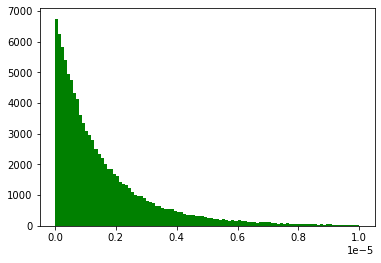

In [ ]:
x = gendata(nevents, lambd_plus, lambd_minus, probmuonminus) # create 


# create a histogram of the data
n, bins, patches = plt.hist(x,  bins=nbins, range=(0.,endtime),  facecolor='green', label='data')
#binwidth = 0.1

print(n)
print(bins)

bincentre = np.delete(bins + 0.5*(bins[2]-bins[1]),-1)
print(n)
print(bincentre)

### 3.5 Creating a fit for our data

In [ ]:
# call curve fit function
popt , pcov = curve_fit(f, bincentre, n)
a, b, c = popt
perr = np.sqrt(np.diag(pcov))
ea, eb, ec = perr

print(perr,'\n')
print("Optimal parameters are: \na=(%g +- %g), \nb=(%g +- %g), \nc=(%g +- %g)" % (a, ea, b, eb,  c, ec),'\n')
print("Optimal parameters are: \nNorm=(%g +- %g), \nlifetime lambda=(%g +- %g) s" % (a/(b*binsize), np.sqrt((ea*ea)/(b*b)+(a*a*eb*eb)/(b*b*b*b))/binsize,1.0/b, eb/(b*b)))


[  25.48080958 4862.26267282    6.84688601] 

Optimal parameters are: 
a=(6876.97 +- 25.4808), 
b=(741110 +- 4862.26), 
c=(67.4749 +- 6.84689) 

Optimal parameters are: 
Norm=(92792.8 +- 699.172), 
lifetime lambda=(1.34933e-06 +- 8.85265e-09) s


In [ ]:
# call curve fit function using f2 (sum of two exponentials)
popt , pcov = curve_fit (f2, bincentre, n)
a, b, c, a2, b2 = popt
perr = np.sqrt(np.diag(pcov))
ea, eb, ec, ea2, eb2 = perr

print(perr,'\n')
print("Optimal parameters are: \na=(%g +- %g), \nb=(%g +- %g), \na2=(%g +- %g), \nb2=(%g +- %g), \nc=(%g +- %g)" % (a, ea, b, eb,a2, ea2, b2, eb2,  c, ec),'\n')
print("Optimal parameters are: \nNorm=(%g +- %g), \nlifetime1 lambda=(%g +- %g) s , \nlifetime2 lambda=(%g +- %g) s, \nratio Np/Nm=(%g +- %g)" % ((a/(b*binsize)+a2/(b2*binsize)), np.sqrt((ea*ea)/(b*b)+(a*a*eb*eb)/(b*b*b*b))/binsize,1.0/b, eb/(b*b),1.0/b2, eb2/(b2*b2), a/a2, (a/a2)*np.sqrt(ea*ea/(a*a)+ea2*ea2/(a2*a2))))

[6.18796551e+02 4.53621138e+04 4.14213389e+01 5.93695214e+02
 1.34837614e+05] 

Optimal parameters are: 
a=(6091.53 +- 618.797), 
b=(846577 +- 45362.1), 
a2=(973.448 +- 593.695), 
b2=(314028 +- 134838), 
c=(-21.1143 +- 41.4213) 

Optimal parameters are: 
Norm=(102954 +- 8263.93), 
lifetime1 lambda=(1.18123e-06 +- 6.32936e-08) s , 
lifetime2 lambda=(3.18443e-06 +- 1.36733e-06) s, 
ratio Np/Nm=(6.25769 +- 3.86907)


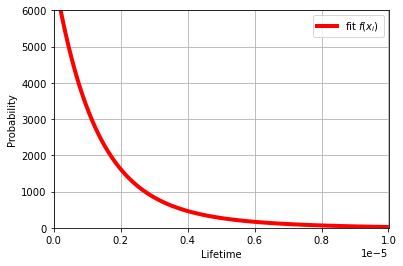

In [ ]:
plt.xlabel('Lifetime')
plt.ylabel('Probability')
plt.axis([0, endtime, 0, 6*nevents/nbins])
plt.grid(True)

yfitted = f2(bincentre, *popt) # equivalent to f(x, popt [0] , popt [1] , popt [2])
#red solid line r-
plt.plot (bincentre, yfitted , 'r-', label ='fit $f(x_i)$',linewidth =4)
plt.legend()
plt.show()